In [1]:
#!/usr/bin/python

import simulate_visibilities.Bulm as Bulm
import simulate_visibilities.simulate_visibilities as sv
import numpy as np
import numpy.linalg as la
import scipy.linalg as sla
import time, ephem, sys, os, resource, datetime, warnings
import aipy as ap
import os
#os.environ['QT_QPA_PLATFORM']='offscreen'
import sys
import matplotlib.pyplot as plt
import healpy as hp
import healpy.rotator as hpr
import healpy.pixelfunc as hpf
import healpy.visufunc as hpv
import scipy.interpolate as si
import glob
import astropy
from astropy.io import fits

from pyuvdata import UVData, UVCal, UVFITS
import hera_cal as hc
from hera_cal.data import DATA_PATH
from collections import OrderedDict as odict
from pyuvdata import utils as uvutils
import copy
import uvtools as uvt
import linsolve
from hera_cal.datacontainer import DataContainer
from astropy.time import Time
import omnical
import omnical.calibration_omni as omni
from memory_profiler import memory_usage as memuse
from collections import OrderedDict as odict
import pandas
import aipy.miriad as apm
import re
import copy


PI = np.pi
TPI = PI * 2


def pixelize(sky, nside_distribution, nside_standard, nside_start, thresh, final_index, thetas, phis, sizes):
	# thetas = []
	# phis = []
	for inest in range(12 * nside_start ** 2):
		pixelize_helper(sky, nside_distribution, nside_standard, nside_start, inest, thresh, final_index, thetas, phis,
						sizes)
		# newt, newp = pixelize_helper(sky, nside_distribution, nside_standard, nside_start, inest, thresh, final_index, thetas, phis)
		# thetas += newt.tolist()
		# phis += newp.tolist()
		# return np.array(thetas), np.array(phis)


def pixelize_helper(sky, nside_distribution, nside_standard, nside, inest, thresh, final_index, thetas, phis, sizes):
	# print "visiting ", nside, inest
	starti, endi = inest * nside_standard ** 2 / nside ** 2, (inest + 1) * nside_standard ** 2 / nside ** 2
	##local mean###if nside == nside_standard or np.std(sky[starti:endi])/np.mean(sky[starti:endi]) < thresh:
	if nside == nside_standard or np.std(sky[starti:endi]) < thresh:
		nside_distribution[starti:endi] = nside
		final_index[starti:endi] = len(thetas)  # range(len(thetas), len(thetas) + endi -starti)
		# return hp.pix2ang(nside, [inest], nest=True)
		newt, newp = hp.pix2ang(nside, [inest], nest=True)
		thetas += newt.tolist()
		phis += newp.tolist()
		sizes += (np.ones_like(newt) * nside_standard ** 2 / nside ** 2).tolist()
		# sizes += (np.ones_like(newt) / nside**2).tolist()

	else:
		# thetas = []
		# phis = []
		for jnest in range(inest * 4, (inest + 1) * 4):
			pixelize_helper(sky, nside_distribution, nside_standard, nside * 2, jnest, thresh, final_index, thetas,
							phis, sizes)
			# newt, newp = pixelize_helper(sky, nside_distribution, nside_standard, nside * 2, jnest, thresh)
			# thetas += newt.tolist()
			# phis += newp.tolist()
			# return np.array(thetas), np.array(phis)


def dot(A, B, C, nchunk=10):
	if A.ndim != 2 or B.ndim != 2 or C.ndim != 2:
		raise ValueError("A B C not all have 2 dims: %i %i %i" % (str(A.ndim), str(B.ndim), str(C.ndim)))

	chunk = len(C) / nchunk
	for i in range(nchunk):
		C[i * chunk:(i + 1) * chunk] = A[i * chunk:(i + 1) * chunk].dot(B)
	if chunk * nchunk < len(C):
		C[chunk * nchunk:] = A[chunk * nchunk:].dot(B)


def ATNIA(A, Ni, C, nchunk=20):  # C=AtNiA
	if A.ndim != 2 or C.ndim != 2 or Ni.ndim != 1:
		raise ValueError("A, AtNiA and Ni not all have correct dims: %i %i %i"%(A.ndim, C.ndim, Ni.ndim))

	expected_time = 1.3e-11 * (A.shape[0]) * (A.shape[1])**2
	print "Estimated time for A %i by %i"%(A.shape[0], A.shape[1]), expected_time, "minutes",
	sys.stdout.flush()

	chunk = len(C) / nchunk
	for i in range(nchunk):
		ltm = time.time()
		C[i * chunk:(i + 1) * chunk] = np.einsum('ji,jk->ik', A[:, i * chunk:(i + 1) * chunk] * Ni[:, None], A)
		if expected_time >= 1.:
			print "%i/%i: %.1fmins"%(i, nchunk, (time.time() - ltm)/60.),
			sys.stdout.flush()
	if chunk * nchunk < len(C):
		C[chunk * nchunk:] = np.einsum('ji,jk->ik', A[:, chunk * nchunk:] * Ni[:, None], A)


def solve_phase_degen(data_xx, data_yy, model_xx, model_yy, ubls, plot=False):#data should be time by ubl at single freq. data * phasegensolution = model
	if data_xx.shape != data_yy.shape or data_xx.shape != model_xx.shape or data_xx.shape != model_yy.shape or data_xx.shape[1] != ubls.shape[0]:
		raise ValueError("Shapes mismatch: %s %s %s %s, ubl shape %s"%(data_xx.shape, data_yy.shape, model_xx.shape, model_yy.shape, ubls.shape))
	A = np.zeros((len(ubls) * 2, 2))
	b = np.zeros(len(ubls) * 2)

	nrow = 0
	for p, (data, model) in enumerate(zip([data_xx, data_yy], [model_xx, model_yy])):
		for u, ubl in enumerate(ubls):
			amp_mask = (np.abs(data[:, u]) > (np.median(np.abs(data[:, u])) / 2.))
			A[nrow] = ubl[:2]
			b[nrow] = omni.medianAngle(np.angle(model[:, u] / data[:, u])[amp_mask])
			nrow += 1
	phase_cal = omni.solve_slope(np.array(A), np.array(b), 1)
	if plot:
		plt.hist((np.array(A).dot(phase_cal)-b + PI)%TPI-PI)
		plt.title('phase fitting error')
		plt.show()

	#sooolve
	return phase_cal

class LastUpdatedOrderedDict(odict):
	'Store items in the order the keys were last added'

	def __setitem__(self, key, value):
		if key in self:
			del self[key]
		odict.__setitem__(self, key, value)

def S_casa_v_t(v, t = 2015.5):		
	S_0 = 2190.294 #S_casA_1GHz
	alpha =  0.725
	belta = 0.0148
	tau = 6.162*1.e-5

	a = -0.00633 #+-0.00024 year-1 
	b = 0.00039 #+-0.00008 year -1
	c = 1.509*1.e-7 #+-0.162*1.e-7 year-1
	
	v *= 1.e-3
	
	#print(v) # from MHz to GHz
	#print(t) # in decimal year
	
	S_casa_v = S_0 * v**(-alpha + belta * np.log(v)) * np.exp(-tau * v**(-2.1)) #S_0: 2015.5
	d_speed_log_v = a + b * np.log(v) + c * v**(-2.1) #a,b,c: 2005.0
	S_casa_v_t = np.exp((t - 2015.5) * d_speed_log_v + np.log(S_casa_v))
	
	#print(d_speed_log_v)
	
	return S_casa_v_t
	
def S_cyga_v(v, t = 2005):
	S_cyga_v = 3.835 * 1.e5 * v**(-0.718) * np.exp(-0.342 * (21.713/v)**2.1)
	
	return S_cyga_v



INSTRUMENT = ''

In [2]:
#####commandline inputs#####
if len(sys.argv) == 1:
	INSTRUMENT = 'hera47'
else:
	INSTRUMENT = sys.argv[1]#'miteor'#'mwa'#'hera-47''paper'

INSTRUMENT = 'hera47' #'hera47'; 'miteor'
print INSTRUMENT

tag = '-ampcal-' #'-ampcal-' #sys.argv[2]; if use real uncalibrated data, set tag = '-ampcal-' for amplitude calibration.

AtNiA_only = False
if len(sys.argv) > 3 and sys.argv[3][:5] == 'atnia':
	AtNiA_only = True
	pixel_scheme_number = int(sys.argv[3][5:])
	
simulation_opt = 1

plotcoord = 'CG'
baseline_safety_factor = 10.#max_ubl = 1.4*lambda/baseline_safety_factor
crosstalk_type = 'autocorr'
#pixel_directory = '/home/omniscope/data/GSM_data/absolute_calibrated_data/'

plot_pixelization = True and not AtNiA_only
plot_projection = True and not AtNiA_only
plot_data_error = True and not AtNiA_only

force_recompute = False
force_recompute_AtNiAi_eig = False
force_recompute_AtNiAi = False
force_recompute_S = False
force_recompute_SEi = False

C = 299.792458
kB = 1.3806488 * 1.e-23

try:
	__file__
except NameError:
	#script_dir = '/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/simulate_visibilities/scripts'
	script_dir = os.path.join(DATA_PATH, '../../../HERA_MapMaking_VisibilitySimulation/scripts')
	pixel_directory = script_dir
	print 'Run IPython'
else:
	script_dir = os.path.dirname(os.path.realpath(__file__))
	pixel_directory = script_dir
	print 'Run Python'


hera47
Run IPython


In [3]:
len(sys.argv)

3

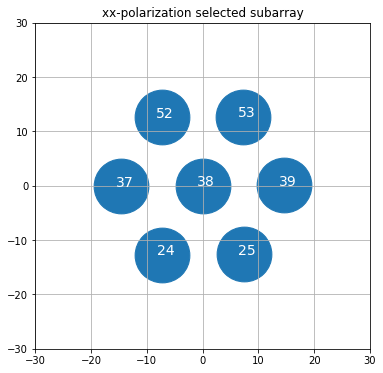

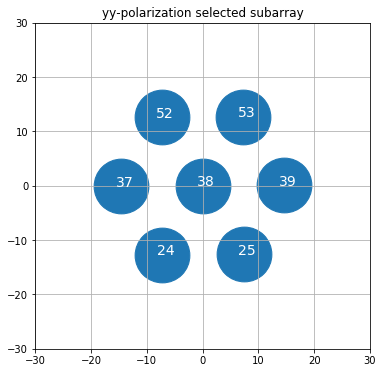

>>>>>>Used nUBL = 9, nt = 60.
Frequencies: 
[ 50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.
  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.
  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.
  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105.
 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119.
 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133.
 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147.
 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158. 159. 160. 161.
 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172. 173. 174. 175.
 176. 177. 178. 179. 180. 181. 182. 183. 184. 185. 186. 187. 188. 189.
 190. 191. 192. 193. 194. 195. 196. 197. 198. 199. 200. 201. 202. 203.
 204. 205. 206. 207. 208. 209. 210. 211. 212. 213. 214. 215. 216. 217.
 218. 219. 220. 221. 222. 223. 224. 225. 226. 227. 228. 229. 230. 231.
 232. 233. 234. 235. 236. 237. 23

In [4]:
####################################################
################data file and load beam##############
####################################################
if INSTRUMENT == 'miteor':
	Simulation = True
	Use_SimulatedData = False
	Use_Simulation_noise = False
	
	sys.stdout.flush()
	S_type = 'dyS_lowadduniform_lowI' #'dyS_lowadduniform_lowI'#'none'#'dyS_lowadduniform_Iuniform'  #'none'# dynamic S, addlimit:additive same level as max data; lowaddlimit: 10% of max data; lowadduniform: 10% of median max data; Iuniform median of all data

	seek_optimal_threshs = False and not AtNiA_only
	dynamic_precision = .2#.1#ratio of dynamic pixelization error vs data std, in units of data, so not power
	thresh = 2#.2#2.#.03125#
	valid_pix_thresh = 1.e-4
	nside_start = 32
	nside_standard = 32 # Determine the resolution of GSM of sky

	pre_calibrate = True
	pre_ampcal = ('qC' in tag)
	pre_phscal = True
	pre_addcal = True
	fit_for_additive = False
	nside_beamweight = 16 # Determin shape of A matrix
	
	Integration_Time = 144 # seconds
	Frequency_Bin = 0.75*1.e6 # Hz
	
	lat_degree = 45.2977
	lst_offset = 5.#lsts will be wrapped around [lst_offset, 24+lst_offset]
#	# tag = "q3AL_5_abscal"  #"q0AL_13_abscal"  #"q1AL_10_abscal"'q3_abscalibrated'#"q4AL_3_abscal"# L stands for lenient in flagging
	if 'ampcal' in tag:
		datatag = '_2016_01_20_avg'#'_seccasa.rad'#
		vartag = '_2016_01_20_avgx100'#''#
	else:
		datatag = '_2016_01_20_avg2_unpollock'#'_2016_01_20_avg_unpollock'#'_seccasa.rad'#
		vartag = '_2016_01_20_avg2_unpollock'#'_2016_01_20_avg_unpollockx100'#''#
#	datadir = '/home/omniscope/data/GSM_data/absolute_calibrated_data/'
	datadir = script_dir + '/../Output/'
	antpairs = None
	# deal with beam: create a callable function of the form y(freq) in MHz and returns 2 by npix
	
	
	############################################ Load Beam and Visibility Data ###########################################
	vis_freq_list = flist = np.array([126.83333,127.6667,128.5000,129.3333,130.1667,131.0000,131.8333,132.6667,133.5000,134.3333,135.1667,136.0000,136.8333,137.6667,139.3333,140.0000,141.83333,142.6667,143.5000,144.3333,145.0000,145.1667,146.0000,146.6667,147.5000,148.3333,150.8333,151.6667,152.5000,153.3333,154.1667,155.0000,155.8333,156.0000,156.6667,156.8333,159.3333,161.8333,164.3333,166.8333,167.8333,170.3333,172.8333])
	freq = vis_freq_selected = 150.8333 #MHz
	
	if tag == '-ampcal-':
		tag = '%s-%f'%(INSTRUMENT, freq) + tag
	else:
		tag = '%s-%f'%(INSTRUMENT, freq)
	
	bnside = 64 #Depend on beam pattern data
	freqs = range(110, 200, 10)
	local_beam_unpol = si.interp1d(freqs, np.array([la.norm(np.loadtxt(
		script_dir + '/../data/MITEoR/beam/%s.txt'%(p), skiprows=0).reshape(
		(len(freqs), 12 * bnside ** 2, 4)), axis=-1)**2 for p in ['x', 'y']]).transpose(1, 0, 2), axis=0)
	Plot_Beam = True
	if Plot_Beam:
		plt.figure(0)
		#ind = np.where(beam_freqs == freq)[0][0]
		hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[0,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
				unit='dBi')
	#     hp.mollview(10.0 * np.log10(beam_E[ind,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
	#             unit='dBi')
		plt.savefig(script_dir + '/../Output/%s-dipole-Beam-east-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
		hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[1,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
				unit='dBi')
	#     hp.mollview(10.0 * np.log10(beam_N[ind,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
	#             unit='dBi')
		plt.savefig(script_dir + '/../Output/%s-dipole-Beam-north-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
		plt.show(block=False)
		#plt.gcf().clear()
			#plt.clf()
			#plt.close()
			
	time_vis_data = np.array([np.loadtxt(script_dir + '/../data/MITEoR/visibilities/%sMHz_%s%s_A.txt'%(vis_freq_selected,p,p)) for p in ['x','y']])
	
	vis_data = (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex128')
	var_data = time_vis_data[:,1:,3::3]
	
	tlist = time_vis_data[0,1:,0]
	tmasks = {}
	for p in ['x', 'y']:
		tmasks[p] = np.ones_like(tlist).astype(bool)

	tmask = tmasks['x']&tmasks['y']
	tlist = tlist[tmask]
	nt = nt_used = len(tlist)
	jansky2kelvin = 1.e-26 * (C / freq) ** 2 / 2 / kB / (4 * PI / (12 * nside_standard ** 2))
	nUBL = int(len(time_vis_data[0,0,:])/3)
	
	ubls = {}
	for p in range(2):
		ubls[['x','y'][p]] = time_vis_data[p,0,1:].reshape((nUBL,3))		
	common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
	#manually filter UBLs
	used_common_ubls = common_ubls[la.norm(common_ubls, axis=-1) / (C / freq) <= 1.4 * nside_standard / baseline_safety_factor]#[np.argsort(la.norm(common_ubls, axis=-1))[10:]]     #remove shorted 10
	nUBL_used = len(used_common_ubls)
	ubl_index = {}  # stored index in each pol's ubl for the common ubls
	for p in ['x', 'y']:
		ubl_index[p] = np.zeros(nUBL_used, dtype='int')
		for i, u in enumerate(used_common_ubls):
			if u in ubls[p]:
				ubl_index[p][i] = np.argmin(la.norm(ubls[p] - u, axis=-1)) + 1
			elif -u in ubls[p]:
				ubl_index[p][i] = - np.argmin(la.norm(ubls[p] + u, axis=-1)) - 1
			else:
				raise Exception('Logical Error')

	print '>>>>>>Used nUBL = %i, nt = %i.'%(nUBL_used, nt_used)
	sys.stdout.flush()	
	
	
elif INSTRUMENT == 'hera47':
	Simulation = True
	Use_SimulatedData = False
	Use_Simulation_noise = True
	From_File_Data = True
	Keep_Red = False
	Absolute_Calibration = False
	Absolute_Calibration_red = False
	Absolute_Calibration_mfreq = False
	Absolute_Calibration_dred = False
	Absolute_Calibration_dred_mfreq = True
	PointSource_AbsCal = True
	
	Use_AbsCal = True # Use Model calculated noise which is just fullsim autocorr calculated noise.
	Use_PsAbsCal = True # higher priority over Use_AbsCal and Use_Fullsim_Noise. if comply_ps2mod_autocorr then become just fullsim autocorr calculated noise.
	comply_ps2mod_autocorr = False
	Use_Fullsim_Noise = False # Use fullsim autocorr calculated noise.
	
	Replace_Data = True
	
	pre_calibrate = True
	tag = '-ampcal-' if pre_calibrate else '' #'-ampcal-' #sys.argv[2]; if use real uncalibrated data, set tag = '-ampcal-' for amplitude calibration.
	pre_ampcal = ('ampcal' in tag)
	pre_phscal = True
	pre_addcal = True
	fit_for_additive = True
	
	Add_S_diag = False
	Add_Rcond = True
	
	sys.stdout.flush()
	
	lat_degree = -30.72153 #lon='21:25:41.9' lat='-30:43:17.5'
	lst_offset = 1.43#lsts will be wrapped around [lst_offset, 24+lst_offset]

	Integration_Time = 11 # seconds
	Frequency_Bin = 1.625*1.e6 # Hz

	S_type = 'dyS_lowadduniform_max8I' if Add_S_diag else 'no_use' #'dyS_lowadduniform_minI', 'dyS_lowadduniform_I', 'dyS_lowadduniform_lowI', 'dyS_lowadduniform_lowI'#'none'#'dyS_lowadduniform_Iuniform'  #'none'# dynamic S, addlimit:additive same level as max data; lowaddlimit: 10% of max data; lowadduniform: 10% of median max data; Iuniform median of all data
	rcond_list = 10.**np.arange(-7., -0., 1.)
    
	seek_optimal_threshs = False and not AtNiA_only
	dynamic_precision = .2#.1#ratio of dynamic pixelization error vs data std, in units of data, so not power
	thresh = 2#.2#2.#.03125#
	valid_pix_thresh = 1.e-4
	nside_start = 32
	nside_standard = 32 # resolution of sky
	nside_beamweight = 16 # A matrix shape
	bnside = 64 # beam pattern data resolution
	
	
#	# tag = "q3AL_5_abscal"  #"q0AL_13_abscal"  #"q1AL_10_abscal"'q3_abscalibrated'#"q4AL_3_abscal"# L stands for lenient in flagging
	if 'ampcal' in tag:
		datatag = '_2018_'#'_seccasa.rad'#
		vartag = '_2018_'#''#
	else:
		datatag = '_2018_ampcaled_'#'_2016_01_20_avg_unpollock'#'_seccasa.rad'#
		vartag = '_2018_ampcaled_'#'_2016_01_20_avg_unpollockx100'#''#
	datadir = script_dir + '/../Output/'
	antpairs = None
	
	#######################################################################################################
	##################################### Load Visibility Data ###########################################
	# specify model file and load into UVData, load into dictionary
	Small_ModelData = True
	Model_Calibration = False
	
	model_fname = {}
	model = {}
	mflags = {}
	mantpos = {}
	mant = {}
	model_freqs = {}
	model_times = {}
	model_lsts = {}
	model_pols = {}
	data_fname = {}
	data_fname_full = {}
	dflags = {}
	data = {}
	antpos = {}
	ants = {}
	data_freqs = {}
	data_times = {}
	data_lsts = {}
	data_pols = {}
	
	fulldflags = {}
	
	if Small_ModelData:
		if Model_Calibration:
			model_fname = {}
			model = mflags = mantpos = mant = model_freqs = model_times = model_lsts = model_pols = {}
			for i in range(2):
				model_fname[i] = os.path.join(DATA_PATH, "zen.2458042.12552.%s.HH.uvXA"%['xx','yy'][i]) #/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.xx.HH.uv
				#model_fname[1] = os.path.join(DATA_PATH, "zen.2458042.12552.xx.HH.uvXA") #/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.xx.HH.uv
				(model[i], mflags[i], mantpos[i], mants[i], model_freqs[i], model_times[i], model_lsts[i],
				 model_pols[i]) = hc.abscal.UVData2AbsCalDict(model_fname[i], return_meta=True)
			
#			data_fname_omni = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
#			(data_omni, dflags_omni, antpos_omni, ants_omni, data_freqs_omni, data_times_omni, data_lsts_omni, 
#			 data_pols_omni) = hc.abscal.UVData2AbsCalDict(data_fname_omni, return_meta=True)
		
		# specify data file and load into UVData, load into dictionary
		for i in range(2):
			data_fname[i] = os.path.join(DATA_PATH, "zen.2458043.12552.%s.HH.uvORA"%['xx', 'yy'][i]) #zen.2457698.40355.xx.HH.uvcA
			if i == 1:
				try:
					#data_fname[1] = os.path.join(DATA_PATH, "zen.2458043.12552.yy.HH.uvORA") #zen.2457698.40355.yy.HH.uvcA
					if not os.path.isfile(data_fname[i]):
						data_fname[1] = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
				except:
					pass
			data_fname_full[i] = os.path.join(DATA_PATH, 'Observation-1192287662/2458043/zen.2458043.12552.%s.HH.uvOR'%['xx', 'yy'][i])
			(data[i], dflags[i], antpos[i], ants[i], data_freqs[i], data_times[i], data_lsts[i], 
			 data_pols[i]) = hc.abscal.UVData2AbsCalDict(data_fname[i], return_meta=True)
			
#		try:
#			data_fname_yy = os.path.join(DATA_PATH, "zen.2458043.12552.yy.HH.uvORA") #zen.2457698.40355.yy.HH.uvcA
#			if not os.path.isfile(data_fname_yy):
#				data_fname_yy = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
#		except:
#			pass
#		data_fname_yy_full = "/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192287662/2458043/zen.2458043.12552.yy.HH.uvOR"
#		(data_yy, dflags[1], antpos_yy, ants_yy, data_freqs_yy, data_times_yy, data_lsts_yy, 
#		 data_pols_yy) = hc.abscal.UVData2AbsCalDict(data_fname_yy, return_meta=True)
		
		
	else:
		if Model_Calibration:
#			model_fname1 = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.xx.HH.uv'
#			model_fname2 = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.xx.HH.uv'
#			model_fname1_yy = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.yy.HH.uv'
#			model_fname2_yy = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.yy.HH.uv'
#			(model, mflags, antpos, ants, model_freqs, model_times, model_lsts,
#			 model_pols) = hc.abscal.UVData2AbsCalDict(model_fname1, return_meta=True) # also can try model_fname2
#			(model_yy, mflags_yy, antpos_yy, ants_yy, model_freqs_yy, model_times_yy, model_lsts_yy,
#			 model_pols_yy) = hc.abscal.UVData2AbsCalDict(model_fname2, return_meta=True) # also can try model_fname2
			
			model_fname_dred = {}
			model_dred = mflags_dred = mantpos_dred = mant_dred = model_freqs_dred = model_times_dred = model_lsts_dred = model_pols_dred = {}
			for i in range(2):
				#model_fname[i] = "/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.12552.%s.HH.uv"%['xx','yy'][i]#/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.xx.HH.uv
				model_fname[i] = os.path.join(DATA_PATH, 'Observation-1192115507/2458042/zen.2458042.12552.%s.HH.uv'%['xx','yy'][i])
				#model_fname[1] = os.path.join(DATA_PATH, "zen.2458042.12552.xx.HH.uvXA") #/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.xx.HH.uv
#				(model_dred[i], mflags_dred[i], mantpos_dred[i], mants_dred[i], model_freqs_dred[i], model_times_dred[i], model_lsts_dred[i],
#				 model_pols_dred[i]) = hc.abscal.UVData2AbsCalDict(model_fname_dred[i], return_meta=True)
				(model[i], mflags[i], mantpos[i], mants[i], model_freqs[i], model_times[i], model_lsts[i],
				 model_pols[i]) = hc.abscal.UVData2AbsCalDict(model_fname[i], return_meta=True)
			
#			data_fname_omni = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
#			(data_omni, dflags_omni, antpos_omni, ants_omni, data_freqs_omni, data_times_omni, data_lsts_omni, 
#			 data_pols_omni) = hc.abscal.UVData2AbsCalDict(data_fname_omni, return_meta=True)
		
		# specify data file and load into UVData, load into dictionary
		
		for i in range(2):
			data_fname[i] = os.path.join(DATA_PATH, 'Observation-1192287662/2458043/zen.2458043.12552.%s.HH.uvOR'%['xx', 'yy'][i])
			#data_fname[i] = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192287662/2458043/zen.2458043.12552.%s.HH.uvOR'%['xx', 'yy'][i]
			(data[i], dflags[i], antpos[i], ants[i], data_freqs[i], data_times[i], data_lsts[i], 
			 data_pols[i]) = hc.abscal.UVData2AbsCalDict(data_fname[i], return_meta=True)
		
#		data_fname_yy = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192287662/2458043/zen.2458043.12552.yy.HH.uvOR'
#		(data_yy, dflags_yy, antpos_yy, ants_yy, data_freqs_yy, data_times_yy, data_lsts_yy, 
#		 data_pols_yy) = hc.abscal.UVData2AbsCalDict(data_fname_yy, return_meta=True)
		
		
#	model, interp_flags = hc.abscal.interp2d_vis(model, model_lsts, model_freqs, data_lsts, data_freqs) #interpolate model onto time & freq axes of data
#	# instantiate class
#	AC = hc.abscal.AbsCal(model, data, antpos=antpos, wgts=wgts, freqs=data_freqs) #Instantiate AbsCal object
	
	################# Select Frequency ####################
	flist = {}
	index_freq = {}
	antloc = {}
	dflags_sf = {} #single frequency
	for i in range(2):
		flist[i] = np.array(data_freqs[i])/10**6
		try:
			index_freq[i] = np.where(flist[i]==150)[0][0]
	#		index_freq = 512
		except:
			index_freq[i] = len(flist[i])/2
	
	for i in range(2):
		dflags_sf[i] = LastUpdatedOrderedDict()
		for key in dflags[i].keys():
			dflags_sf[i][key] = dflags[i][key][:,index_freq[i]]
	
	# ant locations
	for i in range(2): 
		antloc[i] = np.array(map(lambda k: antpos[i][k], ants[i]))
#	antloc_yy = np.array(map(lambda k: antpos_yy[k], ants_yy))
	
	# plot sub-array HERA layout
	for j in range(2):
		plt.figure(100000+5*j, figsize=(6,6))
		plt.grid()
		plt.scatter(antloc[j][:, 0], antloc[j][:, 1], s=3000)
		_ = [plt.text(antloc[j][i, 0]-1, antloc[j][i, 1], str(ants[j][i]), fontsize=14, color='w') for i in range(len(antloc[j]))]
		plt.title('%s-polarization selected subarray'%['xx', 'yy'][j])
		plt.xlim(-30, 30)
		plt.ylim(-30, 30)
		plt.show(block=False)
		#plt.cla()

	############################## Autocorrelation #################################
	xxfile = data_fname[0] if not Small_ModelData else data_fname_full[0]
	yyfile = data_fname[1] if not Small_ModelData else data_fname_full[1]
	
	# Load data for autocorrelation calculating
	uvd_xx = UVData()
	uvd_xx.read_miriad(xxfile)
	uvd_xx.ants = np.unique(np.concatenate([uvd_xx.ant_1_array, uvd_xx.ant_2_array]))
	uvd_yy = UVData()
	uvd_yy.read_miriad(yyfile)
	uvd_yy.ants = np.unique(np.concatenate([uvd_yy.ant_1_array, uvd_yy.ant_2_array]))

	# Get metadata
	freqs = uvd_xx.freq_array.squeeze() / 1e6
	times = uvd_xx.time_array.reshape(uvd_xx.Ntimes, uvd_xx.Nbls)[:, 0]
	jd_start = np.floor(times.min())
	Nfreqs = len(freqs)
	Ntimes = len(times)

	# get redundant info
	aa = hc.utils.get_aa_from_uv(uvd_xx)
	info = hc.omni.aa_to_info(aa)
	red_bls = np.array(info.get_reds())
	ants = sorted(np.unique(np.concatenate(red_bls)))
	Nants = len(ants)
	Nside = int(np.ceil(np.sqrt(Nants)))
	Yside = int(np.ceil(float(Nants)/Nside))
	
	try:
		plot_data_autocorr = False
		if plot_data_autocorr: # at specific frequency
			### plot autos
			t_index = 0
			jd = times[t_index]
			utc = Time(jd, format='jd').datetime

			xlim = (-50, Nfreqs+50)
			ylim = (-10,30)

			fig, axes = plt.subplots(Yside, Nside, figsize=(14,14), dpi=75)
			fig.subplots_adjust(wspace=0.2, hspace=0.2)
			fig.suptitle("JD = {0}, time = {1} UTC".format(jd, utc), fontsize=14)
			fig.tight_layout(rect=(0, 0, 1, 0.95))

			k = 0
			for i in range(Yside):
				for j in range(Nside):
					ax = axes[i,j]
					ax.set_xlim(xlim)
					ax.set_ylim(ylim)
					if k < Nants:
						px, = ax.plot(10*np.log10(np.abs(uvd_xx.get_data((ants[k], ants[k]))[t_index])), color='steelblue', alpha=0.75, linewidth=3)
						py, = ax.plot(10*np.log10(np.abs(uvd_yy.get_data((ants[k], ants[k]))[t_index])), color='darkorange', alpha=0.75, linewidth=3)
						ax.grid(True, which='both')
						ax.set_title(str(ants[k]), fontsize=14)
						if k == 0:
							ax.legend([px, py], ['East', 'North'], fontsize=12)
					else:
						ax.axis('off')
					if j != 0:
						ax.set_yticklabels([])
					else:
						[t.set_fontsize(12) for t in ax.get_yticklabels()]
						ax.set_ylabel(r'$10\cdot\log_{10}$ amplitude', fontsize=14)
					if i != Yside-1:
						ax.set_xticklabels([])
					else:
						[t.set_fontsize(12) for t in ax.get_xticklabels()]
						ax.set_xlabel('freq channel', fontsize=14)

					k += 1
			plt.show(block=False)
		
	except:
		pass
		
	autocorr_data_mfreq = {} #np.zeros((2, Ntimes, Nfreqs))
	autocorr_data_mfreq[0] = np.mean(np.array([np.abs(uvd_xx.get_data((ants[k], ants[k]))) for k in range(Nants)]), axis=0)
	autocorr_data_mfreq[1] = np.mean(np.array([np.abs(uvd_yy.get_data((ants[k], ants[k]))) for k in range(Nants)]), axis=0)
	autocorr_data =  {}
	for i in range(2):
		autocorr_data[i] = autocorr_data_mfreq[i][:,index_freq[i]]
		
	if Replace_Data:	
		findex = np.where(freqs==150)
		findex_list = {}
		autocorr_data_mfreq_ff = {}
		for i in range(2):
			findex_list[i] = np.array([np.where(freqs==flist[i][j])[0][0] for j in range(len(flist[i]))])
			
		data_ff = {}
		dflags_ff = {}
		for i in range(2):
			data_ff[i] = LastUpdatedOrderedDict()
			dflags_ff[i] = LastUpdatedOrderedDict()
			for id_key, key in enumerate(dflags[i].keys()):
				#key[2] = 'xx' if i == 0 else 'yy'
				data_ff[i][key[0], key[1], 'xx' if i == 0 else 'yy'] = uvd_xx.get_data((key[0], key[1]))[:,findex_list[i]] if i == 0 else uvd_yy.get_data((key[0], key[1]))[:,findex_list[i]]
				autocorr_data_mfreq_ff[i] = autocorr_data_mfreq[i][:, findex_list[i]]
				dflags_ff[i][key[0], key[1], 'xx' if i == 0 else 'yy'] = dflags[i][key]
						#del data_ff[dflags[i].keys()[id_key]]
		
		data = copy.deepcopy(data_ff)
		dflags = copy.deepcopy(dflags_ff)
		autocorr_data_mfreq = copy.deepcopy(autocorr_data_mfreq_ff)	
		
		del(data_ff)
		del(dflags_ff)
		del(autocorr_data_mfreq_ff)
	#del(autocorr_data_mfreq)
		
	del(uvd_xx)
	del(uvd_yy)
	del(aa)
	del(info)
	
	
	
#	plt.figure(100005, figsize=(6,6))
#	plt.grid()
#	plt.scatter(antloc_yy[:, 0], antloc_yy[:, 1], s=3000)
#	_ = [plt.text(antloc_yy[i, 0]-1, antloc_yy[i, 1], str(ants_yy[i]), fontsize=14, color='w') for i in range(len(antloc_yy))]
#	plt.title('yy polarization selected subarray')
#	plt.xlim(-30, 30)
#	plt.ylim(-30, 30)
#	plt.show(block=False)
	
	
	#bls = odict([(x, antpos[x[0]] - antpos[x[1]]) for x in model.keys()])
	bls = [[],[]]
	for i in range(2):
		bls[i] = odict([(x, antpos[i][x[0]] - antpos[i][x[1]]) for x in data[i].keys()])
		#bls[1] = odict([(y, antpos_yy[y[0]] - antpos_yy[y[1]]) for y in data_yy.keys()])
		bls = np.array(bls)
	
	bsl_coord = [[],[]]
	bsl_coord_x = bsl_coord[0] = np.array([bls[0][index] for index in bls[0].keys()])
	bsl_coord_y = bsl_coord[1] = np.array([bls[1][index] for index in bls[1].keys()])
	#bsl_coord_x=bsl_coord_y=bsl_coord
	bsl_coord = np.array(bsl_coord)
	
	
	########################### Visibility ##############################
	vis_data_mfreq = {}
	#vis_data_Omni_mfreq = np.array([data_omni[bslkeys] for bslkeys in data_omni.keys()], dtype='complex128').transpose((2,1,0)) if Model_Calibration else None
	for i in range(2):
		vis_data_mfreq[i] = np.array([data[i][bslkeys] for bslkeys in data[i].keys()], dtype='complex128').transpose((2,1,0))
#	vis_data_mfreq = np.array([data_yy[bslkeys] for bslkeys in data_yy.keys()], dtype='complex128').transpose((2,1,0))
	
#	vis_data_mfreq = np.zeros((2,vis_data_xx_mfreq.shape[0], vis_data_xx_mfreq.shape[1], vis_data_xx_mfreq.shape[2]), dtype='complex128')
#	vis_data_mfreq[0] = vis_data_xx_mfreq
#	vis_data_mfreq[1] = vis_data_yy_mfreq

	vis_freq_selected = freq = flist[0][index_freq[0]] #MHz For Omni:  0:100, 16:125, 32:150, 48:175;;; For Model:  512:150MHz   Choose xx as reference
	#vis_data = np.zeros((2,vis_data_mfreq.shape[2], vis_data_xx_mfreq.shape[3]), dtype='complex128')
	vis_data = {}
	for i in range(2):
		vis_data[i] = vis_data_mfreq[i][index_freq[i], :, :] # [pol][ freq, time, bl] 

	#del(vis_data_mfreq)
		

	################################## Unique Base Lines and Remove Redundancy ########################################
	
#	np.array(omnical.arrayinfo.compute_reds(antloc)) # Alternate way to compute.
	Ubl_list_raw = [[],[]]
	Ubl_list = [[],[]]
	ant_pos = [[],[]]
	
	Nubl_raw = np.zeros(2, dtype=int)
	times_raw = np.zeros(2, dtype=int)
	times_raw_list = [[],[]]
	redundancy = [[],[]]
	bsl_coord_dred = [[],[]]
	vis_data_dred = [[],[]]
	vis_data_dred_mfreq = [[],[]]
	
	for i in range(2):
		Ubl_list_raw[i] = np.array(omnical.arrayinfo.compute_reds_total(antloc[i])) ## Note that a new function has been added into omnical.arrayinfo as "compute_reds_total" which include all ubls not only redundant ones.
	#Ubl_list_raw[1] = np.array(omnical.arrayinfo.compute_reds_total(antloc_yy)) ## Note that a new function has been added into omnical.arrayinfo as "compute_reds_total" which include all ubls not only redundant ones.
		ant_pos[i] = antpos[i]
	#ant_pos[1] = antpos_yy
	for i in range(2):
		for i_ubl in range(len(Ubl_list_raw[i])):
			list_bsl = []
			for i_ubl_pair in range(len(Ubl_list_raw[0][i_ubl])):
				try:
					list_bsl.append(bls[i].keys().index((ant_pos[i].keys()[Ubl_list_raw[i][i_ubl][i_ubl_pair][0]], ant_pos[i].keys()[Ubl_list_raw[i][i_ubl][i_ubl_pair][1]], '%s'%['xx','yy'][i])))
				except:
					list_bsl.append(bls[i].keys().index((ant_pos[i].keys()[Ubl_list_raw[i][i_ubl][i_ubl_pair][0]], ant_pos[i].keys()[Ubl_list_raw[i][i_ubl][i_ubl_pair][1]], '%s'%['xx','yy'][1-i])))
			Ubl_list[i].append(list_bsl)
	
	for i in range(2):		
		Nubl_raw[i] = len(Ubl_list[i])
		times_raw[i] = len(data_times[i])
		times_raw_list[i] = data_times[i]
		bsl_coord_dred[i] = np.zeros((Nubl_raw[i], 3))
		vis_data_dred[i] = np.zeros((times_raw[i], Nubl_raw[i]), dtype='complex128')
		vis_data_dred_mfreq[i] = np.zeros((len(flist[i]), times_raw[i], Nubl_raw[i]), dtype='complex128')
	
	try:
		var_data_dred = [[],[]]
		var_data_dred[0] = np.zeros((times_raw[0], Nubl_raw[0]), dtype='complex128')
		var_data_dred[1] = np.zeros((times_raw[1], Nubl_raw[1]), dtype='complex128')
	except:
		pass
		
	
	########################### Average on Redundant baselines #############################
	#data_dred = {}
	dflags_dred = {}
		
	for i in range(2):
		#data_dred[i] = {}
		#dflags_dred[i] = {}
		dflags_dred[i] = LastUpdatedOrderedDict()
		pol = ['xx', 'yy'][i]
		
		for i_ubl in range(Nubl_raw[0]):
			vis_data_dred[i][:, i_ubl] = np.mean(vis_data[i].transpose()[Ubl_list[i][i_ubl]].transpose(), axis=1)
			bsl_coord_dred[i][i_ubl] = np.mean(bsl_coord[i][Ubl_list[i][i_ubl]], axis=0)
			#if Absolute_Calibration_dred:
			dflags_dred[i][dflags_sf[i].keys()[Ubl_list[i][i_ubl][0]]] = dflags_sf[i][dflags_sf[i].keys()[Ubl_list[i][i_ubl][0]]]
#				if i == 0:
#					#data_dred[i][dflags.keys()[Ubl_list[i][i_ubl][0]]] = vis_data_dred[i][:, i_ubl]
#					dflags_dred[i][dflags.keys()[Ubl_list[i][i_ubl][0]]] = dflags[dflags.keys()[Ubl_list[i][i_ubl][0]]]
#				else:
#					#data_dred[i][dflags_yy.keys()[Ubl_list[i][i_ubl][0]]] = vis_data_dred[i][:, i_ubl]
#					dflags_dred[i][dflags_yy.keys()[Ubl_list[i][i_ubl][0]]] = dflags_yy[dflags_yy.keys()[Ubl_list[i][i_ubl][0]]]
			redundancy[i].append(len(Ubl_list[i][i_ubl]))
			try:
				var_data_dred[i][:, i_ubl] = np.mean(var_data[i].transpose()[Ubl_list[i][i_ubl]].transpose(), axis=1)
			except:
				pass
				
				
	#vis_data_dred_mfreq = [[],[]]
	dflags_dred_mfreq = {}
		
	for i in range(2):
		#data_dred_mfreq[i] = {}
		#dflags_dred_mfreq[i] = {}
		dflags_dred_mfreq[i] = LastUpdatedOrderedDict()
		pol = ['xx', 'yy'][i]
		
		for i_ubl in range(Nubl_raw[0]):
			vis_data_dred_mfreq[i][:, :, i_ubl] = np.mean(vis_data_mfreq[i][ :, :, Ubl_list[i][i_ubl]], axis=-1)
			#bsl_coord_dred[i][i_ubl] = np.mean(bsl_coord[i][Ubl_list[i][i_ubl]], axis=0)
			#if Absolute_Calibration_dred_mfreq:
			dflags_dred_mfreq[i][dflags[i].keys()[Ubl_list[i][i_ubl][0]]] = dflags[i][dflags[i].keys()[Ubl_list[i][i_ubl][0]]]
#				if i == 0:
#					#data_dred[i][dflags.keys()[Ubl_list[i][i_ubl][0]]] = vis_data_dred[i][:, i_ubl]
#					dflags_dred[i][dflags.keys()[Ubl_list[i][i_ubl][0]]] = dflags[dflags.keys()[Ubl_list[i][i_ubl][0]]]
#				else:
#					#data_dred[i][dflags_yy.keys()[Ubl_list[i][i_ubl][0]]] = vis_data_dred[i][:, i_ubl]
#					dflags_dred[i][dflags_yy.keys()[Ubl_list[i][i_ubl][0]]] = dflags_yy[dflags_yy.keys()[Ubl_list[i][i_ubl][0]]]
			#redundancy[i].append(len(Ubl_list[i][i_ubl]))
			try:
				var_data_dred[i][:, i_ubl] = np.mean(var_data[i][ :, :, Ubl_list[i][i_ubl]], axis=-1)
			except:
				pass
		

	#wgts_dred = copy.deepcopy(dflags_dred)
		
	
	Del = True
	if Del and not Small_ModelData:
		try:
			#del(red_bls)
			#del(autocorr_data_mfreq)
			#del(vis_data_mfreq)
			del(var_data_mfreq)
				
		except:
			pass
			
		try:
			if not Keep_Red:
				del(bsl_coord)
		except:
			pass
	
	sys.stdout.flush()
	
	
	############################### t and f ##########################
	# Using one of the two polarization, which should basically be same from choosing files
	tlist_JD = np.array(data_times[0])
	JD2SI_time = Time(data_times[0], format='jd').datetime
	tlist = np.zeros(len(data_times[0]))
	nt = len(tlist)
	nf = len(flist[0])
	for i in range(len(data_times[0])):
		tlist[i] = si_t = (JD2SI_time[i].hour*3600. + JD2SI_time[i].minute*60. + JD2SI_time[i].second)/3600.
	#	tlist[i] = '%.2f' %si_t
	
	if tag == '-ampcal-':
		tag = '%s-%f'%(INSTRUMENT, freq) + tag
	else:
		tag = '%s-%f'%(INSTRUMENT, freq)
	tmasks = {}
	for p in ['x', 'y']:
		tmasks[p] = np.ones_like(tlist).astype(bool)

	tmask = tmasks['x']&tmasks['y']
	tlist = tlist[tmask]
	lsts = data_lsts[0][tmask]
	nt_used = len(tlist)
	nf_used = len(flist[0])
	jansky2kelvin = 1.e-26 * (C / freq) ** 2 / 2 / kB / (4 * PI / (12 * nside_standard ** 2))
	jansky2kelvin_mfreq = {}
	for j in range(2):
		jansky2kelvin_mfreq[j] = np.array([1.e-26 * (C / flist[j][i]) ** 2 / 2 / kB / (4 * PI / (12 * nside_standard ** 2)) for i in range(len(flist[j]))])
	
	############################## Common UBL ###########################
	ubls = {}
	bls_red = {}
	#freq = 150
#	nside_standard = 32
	baseline_safety_factor = 3.
	
	nBL_red = len(bsl_coord_x)
	for p in ['x', 'y']:
		#ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl' % (p, p, nUBL, 3)
		bls_red[p] = globals()['bsl_coord_' + p]
	common_bls_red = np.array([u for u in bls_red['x'] if (u in bls_red['y'] or -u in bls_red['y'])])
	
	used_common_bls_red = common_bls_red[la.norm(common_bls_red, axis=-1) / (C / freq) <= 1.4 * nside_standard / baseline_safety_factor]#[np.argsort(la.norm(common_ubls, axis=-1))[10:]]     #remove shorted 10
	nBL_red_used = len(used_common_bls_red)
	
	if Keep_Red:
		nUBL = len(bsl_coord_x)
		for p in ['x', 'y']:
			#ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl' % (p, p, nUBL, 3)
			ubls[p] = globals()['bsl_coord_' + p]
		common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
		
	else:
		nUBL = len(bsl_coord_dred[0])
		nUBL_yy = len(bsl_coord_dred[1])
		for i in range(2):
			p = ['x', 'y'][i]
			ubls[p] = bsl_coord_dred[i]
		common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
		
	#common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
	#manually filter UBLs
	used_common_ubls = common_ubls[la.norm(common_ubls, axis=-1) / (C / freq) <= 1.4 * nside_standard / baseline_safety_factor]#[np.argsort(la.norm(common_ubls, axis=-1))[10:]]     #remove shorted 10
	nUBL_used = len(used_common_ubls)
	ubl_index = {}  # stored index in each pol's ubl for the common ubls
	for p in ['x', 'y']:
		ubl_index[p] = np.zeros(nUBL_used, dtype='int')
		for i, u in enumerate(used_common_ubls):
			if u in ubls[p]:
				ubl_index[p][i] = np.argmin(la.norm(ubls[p] - u, axis=-1)) + 1
			elif -u in ubls[p]:
				ubl_index[p][i] = - np.argmin(la.norm(ubls[p] + u, axis=-1)) - 1
			else:
				raise Exception('Logical Error')

	print '>>>>>>Used nUBL = %i, nt = %i.'%(nUBL_used, nt_used)
	sys.stdout.flush()
	
	######################### Beam Pattern #############################
	
	filename = script_dir + '/../data/HERA-47/Beam-Dipole/healpix_beam.fits'
	beam_E = fits.getdata(filename, extname='BEAM_E').T #E is east corresponding to X polarization
	beam_nside = hp.npix2nside(beam_E.shape[1])
	beam_freqs = fits.getdata(filename, extname='FREQS')

	print('Frequencies: ')
	print(beam_freqs)
	
	# select only 100-200 MHz data
#	freq_select = np.where((freqs >= 100) & (freqs <=200))[0]
#	beams = beams[:, freq_select]
#	freqs = freqs[freq_select]
#	Nfreqs = len(freqs)

	# take East pol and rotate to get North pol
	Nfreqs = len(beam_freqs)
	beam_theta, beam_phi = hp.pix2ang(64, np.arange(64**2 * 12))
	#R = hp.Rotator(rot=[0,0,-np.pi/2], deg=False)
	R = hp.Rotator(rot=[-np.pi/2,0,0], deg=False)
	beam_theta2, beam_phi2 = R(beam_theta, beam_phi)
	beam_N = np.array(map(lambda x: hp.get_interp_val(x, beam_theta2, beam_phi2), beam_E))
	beam_EN = np.array([beam_E, beam_N])
	beam_EN.resize(2, Nfreqs, 49152)
	
#	# normalize each frequency to max of 1
#	for i in range(beam_EN.shape[-2]):
#		beam_EN[:, i, :] /= beam_EN[:, i, :].max()
	
	local_beam_unpol = si.interp1d(beam_freqs, beam_EN.transpose(1, 0, 2), axis=0)
	

In [5]:
print INSTRUMENT
print tag
#tag = 'ampcal'
print Nants
print Small_ModelData
print data_fname
print len(antloc)

hera47
hera47-150.000000-ampcal-
47
True
{0: '/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data/zen.2458043.12552.xx.HH.uvORA', 1: '/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data/zen.2458043.12552.xx.HH.uvORA'}
2


In [6]:
print bsl_coord
print red_bls
print len(red_bls)

[[[ 7.35221779e+00 -1.26189069e+01  9.99681658e-02]
  [-2.18634287e+01 -1.27404881e+01  1.89519037e-01]
  [-1.46078417e+01 -5.57878836e-02  2.97754315e-02]
  [-7.25562415e+00 -1.26746948e+01  1.09726883e-01]
  [-2.92156839e+01 -1.11576036e-01  3.95508570e-02]
  [-7.25562404e+00 -1.26746948e+01  1.29743593e-01]
  [ 7.35225495e+00 -1.26289123e+01  1.49984888e-01]
  [-7.25558699e+00 -1.26847002e+01  1.59743605e-01]
  [ 9.66311028e-02 -2.53036069e+01  2.79711773e-01]
  [ 9.66307942e-02 -2.53036071e+01  2.59711771e-01]
  [ 7.35225515e+00 -1.26289121e+01  1.49968180e-01]
  [-2.18634661e+01 -1.27304829e+01  1.39519023e-01]
  [-1.46078419e+01 -5.57879046e-02  9.75871691e-03]
  [ 7.35221790e+00 -1.26189067e+01  9.99514526e-02]
  [-7.25558679e+00 -1.26847002e+01  1.79760320e-01]
  [ 1.47044728e+01 -2.52478190e+01  2.49936341e-01]
  [-1.45112109e+01 -2.53593950e+01  2.89487203e-01]
  [ 2.19600969e+01 -1.25731242e+01  1.20192748e-01]
  [-1.46078419e+01 -5.57881319e-02  2.97921401e-02]
  [ 2.196005

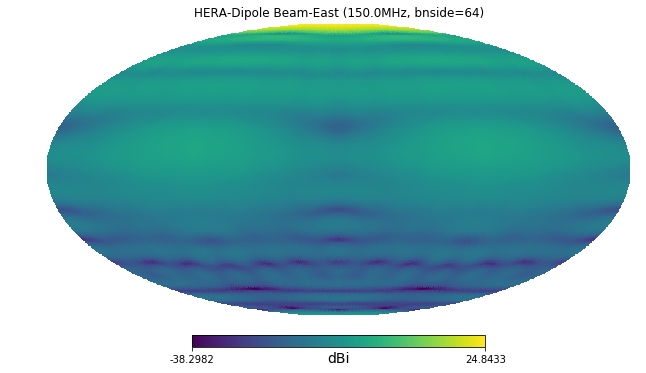

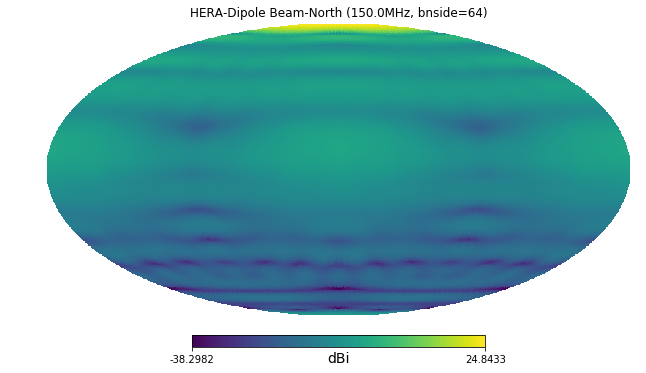

In [7]:

Plot_Beam = True
if Plot_Beam:
    plt.figure(0)
    #ind = np.where(beam_freqs == freq)[0][0]
    hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[0,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
            unit='dBi')
#     hp.mollview(10.0 * np.log10(beam_E[ind,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
#             unit='dBi')
    plt.savefig(script_dir + '/../Output/%s-dipole-Beam-east-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
    hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[1,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
            unit='dBi')
#     hp.mollview(10.0 * np.log10(beam_N[ind,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
#             unit='dBi')
    plt.savefig(script_dir + '/../Output/%s-dipole-Beam-north-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
    plt.show(block=False)
    #plt.gcf().clear()
        #plt.clf()
        #plt.close()



In [8]:
print local_beam_unpol(150)[0:]
print local_beam_unpol(150)[0:].sum()
print local_beam_unpol(150)[0:].min()
print local_beam_unpol(150)[0:].max()

[[317.35033648 317.36347034 317.36347034 ...   0.45564572   0.45564572
    0.4558748 ]
 [317.36347034 317.36347034 317.35033648 ...   0.45564572   0.4558748
    0.4558748 ]]
98426.09926039288
0.00014797059467877035
317.3634703353978


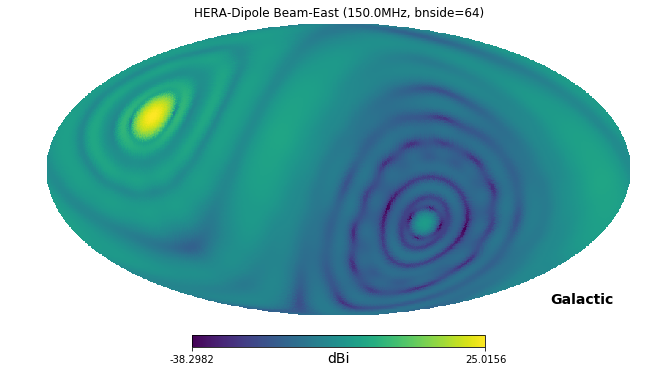

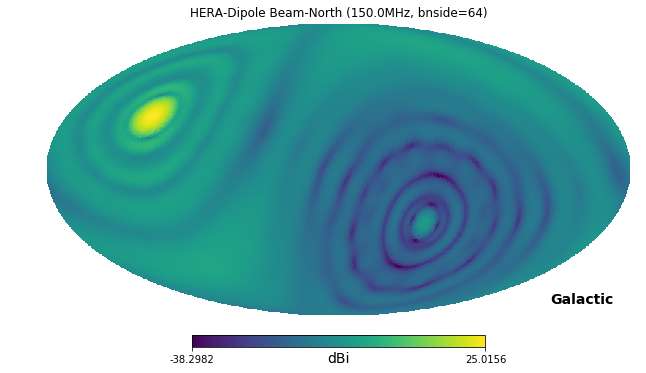

In [9]:
Plot_Beam = True
if Plot_Beam:
    plt.figure(0)
    #ind = np.where(beam_freqs == freq)[0][0]
    hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[0,:]), coord='CG', title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
            unit='dBi')
#     hp.mollview(10.0 * np.log10(beam_E[ind,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
#             unit='dBi')
    plt.savefig(script_dir + '/../Output/%s-dipole-Beam-east-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
    hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[1,:]), coord='CG', title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
            unit='dBi')
#     hp.mollview(10.0 * np.log10(beam_N[ind,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
#             unit='dBi')
    plt.savefig(script_dir + '/../Output/%s-dipole-Beam-north-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
    plt.show(block=False)
    #plt.gcf().clear()
        #plt.clf()
        #plt.close()


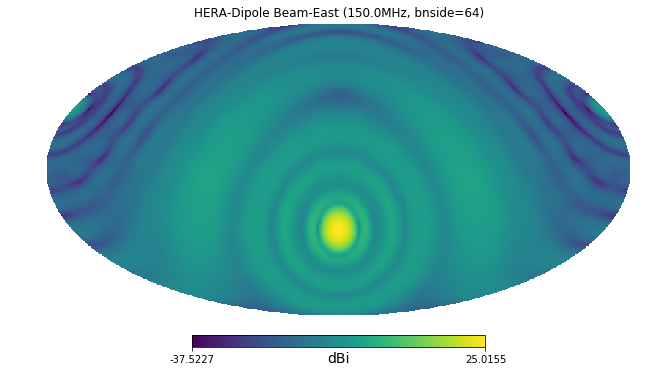

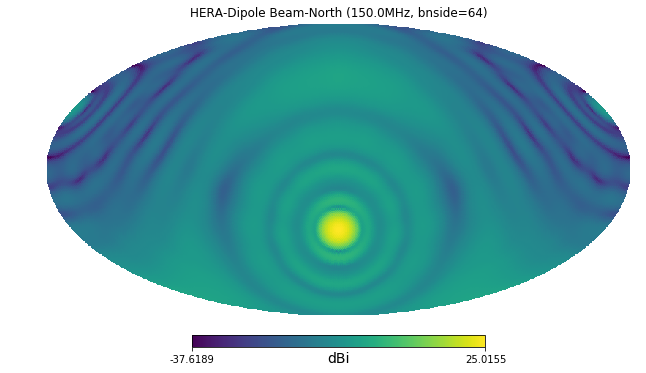

In [10]:
#################
####set up vs and beam
################
vs = sv.Visibility_Simulator()
vs.initial_zenith = np.array([0, lat_degree * PI / 180])  # self.zenithequ
beam_heal_hor_x = local_beam_unpol(freq)[0]
beam_heal_hor_y = local_beam_unpol(freq)[1]
beam_heal_equ_x = sv.rotate_healpixmap(beam_heal_hor_x, 0, PI / 2 - vs.initial_zenith[1], vs.initial_zenith[0])
beam_heal_equ_y = sv.rotate_healpixmap(beam_heal_hor_y, 0, PI / 2 - vs.initial_zenith[1], vs.initial_zenith[0])

if Absolute_Calibration_dred_mfreq:
	beam_heal_hor_x_mfreq = np.array([local_beam_unpol(flist[0][i])[0] for i in range(nf_used)])
	beam_heal_hor_y_mfreq = np.array([local_beam_unpol(flist[1][i])[1] for i in range(nf_used)])
	beam_heal_equ_x_mfreq = np.array([sv.rotate_healpixmap(beam_heal_hor_x_mfreq[i], 0, PI / 2 - vs.initial_zenith[1], vs.initial_zenith[0]) for i in range(nf_used)])
	beam_heal_equ_y_mfreq = np.array([sv.rotate_healpixmap(beam_heal_hor_y_mfreq[i], 0, PI / 2 - vs.initial_zenith[1], vs.initial_zenith[0]) for i in range(nf_used)])


Plot_Beam = True
if Plot_Beam:
	plt.figure(10)
	#ind = np.where(beam_freqs == freq)[0][0]
	hp.mollview(10.0 * np.log10(beam_heal_equ_x), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
			unit='dBi')
	plt.savefig(script_dir + '/../Output/%s-equ-dipole-Beam-east-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
	hp.mollview(10.0 * np.log10(beam_heal_equ_y), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
			unit='dBi')
	plt.savefig(script_dir + '/../Output/%s-equ-dipole-Beam-north-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
	plt.show(block=False)

sys.stdout.flush()

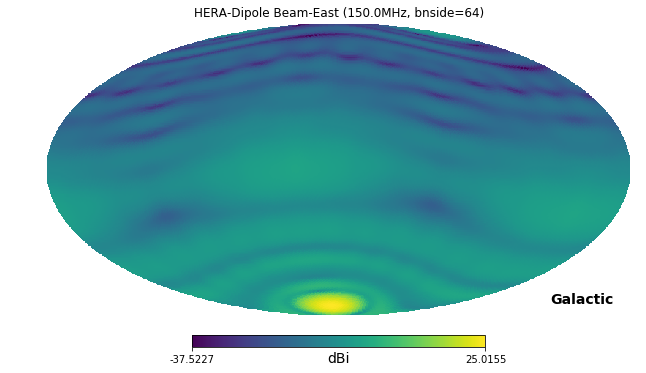

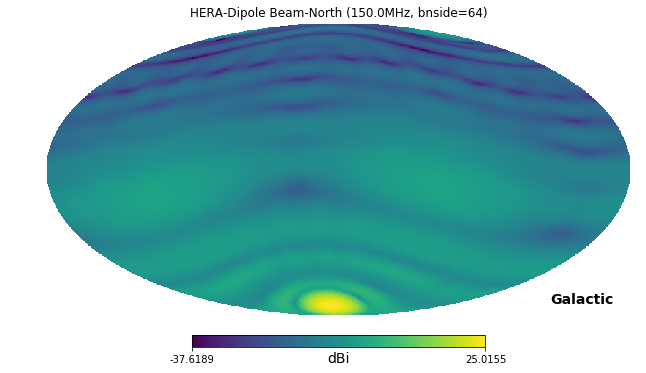

In [11]:
if Plot_Beam:
	plt.figure(0)
# 	ind = np.where(beam_freqs == freq)[0][0]
	hp.mollview(10.0 * np.log10(beam_heal_equ_x), coord='CG', title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
			unit='dBi')
	#plt.savefig(script_dir + '/../Output/%s-equ-dipole-Beam-east-CG-%.2f-bnside-%s.pdf'%(INSTRUMENT, beam_freqs[ind], bnside))
	hp.mollview(10.0 * np.log10(beam_heal_equ_y), coord='CG', title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
			unit='dBi')
	#plt.savefig(script_dir + '/../Output/%s-equ-dipole-Beam-north-CG-%.2f-bnside-%s.pdf'%(INSTRUMENT, beam_freqs[ind], bnside))
	plt.show(block=False)

In [12]:
########################### Delete some Input Data ##############################
Del=True
if Del:
	#del(data)
	#del(data_yy)
	try:
		#del(model)
		#del(model_yy)
		del(data_omni)
	except:
		pass

sys.stdout.flush()

In [13]:
######################
####initial A to compute beam weight
#####################
A_version = 1.0
A = {}
for p in ['x', 'y']:
	pol = p + p
	# ubl file
	#// ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl' % (p, p, nUBL, 3)
	#ubls = np.array([[0,0,0]])
	#//np.fromfile(ubl_filename, dtype='float32').reshape((nUBL, 3))
	print "%i UBLs to include, longest baseline is %i wavelengths for Pol: %s" % (len(ubls[p]), np.max(np.linalg.norm(ubls[p], axis=1)) / (C / freq), pol)
	print "%i Used-Common-UBLs to include, longest baseline is %i wavelengths for Pol: %s" % (len(used_common_ubls), np.max(np.linalg.norm(used_common_ubls, axis=1)) / (C / freq), pol)

	# beam
	if p == 'x':
		beam_heal_equ = beam_heal_equ_x
	elif p == 'y':
		beam_heal_equ = beam_heal_equ_x
	print "Computing sky weighting A matrix for %s pol..." % p
	sys.stdout.flush()

	A[p] = np.zeros((nt_used * len(used_common_ubls), 12 * nside_beamweight ** 2), dtype='complex128')

	timer = time.time()
	for i in np.arange(12 * nside_beamweight ** 2):
		dec, ra = hpf.pix2ang(nside_beamweight, i)  # gives theta phi
		dec = PI / 2 - dec
		print "\r%.1f%% completed" % (100. * float(i) / (12. * nside_beamweight ** 2)),
		sys.stdout.flush()
		if abs(dec - lat_degree * PI / 180) <= PI / 2:
			A[p][:, i] = vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts).flatten()

	print "%f minutes used" % (float(time.time() - timer) / 60.)
	sys.stdout.flush()
	

9 UBLs to include, longest baseline is 14 wavelengths for Pol: xx
9 Used-Common-UBLs to include, longest baseline is 14 wavelengths for Pol: xx
Computing sky weighting A matrix for x pol...
100.0% completed                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [14]:
####################################################
###beam weights using an equal pixel A matrix######
#################################################
print "Computing beam weight...",
sys.stdout.flush()
beam_weight = ((la.norm(A['x'], axis=0) ** 2 + la.norm(A['y'], axis=0) ** 2) ** .5)[hpf.nest2ring(nside_beamweight, range(12 * nside_beamweight ** 2))]
beam_weight = beam_weight / np.mean(beam_weight)
thetas_standard, phis_standard = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
beam_weight = hpf.get_interp_val(beam_weight, thetas_standard, phis_standard, nest=True) #np.array([beam_weight for i in range(nside_standard ** 2 / nside_beamweight ** 2)]).transpose().flatten()
print "done."
sys.stdout.flush()

Computing beam weight... done.


In [15]:
################################################
#####################GSM###########################
#############################################
pca1 = hp.fitsfunc.read_map(script_dir + '/../data/gsm1.fits' + str(nside_standard))
pca2 = hp.fitsfunc.read_map(script_dir + '/../data/gsm2.fits' + str(nside_standard))
pca3 = hp.fitsfunc.read_map(script_dir + '/../data/gsm3.fits' + str(nside_standard))
components = np.loadtxt(script_dir + '/../data/components.dat')
scale_loglog = si.interp1d(np.log(components[:, 0]), np.log(components[:, 1]))
w1 = si.interp1d(components[:, 0], components[:, 2])
w2 = si.interp1d(components[:, 0], components[:, 3])
w3 = si.interp1d(components[:, 0], components[:, 4])
gsm_standard = np.exp(scale_loglog(np.log(freq))) * (w1(freq) * pca1 + w2(freq) * pca2 + w3(freq) * pca3)
if Absolute_Calibration_dred_mfreq:
	gsm_standard_mfreq = np.array([np.exp(scale_loglog(np.log(flist[0][i]))) * (w1(flist[0][i]) * pca1 + w2(flist[0][i]) * pca2 + w3(flist[0][i]) * pca3) for i in range(nf_used)])

# rotate sky map and converts to nest
equatorial_GSM_standard = np.zeros(12 * nside_standard ** 2, 'float')
print "Rotating GSM_standard and converts to nest...",

if INSTRUMENT == 'miteor':
	DecimalYear = 2013.58 #2013, 7, 31, 16, 47, 59, 999998)
elif INSTRUMENT == 'hera47':
	DecimalYear = np.mean(Time(data_times[0], format='jd').decimalyear)
	JulianEpoch = np.mean(Time(data_times[0], format='jd').jyear)

sys.stdout.flush()
equ_to_gal_matrix = hp.rotator.Rotator(coord='cg').mat.dot(sv.epoch_transmatrix(2000, stdtime=JulianEpoch))
ang0, ang1 = hp.rotator.rotateDirection(equ_to_gal_matrix,
					hpf.pix2ang(nside_standard, range(12 * nside_standard ** 2), nest=True))
equatorial_GSM_standard = hpf.get_interp_val(gsm_standard, ang0, ang1)
if Absolute_Calibration_dred_mfreq:
	equatorial_GSM_standard_mfreq = np.array([hpf.get_interp_val(gsm_standard_mfreq[i], ang0, ang1) for i in range(nf_used)])
print "done."

Del=True
if Del:
	del(pca1)
	del(pca2)
	del(pca3)
	del(w1)
	del(w2)
	del(w3)
	del(components)
	del(scale_loglog)
	del(gsm_standard)
	try:
		del(gsm_standard_mfreq)
	except:
		pass
sys.stdout.flush()

NSIDE = 32
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 32
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 32
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Rotating GSM_standard and converts to nest... done.


In [16]:
#print A.shape

In [17]:
###########################################################
####simulate visibilities using non dynamic pixelization###
##########################################
full_sim_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
sim_vis_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_sim_xx.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
sim_vis_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_sim_yy.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
if simulation_opt == 1:
	
	if os.path.isfile(full_sim_filename):
		fullsim_vis = np.fromfile(full_sim_filename, dtype='complex128').reshape((2, nUBL_used+1, nt_used))
		fullsim_vis[0][:-1,:].astype('complex128').tofile(sim_vis_xx_filename)
		fullsim_vis[1][:-1,:].astype('complex128').tofile(sim_vis_yy_filename)
		
	else:

		fullsim_vis = np.zeros((2, nUBL_used + 1, nt_used), dtype='complex128')#since its going to accumulate along the pixels it needs to start with complex128. significant error if start with complex64
		full_sim_ubls = np.concatenate((used_common_ubls, [[0, 0, 0]]), axis=0)#tag along auto corr
		full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
		full_decs = PI / 2 - full_thetas
		full_ras = full_phis
		full_sim_mask = hpf.get_interp_val(beam_weight, full_thetas, full_phis, nest=True) > 0
		# fullsim_vis_DBG = np.zeros((2, len(used_common_ubls), nt_used, np.sum(full_sim_mask)), dtype='complex128')

		print "Simulating visibilities, %s, expected time %.1f min"%(datetime.datetime.now(), 14.6 * (nUBL_used / 78.) * (nt_used / 193.) * (np.sum(full_sim_mask) / 1.4e5)),
		sys.stdout.flush()
		masked_equ_GSM = equatorial_GSM_standard[full_sim_mask]
		timer = time.time()
		for p, beam_heal_equ in enumerate([beam_heal_equ_x, beam_heal_equ_y]):
			for i, (ra, dec) in enumerate(zip(full_ras[full_sim_mask], full_decs[full_sim_mask])):
				res = vs.calculate_pointsource_visibility(ra, dec, full_sim_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
				fullsim_vis[p] += masked_equ_GSM[i] * res
				# fullsim_vis_DBG[p, ..., i] = res[:-1]
				#autocorr = ~16*la.norm, ~80*np.std, ~1.e-5*np.corrrelate
		print "simulated visibilities in %.1f minutes."%((time.time() - timer) / 60.)
		fullsim_vis.astype('complex128').tofile(full_sim_filename)
		fullsim_vis[0][:-1,:].astype('complex128').tofile(sim_vis_xx_filename)
		fullsim_vis[1][:-1,:].astype('complex128').tofile(sim_vis_yy_filename)
		
	autocorr_vis = np.abs(fullsim_vis[:, -1])
	if crosstalk_type == 'autocorr':
		autocorr_vis_normalized = np.array([autocorr_vis[p] / (la.norm(autocorr_vis[p]) / la.norm(np.ones_like(autocorr_vis[p]))) for p in range(2)])
	else:
		autocorr_vis_normalized = np.ones((2, nt_used))
	fullsim_vis = fullsim_vis[:, :-1].transpose((1, 0, 2))


In [18]:
print autocorr_vis.mean()
print fullsim_vis.mean()

1227565.6587779154
(1556.6106039729052-329.7816353772341j)


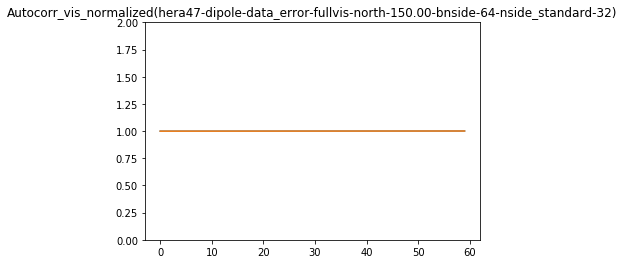

In [19]:
if plot_data_error:
	#plt.clf()
	plt.figure(30)
	plt.plot(autocorr_vis_normalized.transpose())
	plt.title('Autocorr_vis_normalized(%s-dipole-data_error-fullvis-north-%.2f-bnside-%s-nside_standard-%s)'%(INSTRUMENT, freq, bnside, nside_standard))
	plt.ylim([0, 2])
	plt.savefig(script_dir + '/../Output/%s-dipole-data_error-fullvis-north-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
	plt.show(block=False)
	#plt.gcf().clear()
	#plt.clf()
	#plt.close()
sys.stdout.flush()


In [20]:
######################################### Absolute Calibration on Omnicaled Data #############################################
if Absolute_Calibration_red:
	full_redabs_sim_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_redabs.simvis'%(INSTRUMENT, freq, nBL_red_used+1, nt_used, nside_standard, bnside)
	redabs_sim_vis_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_redabs_sim_xx.simvis'%(INSTRUMENT, freq, nBL_red_used+1, nt_used, nside_standard, bnside)
	redabs_sim_vis_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_redabs_sim_yy.simvis'%(INSTRUMENT, freq, nBL_red_used+1, nt_used, nside_standard, bnside)
		
	if os.path.isfile(full_redabs_sim_filename):
		fullsim_vis_red = np.fromfile(full_redabs_sim_filename, dtype='complex128').reshape((2, nBL_red_used+1, nt_used))
		fullsim_vis_red[0][:-1,:].astype('complex128').tofile(redabs_sim_vis_xx_filename)
		fullsim_vis_red[1][:-1,:].astype('complex128').tofile(redabs_sim_vis_yy_filename)
		
	else:

		fullsim_vis_red = np.zeros((2, nBL_red_used + 1, nt_used), dtype='complex128')#since its going to accumulate along the pixels it needs to start with complex128. significant error if start with complex64
		full_sim_bls_red = np.concatenate((used_common_bls_red, [[0, 0, 0]]), axis=0)#tag along auto corr
		full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
		full_decs = PI / 2 - full_thetas
		full_ras = full_phis
		full_sim_mask = hpf.get_interp_val(beam_weight, full_thetas, full_phis, nest=True) > 0
		# fullsim_vis_DBG = np.zeros((2, len(used_common_ubls), nt_used, np.sum(full_sim_mask)), dtype='complex128')

		print "Simulating redundant visibilities, %s, expected time %.1f min"%(datetime.datetime.now(), 14.6 * (nBL_red_used / 78.) * (nt_used / 193.) * (np.sum(full_sim_mask) / 1.4e5)),
		sys.stdout.flush()
		masked_equ_GSM = equatorial_GSM_standard[full_sim_mask]
		timer = time.time()
		for p, beam_heal_equ in enumerate([beam_heal_equ_x, beam_heal_equ_y]):
			for i, (ra, dec) in enumerate(zip(full_ras[full_sim_mask], full_decs[full_sim_mask])):
				res_red = vs.calculate_pointsource_visibility(ra, dec, full_sim_bls_red, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
				fullsim_vis_red[p] += masked_equ_GSM[i] * res_red
				# fullsim_vis_DBG[p, ..., i] = res[:-1]
				#autocorr = ~16*la.norm, ~80*np.std, ~1.e-5*np.corrrelate
		print "simulated redundant visibilities in %.1f minutes."%((time.time() - timer) / 60.)
		fullsim_vis_red.astype('complex128').tofile(full_redabs_sim_filename)
		fullsim_vis_red[0][:-1,:].astype('complex128').tofile(redabs_sim_vis_xx_filename)
		fullsim_vis_red[1][:-1,:].astype('complex128').tofile(redabs_sim_vis_yy_filename)
		
	autocorr_vis_red = np.abs(fullsim_vis_red[:, -1])
	if crosstalk_type == 'autocorr':
		autocorr_vis_red_normalized = np.array([autocorr_vis_red[p] / (la.norm(autocorr_vis_red[p]) / la.norm(np.ones_like(autocorr_vis_red[p]))) for p in range(2)])
	else:
		autocorr_vis_red_normalized = np.ones((2, nt_used))
	fullsim_vis_red = fullsim_vis_red[:, :-1].transpose((1, 0, 2)) 

	if plot_data_error:
		#plt.clf()
		plt.figure(3000000)
		plt.plot(autocorr_vis_red_normalized.transpose())
		plt.title('Autocorr_vis_normalized(%s-dipole-data_error-fullvis_red-north-%.2f-bnside-%s-nside_standard-%s)'%(INSTRUMENT, freq, bnside, nside_standard))
		plt.ylim([0, 2])
		plt.savefig(script_dir + '/../Output/%s-dipole-data_error-fullvis_red-north-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		plt.show(block=False)
		#plt.gcf().clear()
		#plt.clf()
		#plt.close()
	sys.stdout.flush()


In [21]:
if Absolute_Calibration_dred_mfreq: # Used 9.4 min. 64*9*60*12280
	full_sim_filename_mfreq = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_mfreq%s-%s-%s.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[0]))
	sim_vis_xx_filename_mfreq = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_sim_xx_mfreq%s-%s-%s.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[0]))
	sim_vis_yy_filename_mfreq = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_sim_yy_mfreq%s-%s-%s.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[1]))
	if simulation_opt == 1:
		
		if os.path.isfile(full_sim_filename_mfreq):
			fullsim_vis_mfreq = np.fromfile(full_sim_filename_mfreq, dtype='complex128').reshape((2, nUBL_used+1, nt_used, nf_used))
			fullsim_vis_mfreq[0][:-1].astype('complex128').tofile(sim_vis_xx_filename_mfreq)
			fullsim_vis_mfreq[1][:-1].astype('complex128').tofile(sim_vis_yy_filename_mfreq)
			
		else:

			fullsim_vis_mfreq = np.zeros((2, nUBL_used + 1, nt_used, nf_used), dtype='complex128')#since its going to accumulate along the pixels it needs to start with complex128. significant error if start with complex64
			full_sim_ubls = np.concatenate((used_common_ubls, [[0, 0, 0]]), axis=0)#tag along auto corr
			full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
			full_decs = PI / 2 - full_thetas
			full_ras = full_phis
			full_sim_mask = hpf.get_interp_val(beam_weight, full_thetas, full_phis, nest=True) > 0
			# fullsim_vis_DBG = np.zeros((2, len(used_common_ubls), nt_used, np.sum(full_sim_mask)), dtype='complex128')

			print "Simulating visibilities, %s, expected time %.1f min"%(datetime.datetime.now(), 14.6 * nf_used * (nUBL_used / 78.) * (nt_used / 193.) * (np.sum(full_sim_mask) / 1.4e5)),
			sys.stdout.flush()
			masked_equ_GSM_mfreq = equatorial_GSM_standard_mfreq[:, full_sim_mask]
			timer = time.time()
			for id_f, f in enumerate(flist[0]):
				for p, beam_heal_equ in enumerate([beam_heal_equ_x_mfreq[id_f], beam_heal_equ_y_mfreq[id_f]]):
					for i, (ra, dec) in enumerate(zip(full_ras[full_sim_mask], full_decs[full_sim_mask])):
						res = vs.calculate_pointsource_visibility(ra, dec, full_sim_ubls, f, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
						fullsim_vis_mfreq[p, :, :, id_f] += masked_equ_GSM_mfreq[id_f, i] * res
						# fullsim_vis_DBG[p, ..., i] = res[:-1]
						#autocorr = ~16*la.norm, ~80*np.std, ~1.e-5*np.corrrelate
			print "simulated visibilities in %.1f minutes."%((time.time() - timer) / 60.)
			fullsim_vis_mfreq.astype('complex128').tofile(full_sim_filename_mfreq)
			fullsim_vis_mfreq[0][:-1, :, :].astype('complex128').tofile(sim_vis_xx_filename_mfreq)
			fullsim_vis_mfreq[1][:-1, :, :].astype('complex128').tofile(sim_vis_yy_filename_mfreq)
			
		autocorr_vis_mfreq = np.abs(fullsim_vis_mfreq[:, -1])
#		if crosstalk_type == 'autocorr':
#			autocorr_vis_normalized = np.array([autocorr_vis[p] / (la.norm(autocorr_vis[p]) / la.norm(np.ones_like(autocorr_vis[p]))) for p in range(2)])
#		else:
#			autocorr_vis_normalized = np.ones((2, nt_used))
		fullsim_vis_mfreq = fullsim_vis_mfreq[:, :-1].transpose((1, 0, 2, 3)) # (uBL, Pol, Times, Freqs)


In [22]:
if not Model_Calibration: #and Absolute_Calibration is True:
#		model_fname1 = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.xx.HH.uv'
#		model_fname2 = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.xx.HH.uv'
#		model_fname1_yy = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.yy.HH.uv'
#		model_fname2_yy = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.yy.HH.uv'
#		(model, mflags, antpos, ants, model_freqs, model_times, model_lsts,
#		 model_pols) = hc.abscal.UVData2AbsCalDict(model_fname1, return_meta=True) # also can try model_fname2
#		(model_yy, mflags_yy, antpos_yy, ants_yy, model_freqs_yy, model_times_yy, model_lsts_yy,
#		 model_pols_yy) = hc.abscal.UVData2AbsCalDict(model_fname2, return_meta=True) # also can try model_fname2
	
#		data_fname_omni = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
#		(data_omni, dflags_omni, antpos_omni, ants_omni, data_freqs_omni, data_times_omni, data_lsts_omni, 
#		 data_pols_omni) = hc.abscal.UVData2AbsCalDict(data_fname_omni, return_meta=True)
	
	#model_list = {}
	#model = {}
	model_sf = {}
	model_dred = {}
	model_dred_mfreq = {}
	data = {}
	data_sf = {}
	data_dred = {}
	data_dred_mfreq = {}
	data_dred_mfreq_pscal = {}
	interp_flags_dred_mfreq ={}
	interp_flags_dred_mfreq_pscal ={}
	AC = {}
	AC_sf = {}
	AC_dred = {}
	AC_dred_mfreq = {}
	AC_dred_mfreq_pscal = {}
	freq_to_cal = [freq]
	fulldflags = {}
	auto_select_dred_mfreq = {}
	auto_select_dred_mfreq_pscal = {}
	
#	try:
#		cdata = copy.deepcopy(data)
#	except:
#		pass
	
	try:
		cdflags_sf = copy.deepcopy(dflags_sf)
	except:
		pass
		
	try:
		cdflags_dred = copy.deepcopy(dflags_dred)
	except:
		pass
	
	try:
		cdflags = copy.deepcopy(dflags)
	except:
		pass
	
	try:
		cdflags_dred_mfreq = copy.deepcopy(dflags_dred_mfreq)
	except:
		pass
		
	#cwgts = copy.deepcopy(wgts)
	#cwgts_dred = copy.deepcopy(wgts_dred)
	
	bl_select = 0
	bl = dflags.keys()[bl_select] #dflags and dflags_yy #[(24, 53, 'xx')
	fig = {}
	axes = {}
	fig_data = {}
	axes_data = {}
	
	bl_dred_select = 0
	bl_dred = dflags_dred[0].keys()[bl_dred_select] #if Absolute_Calibration_dred else None #[(25, 37, 'xx')
	fig2 = {}
	axes2 = {}
	fig2_data = {}
	axes2_data = {}
	
	bl_dred_mfreq_select = 8
	bl_dred_mfreq = [dflags_dred_mfreq[0].keys()[bl_dred_mfreq_select], dflags_dred_mfreq[1].keys()[bl_dred_mfreq_select]]  #[(25, 37, 'xx'), (25, 37, 'yy')]
	fig3 = {}
	axes3 = {}
	fig3_data = {}
	axes3_data = {}
	fig3_data_abscorr = {} 
	axes3_data_abscorr = {}
	
	bl_dred_mfreq_pscal_select = 8
	bl_dred_mfreq_pscal = [dflags_dred_mfreq[0].keys()[bl_dred_mfreq_pscal_select], dflags_dred_mfreq[1].keys()[bl_dred_mfreq_pscal_select]]  #[(25, 37, 'xx'), (25, 37, 'yy')]
	fig4 = {}
	axes4 = {}
	fig4_data = {}
	axes4_data = {}
	fig4_data_abscorr = {} 
	axes4_data_abscorr = {}
	
	delay_corr_data = {}
	delay_corr_data_sf = {}
	delay_corr_data_dred = {}
	delay_corr_data_dred_mfreq = {}
	delay_corr_data_dred_mfreq_pscal = {}
	DAC = {}
	DAC_sf = {}
	DAC_dred = {}
	DAC_dred_mfreq = {}
	DAC_dred_mfreq_pscal = {}
	dly_phs_corr_data = {}
	dly_phs_corr_data_sf = {}
	dly_phs_corr_data_dred = {}
	dly_phs_corr_data_dred_mfreq = {}
	dly_phs_corr_data_dred_mfreq_pscal = {}
	DPAC = {}
	DPAC_sf = {}
	DPAC_dred = {}
	DPAC_dred_mfreq = {}
	DPAC_dred_mfreq_pscal = {}
	abs_corr_data = {}
	abs_corr_data_sf = {}
	abs_corr_data_dred = {}
	abs_corr_data_dred_mfreq = {}
	abs_corr_data_dred_mfreq_pscal = {}
	
	vis_data_dred_mfreq_abscal = [[], []]
	vis_data_dred_mfreq_pscal_abscal = [[], []]
	autocorr_data_dred_mfreq_abscal = [[], []]
	autocorr_data_dred_mfreq_pscal_abscal = [[], []]
	vis_data_dred_abscal = [[], []]
	vis_data_dred_pscal_abscal = [[], []]
	autocorr_data_dred_abscal = [[], []]
	autocorr_data_dred_pscal_abscal = [[], []]
	
	add_Autobsl = False # Whether we add (0,0,0) to calculate autocorr or not.
	
#		model = (copy.deepcopy(data)).astype('complex128')
#		model_yy = copy.deepcopy(data_yy).astype('complex128')
	for i in range(2):
		model_sf[i] = LastUpdatedOrderedDict()
		model_sf[i] = LastUpdatedOrderedDict()
		model_dred[i] = LastUpdatedOrderedDict()
		model_dred_mfreq[i] = LastUpdatedOrderedDict()
		#data[i] = LastUpdatedOrderedDict()
		data_sf[i] = LastUpdatedOrderedDict()
		data_dred[i] = LastUpdatedOrderedDict()
		data_dred_mfreq[i] = LastUpdatedOrderedDict()
		pol = ['xx', 'yy'][i]
		
		#fulldflags[i] = hc.abscal.UVData2AbsCalDict(data_fname_full[i], return_meta=True)[1] # assume autocorr no RFI flagged.
		
		if Absolute_Calibration_red:
			keys = dflags_sf[i].keys() # if i == 0 else dflags_yy.keys()
			for key_index, key in enumerate(keys):
				model_sf[i][key] = fullsim_vis_red[key_index, i, :]
				data_sf[i][key] = vis_data[i][:, key_index]
			model_sf[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_vis_red[i] # not lose generality, choose the autocorrelation of first antenna in the first UBL as visibility in last line for autocorrelation calibraiton.
			data_sf[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_data[i]
			cdflags_sf[i][keys[0][0], keys[0][0], keys[0][2]] = np.array([False]*len(autocorr_data[i]))
			print(keys)
			print(keys[0][0])
			
				
		if Absolute_Calibration_dred:
			for key_index_dred, key_dred in enumerate(dflags_dred[i].keys()):
				model_dred[i][key_dred] = fullsim_vis[key_index_dred, i, :]
				data_dred[i][key_dred] = vis_data_dred[i][:, key_index_dred]
			model_dred[i][dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][2]] = autocorr_vis[i] # not lose generality, choose the first anntena in the first UBL for autocorrelation calibraiton.
			data_dred[i][dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][2]] = autocorr_data[i] # add the autocorrelation of first antenna in the first UBL as the last line in visibility.
			cdflags_dred[i][dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][2]] = np.array([False]*len(autocorr_data[i]))
			print(dflags_dred[i].keys())
			print(dflags_dred[i].keys()[0][0])
			
		
#		if Absolute_Calibration_dred_mfreq:
#			keys = dflags_dred_mfreq[i].keys()
#			for key_index, key in enumerate(keys):
#				model[i][key] = fullsim_vis_mfreq[key_index_dred, i]
#				#data_dred_mfreq[i][key] = vis_data_dred_mfreq[i][:, :, key_index].transpose() #[pol][freq,time,ubl_index].transpose()
#			model[i][dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][2]] = autocorr_vis_mfreq[i] # not lose generality, choose the first anntena in the first UBL for autocorrelation calibraiton.
#			cdata[i][dflags[i].keys()[0][0], dflags[i].keys()[0][0], dflags[i].keys()[0][2]] = autocorr_data_mfreq[i] # add the autocorrelation of first antenna in the first UBL as the last line in visibility.
#			cdflags[i][keys[0][0], keys[0][0], keys[0][2]] = np.array([[False]*autocorr_data_mfreq[i].shape[1]]*autocorr_data_mfreq[i].shape[0])
#			print(dflags[i].keys())
#			print(dflags[i].keys()[0][0])
#			
							
		if Absolute_Calibration_dred_mfreq:
			keys = dflags_dred_mfreq[i].keys()
			for key_index, key in enumerate(keys):
				model_dred_mfreq[i][key] = fullsim_vis_mfreq[key_index, i]
				#data_dred_mfreq[i][key] = np.real(vis_data_dred_mfreq[i][:, :, key_index].transpose()) + np.abs(np.imag(vis_data_dred_mfreq[i][:, :, key_index].transpose()))*1j #[pol][freq,time,ubl_index].transpose()
				data_dred_mfreq[i][key] = vis_data_dred_mfreq[i][:, :, key_index].transpose() #[pol][freq,time,ubl_index].transpose()
			if add_Autobsl:
				model_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_vis_mfreq[i] # not lose generality, choose the first anntena in the first UBL for autocorrelation calibraiton.
				data_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_data_mfreq[i] # add the autocorrelation of first antenna in the first UBL as the last line in visibility.
				cdflags_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = np.array([[False]*autocorr_data_mfreq[i].shape[1]]*autocorr_data_mfreq[i].shape[0])
				auto_select_dred_mfreq[i] = (keys[0][0], keys[0][0], keys[0][2])
			print(dflags_dred_mfreq[i].keys())
			print(dflags_dred_mfreq[i].keys()[0][0])
			
			
	###### make wgts #######	
	for i in range(2):
		if i == 0:
			wgts_sf = copy.deepcopy(cdflags_sf)
		for k in wgts_sf[i].keys():
			wgts_sf[i][k] = (~wgts_sf[i][k]).astype(np.float)
		
		if i == 0:
			wgts_dred = copy.deepcopy(cdflags_dred)
		for k in wgts_dred[i].keys():
			wgts_dred[i][k] = (~wgts_dred[i][k]).astype(np.float)
			
#		if i == 0:
#			wgts = copy.deepcopy(cdflags)
#		for k in wgts[i].keys():
#			wgts[i][k] = (~wgts[i][k]).astype(np.float)
				
		if i == 0:
			wgts_dred_mfreq = copy.deepcopy(cdflags_dred_mfreq)
		for k in wgts_dred_mfreq[i].keys():
			wgts_dred_mfreq[i][k] = (~wgts_dred_mfreq[i][k]).astype(np.float)
			
			
re_cal_times = 1


[(25, 37, 'xx'), (25, 52, 'xx'), (24, 52, 'xx'), (37, 39, 'xx'), (24, 39, 'xx'), (24, 53, 'xx'), (24, 25, 'xx'), (24, 38, 'xx'), (24, 37, 'xx')]
25
[(25, 37, 'yy'), (25, 52, 'yy'), (24, 52, 'yy'), (37, 39, 'yy'), (24, 39, 'yy'), (24, 53, 'yy'), (24, 25, 'yy'), (24, 38, 'yy'), (24, 37, 'yy')]
25


In [23]:
for i in range(2):
	pol = ['xx', 'yy'][i]
	re_cal = 0
	
	if Absolute_Calibration_dred_mfreq:
		for re_cal in range(re_cal_times): # number of times of absolute calibration
			if re_cal == 0:
				model_dred_mfreq[i], interp_flags_dred_mfreq[i] = hc.abscal.interp2d_vis(model_dred_mfreq[i], lsts, flist[i], lsts, flist[i])
				# instantiate class
				AC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
				# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
				AC_dred_mfreq[i].delay_lincal(kernel=(1, 11), medfilt=True, time_avg=True, solve_offsets=True)
			else:
				#model_dred_mfreq[i], interp_flags_dred_mfreq[i] = hc.abscal.interp2d_vis(model_dred_mfreq[i], lsts, flist[i], lsts, flist[i])
				# instantiate class
				AC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], abs_corr_data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
				# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
				AC_dred_mfreq[i].delay_lincal(kernel=(1, 3), medfilt=True, time_avg=True, solve_offsets=True)
			# apply to data
			delay_corr_data_dred_mfreq[i] = hc.abscal.apply_gains(AC_dred_mfreq[i].data, (AC_dred_mfreq[i].ant_dly_gain))
			# instantiate class
			DAC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], delay_corr_data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
			# avg phase solver
			DAC_dred_mfreq[i].phs_logcal(avg=True)
			# apply to data
			dly_phs_corr_data_dred_mfreq[i] = hc.abscal.apply_gains(DAC_dred_mfreq[i].data, (DAC_dred_mfreq[i].ant_phi_gain))
			# instantiate class
			DPAC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], dly_phs_corr_data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
			# run amp linsolve
			DPAC_dred_mfreq[i].abs_amp_logcal()
			# run phs linsolve
			DPAC_dred_mfreq[i].TT_phs_logcal(zero_psi=False, four_pol=False)
			# apply to data
			abs_corr_data_dred_mfreq[i] = hc.abscal.apply_gains(DPAC_dred_mfreq[i].data, 
									(DPAC_dred_mfreq[i].abs_psi_gain, DPAC_dred_mfreq[i].TT_Phi_gain, DPAC_dred_mfreq[i].abs_eta_gain), gain_convention='multiply')
								
		vis_data_dred_mfreq_abscal[i] = np.zeros_like(vis_data_dred_mfreq[i], dtype='complex128')
		for key_id, key in enumerate(dflags_dred_mfreq[i].keys()):
			vis_data_dred_mfreq_abscal[i][:, :, key_id] = abs_corr_data_dred_mfreq[i][key].transpose()
			#vis_data_dred_mfreq_abscal[i][:, :, key_id] = np.real(abs_corr_data_dred_mfreq[i][key].transpose()) + np.abs(np.imag(abs_corr_data_dred_mfreq[i][key].transpose()))*1j
		if add_Autobsl:
			autocorr_data_dred_mfreq_abscal[i] = abs_corr_data_dred_mfreq[i][auto_select_dred_mfreq[i]]
		else:
			autocorr_data_dred_mfreq_abscal[i] = autocorr_vis_mfreq[i]
			
		vis_data_dred_abscal[i] = vis_data_dred_mfreq_abscal[i][index_freq[i], :, :]
		if add_Autobsl: 
			autocorr_data_dred_abscal[i] = autocorr_data_dred_mfreq_abscal[i][:, index_freq[i]]
		else:
			autocorr_data_dred_abscal[i] = autocorr_vis_mfreq[i][:, index_freq[i]]
		

...configuring linsolve data for delay_lincal
...running linsolve
...finished linsolve
...running linsolve
...finished linsolve
...configuring linsolve data for phs_logcal
...running linsolve


divide by zero encountered in divide
divide by zero encountered in divide


...finished linsolve
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for TT_phs_logcal
...running linsolve


divide by zero encountered in divide
divide by zero encountered in divide


...finished linsolve
...configuring linsolve data for delay_lincal
...running linsolve
...finished linsolve
...running linsolve
...finished linsolve
...configuring linsolve data for phs_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve


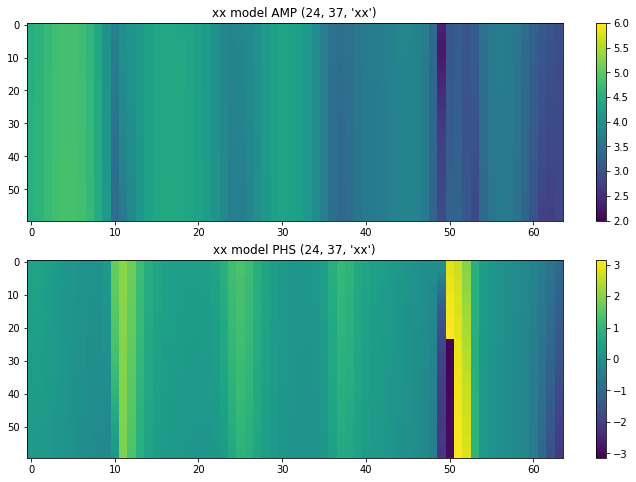

divide by zero encountered in log10


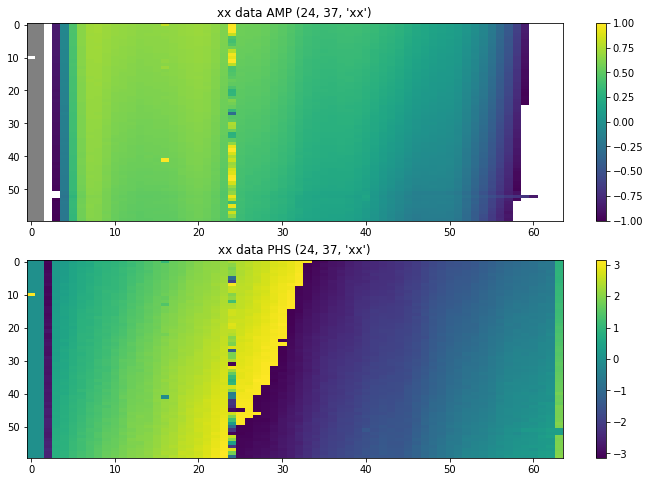

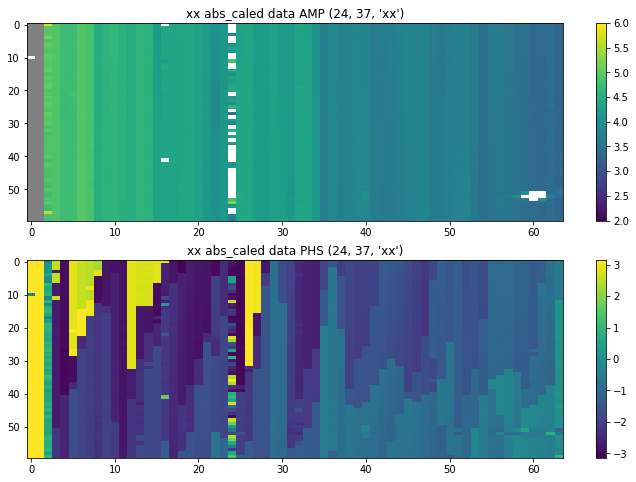

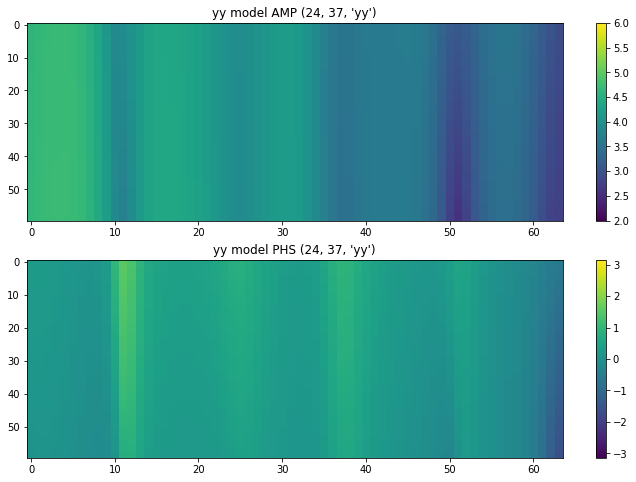

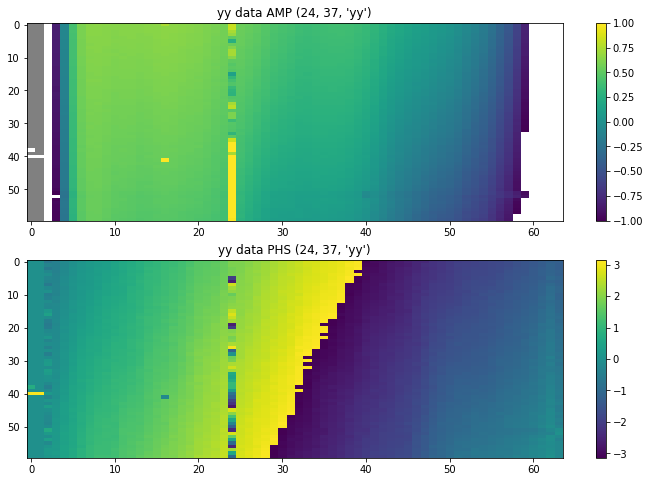

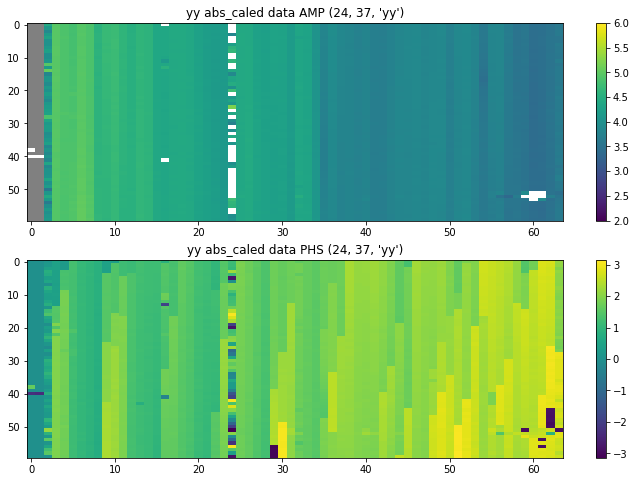

In [24]:
for i in range(2):
	pol = ['xx', 'yy'][i]
	
	if Absolute_Calibration_dred_mfreq:								
		plt.figure(80000000+10*i)
		fig3[i], axes3[i] = plt.subplots(2, 1, figsize=(12, 8))
		plt.sca(axes3[i][0])
		uvt.plot.waterfall(AC_dred_mfreq[i].model[bl_dred_mfreq[i]], mode='log', mx=6, drng=4)
		plt.colorbar()
		plt.title(pol + ' model AMP {}'.format(bl_dred_mfreq[i]))
		plt.sca(axes3[i][1])
		uvt.plot.waterfall(AC_dred_mfreq[i].model[bl_dred_mfreq[i]], mode='phs', mx=np.pi, drng=2*np.pi)
		plt.colorbar()
		plt.title(pol + ' model PHS {}'.format(bl_dred_mfreq[i]))
		plt.show(block=False)			
		#plt.cla()
			
		plt.figure(90000000+10*i)
		fig3_data[i], axes3_data[i] = plt.subplots(2, 1, figsize=(12, 8))
		plt.sca(axes3_data[i][0])
		uvt.plot.waterfall(data_dred_mfreq[i][bl_dred_mfreq[i]], mode='log', mx=1, drng=2)
		plt.colorbar()
		plt.title(pol + ' data AMP {}'.format(bl_dred_mfreq[i]))
		plt.sca(axes3_data[i][1])
		uvt.plot.waterfall(data_dred_mfreq[i][bl_dred_mfreq[i]], mode='phs', mx=np.pi, drng=2*np.pi)
		plt.colorbar()
		plt.title(pol + ' data PHS {}'.format(bl_dred_mfreq[i]))
		plt.show(block=False)
		#plt.cla()		
			
		####################### after ABS Calibration #########################	
		plt.figure(8000000+10*i)
		fig3_data_abscorr[i], axes3_data_abscorr[i] = plt.subplots(2, 1, figsize=(12, 8))
		plt.sca(axes3_data_abscorr[i][0])
		uvt.plot.waterfall(abs_corr_data_dred_mfreq[i][bl_dred_mfreq[i]], mode='log', mx=6, drng=4)
		plt.colorbar()
		plt.title(pol + ' abs_caled data AMP {}'.format(bl_dred_mfreq[i]))
		plt.sca(axes3_data_abscorr[i][1])
		uvt.plot.waterfall(abs_corr_data_dred_mfreq[i][bl_dred_mfreq[i]], mode='phs', mx=np.pi, drng=2*np.pi)
		plt.colorbar()
		plt.title(pol + ' abs_caled data PHS {}'.format(bl_dred_mfreq[i]))
		plt.show(block=False)
		#plt.cla()


In [25]:
for i in range(2):	
	if Absolute_Calibration_dred:
		# instantiate class
		#AC_dred[i] = hc.abscal.AbsCal(model_dred[i], data_dred[i], antpos=antpos[i], wgts=wgts_dred[i], freqs=freq_to_cal)
		# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
		AC_dred[i].delay_lincal(kernel=(1, 3), medfilt=True, time_avg=True, solve_offsets=True)
		# apply to data
		delay_corr_data_dred[i] = hc.abscal.apply_gains(AC_dred[i].data, (AC_dred[i].ant_dly_gain))
		# instantiate class
		DAC_dred[i] = hc.abscal.AbsCal(model_dred[i], data_dred[i], antpos=antpos[i], wgts=wgts_dred[i], freqs=freq_to_cal)
		# avg phase solver
		DAC_dred[i].phs_logcal(avg=True)
		# apply to data
		dly_phs_corr_data_dred[i] = hc.abscal.apply_gains(DAC_dred[i].data, (DAC_dred[i].ant_phi_gain))
		# instantiate class
		DPAC_dred[i] = hc.abscal.AbsCal(model_dred[i], dly_phs_corr_data_dred[i], antpos=antpos[i], wgts=wgts_dred[i], freqs=freq_to_cal)
		# run amp linsolve
		DPAC_dred[i].abs_amp_logcal()
		# run phs linsolve
		DPAC_dred[i].TT_phs_logcal(zero_psi=False, four_pol=False)
		# apply to data
		abs_corr_data_dred[i] = hc.abscal.apply_gains(DPAC_dred[i].data, 
								(DPAC_dred[i].abs_psi_gain, DPAC_dred[i].TT_Phi_gain, DPAC_dred[i].abs_eta_gain), gain_convention='multiply')
		
		
		plt.figure(60000000+10*i)
		fig2[i], axes2[i] = plt.subplots(2, 1, figsize=(12, 8))
		if len(freq_to_cal) >= 2:
			plt.sca(axes2[i][0])
			uvt.plot.waterfall(AC_dred[i].model[bl_dred], mode='log', mx=4, drng=2)
			plt.colorbar()
			plt.title(pol + ' model AMP {}'.format(bl_dred))
			plt.sca(axes2[i][1])
			uvt.plot.waterfall(AC_dred[i].model[bl_dred], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' model PHS {}'.format(bl_dred))
			plt.show(block=False)			
		else:
			plt.sca(axes2[i][0])
			plt.plot(np.real(AC_dred[i].model[bl_dred]))
			plt.title(pol + ' model Real {}'.format(bl_dred))
			plt.sca(axes2[i][1])
			plt.plot(np.imag(AC_dred[i].model[bl_dred]))
			plt.title(pol + ' model Imag {}'.format(bl_dred))
			plt.show(block=False)
		#plt.cla()
			
		plt.figure(70000000+10*i)
		fig2_data[i], axes2_data[i] = plt.subplots(2, 1, figsize=(12, 8))
		if len(freq_to_cal) >= 2:
			plt.sca(axes2_data[i][0])
			uvt.plot.waterfall(AC_dred[i].data[bl_dred], mode='log', mx=4, drng=2)
			plt.colorbar()
			plt.title(pol + ' data AMP {}'.format(bl_dred))
			plt.sca(axes2_data[i][1])
			uvt.plot.waterfall(AC_dred[i].data[bl_dred], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' data PHS {}'.format(bl_dred))
			plt.show(block=False)
		else:
			plt.sca(axes2_data[i][0])
			plt.plot(np.real(AC_dred[i].data[bl_dred]))
			plt.title(pol + ' data Real {}'.format(bl_dred))
			plt.sca(axes2_data[i][1])
			plt.plot(np.imag(AC_dred[i].data[bl_dred]))
			plt.title(pol + ' data Imag {}'.format(bl_dred))
			plt.show(block=False)
		#plt.cla()
			
			
		####################### after ABS Calibration #########################	
		plt.figure(7000000+10*i)
		fig2_data[i], axes2_data[i] = plt.subplots(2, 1, figsize=(12, 8))
		if len(freq_to_cal) >= 2:
			plt.sca(axes2_data[i][0])
			uvt.plot.waterfall(abs_corr_data_dred[i][bl_dred], mode='log', mx=4, drng=2)
			plt.colorbar()
			plt.title(pol + ' data AMP {}'.format(bl_dred))
			plt.sca(axes2_data[i][1])
			uvt.plot.waterfall(abs_corr_data_dred[i][bl_dred], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' data PHS {}'.format(bl_dred))
			plt.show(block=False)
		else:
			plt.sca(axes2_data[i][0])
			plt.plot(np.real(abs_corr_data_dred[i][bl_dred]))
			plt.title(pol + ' data Real {}'.format(bl_dred))
			plt.sca(axes2_data[i][1])
			plt.plot(np.imag(abs_corr_data_dred[i][bl_dred]))
			plt.title(pol + ' data Imag {}'.format(bl_dred))
			plt.show(block=False)
		#plt.cla()


In [26]:
################# Noise and Vis Data Loading ##################
if len(tlist) >= 2:
	Time_seperation_real = np.array([3600.*np.abs(tlist[i+1]-tlist[i]) for i in range(len(tlist)-1)]) # in second
elif INSTRUMENT == 'hera47':
	 Time_seperation_real = 11
elif INSTRUMENT == 'miteor':
	Time_seperation_real = 144
Frequency_gap_real = np.array([1.e6*np.abs(flist[0][i+1]-flist[0][i]) for i in range(len(flist[0])-1)]) # Hz

Integration_Time = np.mean(Time_seperation_real)
Frequency_Bin = np.mean(Frequency_gap_real)

Calculate_SimulationData_Noise = True
Calculate_Data_Noise = True

scale_noise = True
#Use_AbsCal = False

noise = {}
noise_data = {}
if Calculate_SimulationData_Noise:
	if Keep_Red:	
		noise['x'] = np.array([np.random.normal(0, autocorr_vis_red[0][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) for t_index in range(len(autocorr_vis[0]))],dtype='complex128').flatten()
		noise['y'] = np.array([np.random.normal(0, autocorr_vis_red[1][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) for t_index in range(len(autocorr_vis[1]))],dtype='complex128').flatten()
	else:
		noise['x'] = np.array([(np.random.normal(0, autocorr_vis[0][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) / np.array(redundancy[0])**0.5) for t_index in range(len(autocorr_vis[0]))],dtype='complex128').flatten()
		noise['y'] = np.array([(np.random.normal(0, autocorr_vis[1][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) / np.array(redundancy[1])**0.5) for t_index in range(len(autocorr_vis[1]))],dtype='complex128').flatten()
	
#	N_acu = {}
#	N_acu['x'] = np.outer(noise['x'], noise['x'].T)
#	N_acu['y'] = np.outer(noise['y'], noise['y'].T)
	N = {}
	N['x'] = noise['x'] * noise['x']
	N['y'] = noise['y'] * noise['y']
	
	sim_var_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_sim_xx.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
	sim_var_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_sim_yy.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
	N['x'].astype('complex128').tofile(sim_var_xx_filename)
	N['y'].astype('complex128').tofile(sim_var_yy_filename)
	
	Del = True
	if Del:
		del(noise)
		del(N)

if Calculate_Data_Noise:
	if INSTRUMENT == 'miteor':
		noise_data['x'] = (var_data[0].flatten())**0.5
		noise_data['y'] = (var_data[1].flatten())**0.5
		
	elif INSTRUMENT == 'hera47':
		if Keep_Red:
			noise_data['x'] = np.array([np.random.normal(0,autocorr_data[0][t_index]/(Integration_Time*Frequency_Bin)**0.5,nUBL_used) for t_index in range(len(autocorr_data[0]))],dtype='complex128').flatten() # Not Absolute Calibrated
			noise_data['y'] = np.array([np.random.normal(0,autocorr_data[1][t_index]/(Integration_Time*Frequency_Bin)**0.5,nUBL_used) for t_index in range(len(autocorr_data[1]))],dtype='complex128').flatten()
		else:
			if scale_noise:
				if Use_AbsCal:
					noise_data['x'] = np.array([(np.random.normal(0, autocorr_data_dred_abscal[0][t_index]/(Integration_Time*Frequency_Bin) **0.5, nUBL_used) / np.array(redundancy[0])**0.5) for t_index in range(len(autocorr_data_dred_abscal[0]))],dtype='complex128').flatten() # Absolute Calibrated
					noise_data['y'] = np.array([(np.random.normal(0, autocorr_data_dred_abscal[1][t_index]/(Integration_Time*Frequency_Bin) **0.5, nUBL_used) / np.array(redundancy[1])**0.5) for t_index in range(len(autocorr_data_dred_abscal[1]))],dtype='complex128').flatten()
				else:
					noise_data['x'] = np.array([(np.random.normal(0, autocorr_data[0][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) / np.array(redundancy[0])**0.5) for t_index in range(len(autocorr_data[0]))],dtype='complex128').flatten() # Absolute Calibrated
					noise_data['y'] = np.array([(np.random.normal(0, autocorr_data[1][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) / np.array(redundancy[1])**0.5) for t_index in range(len(autocorr_data[1]))],dtype='complex128').flatten()
			else:
				if Use_AbsCal:
					noise_data['x'] = np.array([(np.random.normal(0, autocorr_data_dred_abscal[0][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) ) for t_index in range(len(autocorr_data_dred_abscal[0]))],dtype='complex128').flatten() # Absolute Calibrated
					noise_data['y'] = np.array([(np.random.normal(0, autocorr_data_dred_abscal[1][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) ) for t_index in range(len(autocorr_data_dred_abscal[1]))],dtype='complex128').flatten()
				else:
					noise_data['x'] = np.array([(np.random.normal(0, autocorr_data[0][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) ) for t_index in range(len(autocorr_data[0]))],dtype='complex128').flatten() # Absolute Calibrated
					noise_data['y'] = np.array([(np.random.normal(0, autocorr_data[1][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) ) for t_index in range(len(autocorr_data[1]))],dtype='complex128').flatten()
						
#	N_data_acu = {}
#	N_data_acu['x'] = np.outer(noise_data['x'], noise_data['x'].T)
#	N_data_acu['y'] = np.outer(noise_data['y'], noise_data['y'].T)
	N_data = {}
	N_data['x'] = noise_data['x'] * noise_data['x']
	N_data['y'] = noise_data['y'] * noise_data['y']
	
	Store_Data_Noise = True

	if Store_Data_Noise:
		data_var_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_data_xx.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
		data_var_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_data_yy.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
		N_data['x'].astype('complex128').tofile(data_var_xx_filename)
		N_data['y'].astype('complex128').tofile(data_var_yy_filename)
	
	Del = True
	if Del:
		del(noise_data)
		#del(N_data)
#		try:
#			del(autocorr_data)
#		except:
#			pass

sys.stdout.flush()


In [27]:
######################
####simulate cas and cyg
#######################
southern_points = {'hyd':{'ra': '09:18:05.7', 'dec': '-12:05:44'},
'cen':{'ra': '13:25:27.6', 'dec': '-43:01:09'},
'cyg':{'ra': '19:59:28.3', 'dec': '40:44:02'},
'pic':{'ra': '05:19:49.7', 'dec': '-45:46:44'},
'vir':{'ra': '12:30:49.4', 'dec': '12:23:28'},
'for':{'ra': '03:22:41.7', 'dec': '-37:12:30'},
'sag':{'ra': '17:45:40.045', 'dec': '-29:0:27.9'},
'cas':{'ra': '23:23:26', 'dec': '58:48:00'},
'crab':{'ra': '5:34:31.97', 'dec': '22:00:52.1'}}


for source in southern_points.keys():
	southern_points[source]['body'] = ephem.FixedBody()
	southern_points[source]['body']._ra = southern_points[source]['ra']
	southern_points[source]['body']._dec = southern_points[source]['dec']

flux_func = {}
#flux_func['cas'] = si.interp1d(np.loadtxt('/home/omniscope/data/point_source_flux/casA2013.5out')[:,1], np.loadtxt('/home/omniscope/data/point_source_flux/casA2013.5out')[:,2])
#flux_func['cyg'] = si.interp1d(np.loadtxt('/home/omniscope/data/point_source_flux/cygA2006out')[:,1], np.loadtxt('/home/omniscope/data/point_source_flux/cygA2006out')[:,2])
flux_func['cas'] = si.interp1d(flist[0], np.array([S_casa_v_t(flist[0][i], DecimalYear) for i in range(len(flist[0]))]))
flux_func['cyg'] = si.interp1d(flist[0], np.array([S_cyga_v(flist[0][i], DecimalYear) for i in range(len(flist[0]))]))


pt_sources = ['cyg', 'cas']
pt_vis = np.zeros((len(pt_sources), 2, nUBL_used, nt_used), dtype='complex128')
if INSTRUMENT == 'miteor':
	print "Simulating cyg casvisibilities, %s, expected time %.1f min"%(datetime.datetime.now(), 14.6 * (nUBL_used / 78.) * (nt_used / 193.) * (2. / 1.4e5)),
	sys.stdout.flush()
	timer = time.time()
	for p, beam_heal_equ in enumerate([beam_heal_equ_x, beam_heal_equ_y]):
		for i, source in enumerate(pt_sources):
			ra = southern_points[source]['body']._ra
			dec = southern_points[source]['body']._dec
			pt_vis[i, p] = jansky2kelvin * flux_func[source](freq) * vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
elif INSTRUMENT == 'hera47':
	print "Simulating cyg casvisibilities, %s, expected time %.1f min"%(datetime.datetime.now(), 14.6 * (nUBL_used / 78.) * (nt_used / 193.) * (2. / 1.4e5)),
	sys.stdout.flush()
	timer = time.time()
	for p, beam_heal_equ in enumerate([beam_heal_equ_x, beam_heal_equ_y]):
		for i, source in enumerate(pt_sources):
			ra = southern_points[source]['body']._ra
			dec = southern_points[source]['body']._dec
			pt_vis[i, p] = jansky2kelvin * flux_func[source](freq) * vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2



if PointSource_AbsCal:
	vis_freq = {}
	
	autocorr_data_dred_mfreq_pscal = {}
	vis_data_dred_mfreq_pscal = {}
	
	for j, p in enumerate(['x', 'y']):
		pol = p+p
		vis_data_dred_mfreq_pscal[j] = np.zeros_like(vis_data_dred_mfreq_abscal[j])
		autocorr_data_dred_mfreq_pscal[j] = np.zeros_like(autocorr_data_dred_mfreq_abscal[j])
	
	for id_f in range(len(flist[0])):
		vis_freq[0] = flist[0][id_f]
		vis_freq[1] = flist[1][id_f]
		cal_lst_range = np.array([5, 6]) / TPI * 24.
		calibrate_ubl_length = 1600 / np.mean([vis_freq[0], vis_freq[1]]) #10.67
		cal_time_mask = tmask	 #(tlist>cal_lst_range[0]) & (tlist<cal_lst_range[1])#a True/False mask on all good data to get good data in cal time range
		#cal_ubl_mask = {}
		
		
		Ni = {}
		cubls = copy.deepcopy(ubls)
		ubl_sort = {}
		noise_data_pscal = {}
		N_data_pscal = {}
		vis_data_dred_pscal = {}
		
		From_AbsCal = False
		
		for i, p in enumerate(['x', 'y']):
			pol = p+p
			cal_ubl_mask = np.linalg.norm(ubls[p], axis=1) >= calibrate_ubl_length
			#get Ni (1/variance) and data
			#var_filename = datadir + tag + '_%s%s_%i_%i%s.var'%(p, p, nt, nUBL, vartag)
			#noise_data_pscal['y'] = np.array([(np.random.normal(0,autocorr_data[1][t_index]/(Integration_Time*Frequency_Bin)**0.5,nUBL_used) ) for t_index in range(len(autocorr_data[1]))],dtype='complex128').flatten()
			
			if From_AbsCal:
				vis_data_dred_pscal[i] = vis_data_dred_mfreq_abscal[i][id_f][np.ix_(cal_time_mask, cal_ubl_mask)].transpose()
				noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data_dred_mfreq_abscal[i][t_index, id_f]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data[i]))],dtype='complex128').flatten() # Absolute Calibrated
			else:
				vis_data_dred_pscal[i] = vis_data_dred_mfreq[i][id_f][np.ix_(cal_time_mask, cal_ubl_mask)].transpose()
				noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data_mfreq[i][t_index, id_f]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data[i]))],dtype='complex128').flatten() # Absolute Calibrated
				
			N_data_pscal[p] = noise_data_pscal[p] * noise_data_pscal[p]
			#N_data_pscal['y'] = noise_data_pscal['y'] * noise_data_pscal['y']
			Ni[p] = 1./N_data_pscal[p].reshape((nt, nUBL))[np.ix_(cal_time_mask, cal_ubl_mask)].transpose()
			ubls[p] = ubls[p][cal_ubl_mask]
			ubl_sort[p] = np.argsort(la.norm(ubls[p], axis=1))

			print "%i UBLs to include"%len(ubls[p])
		
		del(noise_data_pscal)
		
		print "Computing UNpolarized point sources matrix..."
		sys.stdout.flush()
		cal_sources = ['cyg', 'cas']
		Apol = np.empty((np.sum(cal_ubl_mask), 2, np.sum(cal_time_mask), len(cal_sources)), dtype='complex128')
		timer = time.time()
		for n, source in enumerate(cal_sources):
			ra = southern_points[source]['body']._ra
			dec = southern_points[source]['body']._dec

			Apol[:, 0, :, n] = vs.calculate_pointsource_visibility(ra, dec, ubls[p], vis_freq[0], beam_heal_equ=beam_heal_equ_x_mfreq[id_f], tlist=lsts[cal_time_mask])
			Apol[:, 1, :, n] = vs.calculate_pointsource_visibility(ra, dec, ubls[p], vis_freq[1], beam_heal_equ=beam_heal_equ_y_mfreq[id_f], tlist=lsts[cal_time_mask])

		Apol = np.conjugate(Apol).reshape((np.sum(cal_ubl_mask), 2 * np.sum(cal_time_mask), len(cal_sources)))
		Ni = np.transpose([Ni['x'], Ni['y']], (1, 0, 2))

		realA = np.zeros((2 * Apol.shape[0] * Apol.shape[1], 1 + 2 * np.sum(cal_ubl_mask) * 2), dtype='complex128')
		realA[:, 0] = np.concatenate((np.real(Apol.reshape((Apol.shape[0] * Apol.shape[1], Apol.shape[2]))), np.imag(Apol.reshape((Apol.shape[0] * Apol.shape[1], Apol.shape[2])))), axis=0).dot([jansky2kelvin_mfreq[0][id_f] * flux_func[source](vis_freq[0]) for source in cal_sources])
		vis_scale = la.norm(realA[:, 0]) / len(realA)**.5
		for coli, ncol in enumerate(range(1, realA.shape[1])):
			realA[coli * np.sum(cal_time_mask): (coli + 1) * np.sum(cal_time_mask), ncol] = vis_scale

		realNi = np.concatenate((Ni.flatten() * 2, Ni.flatten() * 2))
		realAtNiAinv = np.linalg.pinv(np.einsum('ji,j,jk->ik', realA, realNi, realA))


		b = np.transpose([vis_data_dred_pscal[0], vis_data_dred_pscal[1]], (1, 0, 2))
		phase_degen_niter = 0
		phase_degen2 = {'x': np.zeros(2), 'y': np.zeros(2)}
		phase_degen_iterative_x = np.zeros(2)
		phase_degen_iterative_y = np.zeros(2)
		def tocomplex(realdata):
			reshapedata = realdata.reshape((2, np.sum(cal_ubl_mask), 2, np.sum(cal_time_mask)))
			return reshapedata[0] + reshapedata[1] * 1.j

		phase_degen_niter_max = 100
		while (phase_degen_niter < phase_degen_niter_max and max(np.linalg.norm(phase_degen_iterative_x), np.linalg.norm(phase_degen_iterative_y)) > 1e-5) or phase_degen_niter == 0:
			phase_degen_niter += 1
			b[:, 0] = b[:, 0] * np.exp(1.j * ubls['x'][:, :2].dot(phase_degen_iterative_x))[:, None]
			b[:, -1] = b[:, -1] * np.exp(1.j * ubls['y'][:, :2].dot(phase_degen_iterative_y))[:, None]
			realb = np.concatenate((np.real(b.flatten()), np.imag(b.flatten())))

			psol = realAtNiAinv.dot(np.transpose(realA).dot(realNi * realb))
			realb_fit = realA.dot(psol)
			perror = ((realb_fit - realb) * (realNi**.5)).reshape((2, np.sum(cal_ubl_mask), 2, np.sum(cal_time_mask)))

			realbfit_noadditive = realA[:, 0] * psol[0]
			realbfit_additive = realb_fit - realbfit_noadditive
			realb_noadditive = realb - realbfit_additive
			bfit_noadditive = tocomplex(realbfit_noadditive)
			b_noadditive = tocomplex(realb_noadditive)
			if phase_degen_niter == phase_degen_niter_max:
				phase_degen_iterative_x = solve_phase_degen(np.transpose(b_noadditive[:, 0]), np.transpose(b_noadditive[:, 0]), np.transpose(bfit_noadditive[:, 0]), np.transpose(bfit_noadditive[:, 0]), ubls['x'])#, [3, 3, 1e3])
				phase_degen_iterative_y = solve_phase_degen(np.transpose(b_noadditive[:, -1]), np.transpose(b_noadditive[:, -1]), np.transpose(bfit_noadditive[:, -1]), np.transpose(bfit_noadditive[:, -1]), ubls['y'])#, [3, 3, 1e3])

			else:
				phase_degen_iterative_x = solve_phase_degen(np.transpose(b_noadditive[:, 0]), np.transpose(b_noadditive[:, 0]), np.transpose(bfit_noadditive[:, 0]), np.transpose(bfit_noadditive[:, 0]), ubls['x'])
				phase_degen_iterative_y = solve_phase_degen(np.transpose(b_noadditive[:, -1]), np.transpose(b_noadditive[:, -1]), np.transpose(bfit_noadditive[:, -1]), np.transpose(bfit_noadditive[:, -1]), ubls['y'])
			phase_degen2['x'] += phase_degen_iterative_x
			phase_degen2['y'] += phase_degen_iterative_y
			print phase_degen_niter, phase_degen2['x'], phase_degen2['y'], np.linalg.norm(perror)

		renorm = 1 / (2 * psol[0])

		print (renorm, vis_freq[0],  phase_degen2['x'], vis_freq[1], phase_degen2['y'])

		#freqs[fi] = vis_freq

		################################# apply to data and var and output unpolarized version ####################################
		data_var_xx_filename_pscal = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_data_xx_pscal.simvis'%(INSTRUMENT, freq, nUBL, nt, nside_standard, bnside)
		data_var_yy_filename_pscal = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_data_yy_pscal.simvis'%(INSTRUMENT, freq, nUBL, nt, nside_standard, bnside)
		
		#vis_data_dred_pscal = {}
		#N_data_pscal = {}
		
		######### recover ubls and ubl_sort ##########
		ubls = cubls
		#ubl_sort = cubl_sort
		
		if Keep_Red:
			nUBL = len(bsl_coord_x)
			for p in ['x', 'y']:
				#ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl' % (p, p, nUBL, 3)
				ubls[p] = globals()['bsl_coord_' + p]
			common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
			
		else:
			nUBL = len(bsl_coord_dred[0])
			nUBL_yy = len(bsl_coord_dred[1])
			for i in range(2):
				p = ['x', 'y'][i]
				ubls[p] = bsl_coord_dred[i]
			common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
		
		#get data and var and apply change
		
		for j, p in enumerate(['x', 'y']):
			pol = p+p

			if From_AbsCal:
				vis_data_dred_mfreq_pscal[j][id_f] = vis_data_dred_mfreq_abscal[j][id_f] * np.exp(1.j * ubls[p][:, :2].dot(phase_degen2[p])) * renorm
				if comply_ps2mod_autocorr:
					autocorr_data_dred_mfreq_pscal[j][:, id_f] = autocorr_vis_mfreq[j][:, id_f]
				else:
					autocorr_data_dred_mfreq_pscal[j][:, id_f] = autocorr_data_dred_mfreq_abscal[j][:, id_f] * np.abs(renorm)  # Absolute Calibrated
			else:
				vis_data_dred_mfreq_pscal[j][id_f] = vis_data_dred_mfreq[j][id_f] * np.exp(1.j * ubls[p][:, :2].dot(phase_degen2[p])) * renorm
				if comply_ps2mod_autocorr:
					autocorr_data_dred_mfreq_pscal[j][:, id_f] = autocorr_vis_mfreq[j][:, id_f]
				else:
					autocorr_data_dred_mfreq_pscal[j][:, id_f] = autocorr_data_mfreq[j][:, id_f] * np.abs(renorm) # Absolute Calibrated
		
		
	noise_data_pscal = {}
	N_data_pscal = {}
	vis_data_dred_pscal = {}
	for i, p in enumerate(['x', 'y']):
		pol = p+p
#		data_filename = glob.glob(datadir + tag + '_%s%s_*_*'%(p, p) + datatag)[0]
#		nt_nUBL = os.path.basename(data_filename).split(datatag)[0].split('%s%s_'%(p, p))[-1]
#		nt = int(nt_nUBL.split('_')[0])
#		nUBL = int(nt_nUBL.split('_')[1])
#		var_filename = datadir + tag + '_%s%s_%i_%i%s.var'%(p, p, nt, nUBL, vartag)
#
#		op_data_filename = datadir + tag + '_%s%s_%i_%i%s'%(p, p, nt, nUBL, dataoptag)
#		op_var_filename = datadir + tag + '_%s%s_%i_%i%s.var'%(p, p, nt, nUBL, varoptag)
#		op_var100_filename = datadir + tag + '_%s%s_%i_%i%s.var'%(p, p, nt, nUBL, varoptag+'x100')

		#ubl file
		#ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl'%(p, p, nUBL, 3)
		#ubls = np.fromfile(ubl_filename, dtype='float32').reshape((nUBL, 3))
		
#		if From_AbsCal:
#			vis_data_dred_pscal[i] = vis_data_dred_abscal[i] * np.exp(1.j * ubls[p][:, :2].dot(phase_degen2[p])) * renorm
#			noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data_dred_abscal[i][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data[i]))],dtype='complex128').flatten() # Absolute Calibrated
#		else:
#			vis_data_dred_pscal[i] = vis_data_dred[i] * np.exp(1.j * ubls[p][:, :2].dot(phase_degen2[p])) * renorm
#			noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data[i][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data[i]))],dtype='complex128').flatten() # Absolute Calibrated
		
		vis_data_dred_pscal[i] = vis_data_dred_mfreq_pscal[i][index_freq[i]]
		noise_data_pscal[p] = np.array([(np.random.normal(0, autocorr_data_dred_mfreq_pscal[i][t_index, index_freq[i]]/ (Integration_Time*Frequency_Bin)**0.5, nUBL)/ np.array(redundancy[i])**0.5 ) for t_index in range(len(autocorr_data_dred_mfreq_pscal[i]))],dtype='complex128').flatten() # Absolute Calibrated
		
#		if From_AbsCal:
#			vis_data_dred_pscal[i] = vis_data_dred_mfreq_pscal[i][index_freq[i]]
#			noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data_dred_mfreq_pscal[i][t_index, index_freq[i]]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data_dred_mfreq_pscal[i]))],dtype='complex128').flatten() # Absolute Calibrated
#		else:
#			vis_data_dred_pscal[i] = vis_data_dred_mfreq_pscal[i][index_freq[i]]
#			noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data_dred_mfreq_pscal[i][t_index, index_freq[i]]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data_dred_mfreq_pscal[i]))],dtype='complex128').flatten() # Absolute Calibrated
					
		N_data_pscal[p] = noise_data_pscal[p] * noise_data_pscal[p]
		N_data_pscal[p] = N_data_pscal[p].reshape((nt, nUBL))
		
		#save
#		if os.path.isfile(op_data_filename) and not overwrite:
#			raise IOError(op_data_filename + ' exists.')
#		else:
#			new_data.astype('complex128').tofile(op_data_filename)

		N_data_pscal[p].astype('complex128').tofile(globals()['data_var_' + pol + '_filename_pscal'])
		#(new_var * 100.).astype('float32').tofile(op_var100_filename)
	del(noise_data_pscal)


Simulating cyg casvisibilities, 2018-03-08 17:27:47.429065, expected time 0.0 min 6 UBLs to include
6 UBLs to include
Computing UNpolarized point sources matrix...
1 [ 0.00037487 -0.00048558] [-0.000331    0.01015719] 0.775627400195051
2 [ 0.00074973 -0.00097117] [-0.00065781  0.02149595] 0.7756315829650245
3 [ 0.0011246  -0.00145675] [-0.0009764   0.03363315] 0.7756474737083667
4 [ 0.00149946 -0.00194233] [-0.00127993  0.04635857] 0.775671942259991
5 [ 0.00187433 -0.00242791] [-0.00155188  0.05963544] 0.775696368202322
6 [ 0.00224919 -0.0029135 ] [-0.00157477  0.07359856] 0.7757102113200613
7 [ 0.00262406 -0.00339908] [-0.18581438 -0.05413423] 0.7757055470534827
8 [ 0.00299892 -0.00388466] [0.05858251 0.06404498] 0.775710785171367
9 [ 0.00337379 -0.00437025] [-0.12542047 -0.05915374] 0.7757016837806938
10 [ 0.00374866 -0.00485583] [-0.12525826 -0.04751972] 0.7757070091919738
11 [ 0.00412352 -0.00534141] [-0.12383129 -0.03538447] 0.7757105728597451
12 [ 0.00449839 -0.00582699] [0.11988

13 [ 0.0077163  -0.01518874] [-0.05407837  0.02390588] 0.3763153734316994
14 [ 0.00830986 -0.0163571 ] [-0.05833949  0.02614282] 0.3763154025578365
15 [ 0.00890342 -0.01752547] [-0.06260619  0.02834872] 0.3763154315829265
16 [ 0.00949698 -0.01869383] [-0.06687478  0.03052425] 0.376315460190555
17 [ 0.01009054 -0.0198622 ] [-0.0711417   0.03267002] 0.3763154881020062
18 [ 0.0106841  -0.02103056] [-0.07540353  0.03478655] 0.3763155150750908
19 [ 0.01127766 -0.02219893] [-0.07965697  0.03687427] 0.3763155409026056
20 [ 0.01187122 -0.02336729] [-0.08389883  0.03893355] 0.3763155654105227
21 [ 0.01246478 -0.02453566] [-0.08812603  0.04096466] 0.3763155884559866
22 [ 0.01305835 -0.02570402] [-0.09233559  0.0429678 ] 0.3763156099251758
23 [ 0.01365191 -0.02687239] [-0.09652462  0.04494309] 0.3763156297310809
24 [ 0.01424547 -0.02804075] [-0.10069033  0.04689058] 0.3763156478112349
25 [ 0.01483903 -0.02920912] [-0.10483003  0.04881025] 0.3763156641254298
26 [ 0.01543259 -0.03037748] [-0.108941

23 [-0.02876403  0.00282507] [0.02862729 0.02356572] 453.48067138460004
24 [-0.03002666  0.00302009] [0.02985801 0.02461117] 451.1918205016924
25 [-0.03129312  0.00322655] [0.03108753 0.02565508] 448.93458254095276
26 [-0.032565    0.00344692] [0.03231588 0.02669734] 446.7163050927981
27 [-0.03384228  0.00368095] [0.03354295 0.027738  ] 444.5390383270155
28 [-0.0351204   0.00392055] [0.03476776 0.02877874] 442.41423597087294
29 [-0.03639871  0.00416439] [0.03599001 0.02982005] 440.374685555021
30 [-0.0376809   0.00441937] [0.03720981 0.03085471] 438.43190751351545
31 [-0.03896492  0.00468169] [0.03842725 0.03188144] 436.5780225737997
32 [-0.04024677  0.00494411] [0.03964239 0.03290027] 434.83235461291554
33 [-0.04152436  0.00520267] [0.04085533 0.03391128] 433.2185470263382
34 [-0.0428052   0.00546982] [0.04206609 0.03491454] 431.74890442081335
35 [-0.04408855  0.00574177] [0.04327457 0.03591021] 430.4054193743561
36 [-0.04537194  0.00601344] [0.04448085 0.03689834] 429.2019932360252
3

37 [ 0.00997742 -0.04501214] [0.04082752 0.00717341] 20098.716566756913
38 [ 0.01016416 -0.04590171] [0.0412555  0.00743659] 20089.858726924205
39 [ 0.01033802 -0.04677644] [0.04167265 0.00769821] 20082.240748302203
40 [ 0.01048303 -0.04762692] [0.04207735 0.00795815] 20075.63119590376
41 [ 0.01061751 -0.04846279] [0.04247334 0.00821632] 20070.279626654712
42 [ 0.0107311  -0.04927602] [0.04286172 0.00847265] 20065.702420488495
43 [ 0.01082547 -0.05006739] [0.04323949 0.00872707] 20061.92599534324
44 [ 0.0109022  -0.05083765] [0.04360637 0.00897949] 20059.048536010956
45 [ 0.01096275 -0.05158754] [0.04396394 0.00922983] 20057.02849601977
46 [ 0.01101778 -0.05232339] [0.04431404 0.00947797] 20055.73525538652
47 [ 0.0110587  -0.05304062] [0.04465881 0.00972343] 20054.92536586558
48 [ 0.01109764 -0.05374609] [0.04499895 0.00996619] 20054.5553648594
49 [ 0.0111402  -0.05444307] [0.0453343  0.01020629] 20054.436330909506
50 [ 0.01118611 -0.05513163] [0.04566543 0.01044372] 20054.503191846743

49 [-0.05259336 -0.03880975] [-0.00368123 -0.06830893] 18493.91721974614
50 [-0.05328865 -0.03936664] [-0.00411035 -0.0694452 ] 18521.621688330597
51 [-0.05397945 -0.03991666] [-0.00454083 -0.0705743 ] 18548.55513193703
52 [-0.05467572 -0.04046077] [-0.00497465 -0.07169622] 18575.213131785138
53 [-0.05537247 -0.0409945 ] [-0.0054116  -0.07281093] 18601.81791527161
54 [-0.05605802 -0.04151449] [-0.00585103 -0.07391831] 18628.219737473464
55 [-0.05672767 -0.0420215 ] [-0.00629153 -0.07501812] 18654.12861907605
56 [-0.05738457 -0.0425209 ] [-0.00673306 -0.07611366] 18679.441428728183
57 [-0.05802533 -0.04300663] [-0.00717503 -0.07720605] 18704.27798148649
58 [-0.05864892 -0.04347671] [-0.00761578 -0.07829517] 18728.558348291965
59 [-0.05925528 -0.04393086] [-0.00805435 -0.07938189] 18752.26396361362
60 [-0.05986214 -0.04437932] [-0.00849161 -0.08046839] 18775.41182322402
61 [-0.06048884 -0.0448335 ] [-0.00892731 -0.08155458] 18798.42947466264
62 [-0.0611435  -0.04529991] [-0.00936148 -0.0

59 [-0.03452951 -0.05531223] [-0.03936785 -0.06349239] 55390.27885824447
60 [-0.03511692 -0.05615862] [-0.04006021 -0.06451711] 55362.85085149622
61 [-0.03570409 -0.05700115] [-0.04074459 -0.06553561] 55335.62955334945
62 [-0.03629038 -0.05784031] [-0.04142081 -0.06654777] 55308.60369594134
63 [-0.03687482 -0.05867673] [-0.04208868 -0.06755353] 55282.04254345862
64 [-0.03745745 -0.0595105 ] [-0.04274803 -0.06855281] 55256.34112492508
65 [-0.03803794 -0.06034167] [-0.04339872 -0.06954556] 55231.49362337981
66 [-0.03861625 -0.0611703 ] [-0.04404062 -0.07053174] 55207.600632295726
67 [-0.03919244 -0.06199648] [-0.0446736  -0.07151132] 55184.67766066201
68 [-0.03976652 -0.06282025] [-0.04529758 -0.07248427] 55162.71704729218
69 [-0.04033856 -0.06364171] [-0.04591246 -0.07345058] 55141.71021781227
70 [-0.04090859 -0.0644609 ] [-0.04651816 -0.07441024] 55121.647758102925
71 [-0.04147688 -0.06527777] [-0.04711464 -0.07536325] 55102.51953564509
72 [-0.04204503 -0.0660915 ] [-0.04770183 -0.0763

74 [ 0.00483592 -0.00520404] [ 0.06164221 -0.00942463] 20901.197239780377
75 [ 0.00408435 -0.00568729] [ 0.06286418 -0.01015151] 20881.501342633022
76 [ 0.0032509  -0.00616787] [ 0.06411013 -0.01090925] 20864.04613694648
77 [ 0.00242041 -0.00661937] [ 0.06552359 -0.01177711] 20850.688432153613
78 [ 0.0016433  -0.00707639] [ 0.06705283 -0.01272869] 20834.688732888375
79 [ 0.00087572 -0.00753766] [ 0.06868236 -0.01375835] 20815.956992521802
80 [ 0.00014983 -0.00800385] [ 0.0703884  -0.01485249] 20797.344595649865
81 [-0.0005616  -0.00847677] [ 0.07206031 -0.01594875] 20778.921891000064
82 [-0.00121276 -0.00895792] [ 0.07369899 -0.01704592] 20764.71776596639
83 [-0.00179622 -0.00944129] [ 0.07530354 -0.0181431 ] 20752.79241213688
84 [-0.0023391  -0.00991675] [ 0.07688714 -0.01923125] 20742.81443993939
85 [-0.00286957 -0.01038668] [ 0.07847509 -0.02029344] 20735.741733912608
86 [-0.00335737 -0.01084809] [ 0.08007097 -0.02132826] 20732.41921497897
87 [-0.00381073 -0.01130127] [ 0.08165513 -

88 [-0.07667861 -0.20682976] [ 0.0624525  -0.20821813] 55780.85314331244
89 [-0.08290103 -0.20730236] [ 0.06360392 -0.20490087] 55839.29532514913
90 [-0.08761635 -0.20978251] [ 0.06492644 -0.20113938] 55879.61981838837
91 [-0.09048753 -0.2151346 ] [ 0.06672026 -0.19715843] 55908.42464812993
92 [-0.09345873 -0.22033083] [ 0.06919866 -0.19337547] 55922.62168925524
93 [-0.09649199 -0.22407034] [ 0.07152279 -0.18978829] 55915.880592032256
94 [-0.09971693 -0.22722385] [ 0.0737189  -0.18637832] 55910.9797049546
95 [-0.10260673 -0.22987243] [ 0.07590646 -0.18320179] 55906.80465020986
96 [-0.10529842 -0.23197603] [ 0.0779295  -0.18021485] 55898.47553943553
97 [-0.1077866  -0.23372614] [ 0.07980338 -0.17730737] 55890.96671230689
98 [-0.10977593 -0.23523936] [ 0.08166788 -0.17460854] 55885.93936299313
99 [-0.11151463 -0.23649519] [ 0.08344708 -0.17209326] 55877.03176118672
100 [-0.11297058 -0.23750511] [ 0.08512978 -0.16973464] 55866.76249071583
((-536.3192096343706-0j), 110.9375, array([-0.1129

98 [-0.02057369 -0.0377618 ] [-0.05445739 -0.26438017] 38826.12732519096
99 [-0.02018388 -0.03834547] [-0.05486383 -0.26595587] 38837.329038927084
100 [-0.01983522 -0.0388913 ] [-0.05520742 -0.26734438] 38846.39333892804
((947.8862076823656+0j), 112.5, array([-0.01983522, -0.0388913 ]), 112.5, array([-0.05520742, -0.26734438]))
9 UBLs to include
9 UBLs to include
Computing UNpolarized point sources matrix...
1 [-0.00226263 -0.00191152] [-0.00034326 -0.00081706] 32079.21963617545
2 [-0.00443469 -0.00381388] [-0.00068729 -0.00163473] 32028.96182398517
3 [-0.00651848 -0.00571265] [-0.0010319  -0.00245326] 31982.72979796639
4 [-0.00851624 -0.00760805] [-0.00137376 -0.00327468] 31940.31468148913
5 [-0.01040385 -0.00948438] [-0.00171559 -0.00409571] 31901.426948997974
6 [-0.01215771 -0.01132276] [-0.00205587 -0.00491683] 31866.16748679304
7 [-0.01379945 -0.01313403] [-0.00239445 -0.00573829] 31834.334701068197
8 [-0.01530815 -0.0149034 ] [-0.00273121 -0.00656029] 31805.381917900668
9 [-0.016

5 [0.00246426 0.0036068 ] [0.00762667 0.01073915] 43851.10795451627
6 [0.00294266 0.004286  ] [0.00922364 0.01294737] 43914.53602277651
7 [0.00342263 0.00495375] [0.01084397 0.01517901] 43975.501727933384
8 [0.00390321 0.00561298] [0.01262009 0.0174325 ] 44033.88215266438
9 [0.00437588 0.0062667 ] [0.01442488 0.01967794] 44088.48428352489
10 [0.00482993 0.00691735] [0.01634148 0.02193795] 44139.693097713585
11 [0.00534171 0.0075149 ] [0.01822607 0.02420805] 44186.65662617536
12 [0.00582202 0.00810412] [0.0200283  0.02648626] 44235.32228653927
13 [0.00627594 0.00869281] [0.02197688 0.02867213] 44280.260358374035
14 [0.00682643 0.00921131] [0.02386728 0.03085503] 44320.00546815992
15 [0.00732899 0.00972645] [0.02582915 0.03297015] 44363.98941355894
16 [0.00780181 0.0102323 ] [0.02823622 0.03477543] 44402.72174622678
17 [0.00824034 0.01072952] [0.03055581 0.03654545] 44436.51575412767
18 [0.00864859 0.01121712] [0.03272274 0.03828188] 44469.08056195461
19 [0.00902992 0.01169428] [0.034791

21 [0.07061469 0.03806761] [-0.01073253 -0.03087673] 44496.17573246539
22 [0.07101525 0.03929416] [-0.01108817 -0.0317312 ] 44488.52511496571
23 [0.07138454 0.04043801] [-0.01139129 -0.03255348] 44482.03835205271
24 [0.07172409 0.04150285] [-0.01166977 -0.03334915] 44476.76290252295
25 [0.07203198 0.04250026] [-0.01193269 -0.03411446] 44472.23244831196
26 [0.07231091 0.04343503] [-0.01217353 -0.03483408] 44468.2442879863
27 [0.07256964 0.04431188] [-0.01238501 -0.03553026] 44464.76755081712
28 [0.07280649 0.04513612] [-0.0125732  -0.03620771] 44462.04540200415
29 [0.07302291 0.04590954] [-0.01274621 -0.03690339] 44460.010712166
30 [0.07321864 0.04663323] [-0.01292727 -0.03762779] 44458.81354504329
31 [0.0734031  0.04732067] [-0.01311869 -0.03838101] 44458.093960528706
32 [0.07358744 0.0479757 ] [-0.01332041 -0.03916583] 44457.695965355044
33 [0.0737643  0.04859705] [-0.01353067 -0.03997024] 44457.54015492202
34 [0.07393866 0.04918706] [-0.01375025 -0.04077591] 44457.626705772396
35 [0.

36 [ 0.17977586 -0.06079883] [ 0.0027556  -0.82840575] 34312.04034398882
37 [ 0.20268483 -0.05775184] [ 0.15323998 -0.95611459] 34224.7183011882
38 [ 0.18113126 -0.05958125] [-6.16334414e-04 -1.31279972e+00] 34188.058465812035
39 [ 0.03408876 -0.0290492 ] [ 0.14105113 -1.15675653] 34309.03151231852
40 [ 0.04648315 -0.03619216] [ 0.10047476 -1.16982012] 33684.17227176657
41 [ 0.09976624 -0.03614887] [ 0.10490973 -1.25829522] 34202.59947254639
42 [ 0.05380705 -0.02738271] [ 0.12316679 -1.2474136 ] 34240.58388979407
43 [ 0.06845038 -0.0293622 ] [ 0.08006712 -1.26485967] 34084.37756742987
44 [ 0.14917824 -0.09605004] [ 0.05150396 -1.2909555 ] 34269.63069582114
45 [ 0.14681043 -0.09819116] [ 0.04065627 -1.30512132] 34062.96782769082
46 [ 0.14670342 -0.10253089] [ 0.03461722 -1.3169399 ] 34177.646387441484
47 [ 0.14699641 -0.10695377] [ 0.03041292 -1.32507673] 34203.63734455781
48 [ 0.14555499 -0.10970108] [ 0.02717605 -1.33071454] 34188.67571085995
49 [ 0.14456018 -0.11227189] [ 0.02327112 

71 [-0.05016831 -0.0987474 ] [0.18797698 0.18975421] 81493.03352920766
72 [-0.05072211 -0.09975311] [0.18971162 0.19318057] 81539.29620229006
73 [-0.05125246 -0.10074145] [0.19133775 0.19656646] 81577.00625462522
74 [-0.0517782  -0.10171482] [0.19277836 0.1999201 ] 81607.66282302022
75 [-0.05228295 -0.10267128] [0.19423993 0.20326107] 81634.7293157318
76 [-0.0527696  -0.10361127] [0.19583193 0.20658941] 81655.56098718075
77 [-0.05324061 -0.10453835] [0.19762157 0.2098874 ] 81669.9217745236
78 [-0.05370674 -0.10545941] [0.19963294 0.21319504] 81677.55618529306
79 [-0.054171   -0.10637639] [0.20193304 0.21654204] 81678.89921135841
80 [-0.05463404 -0.10729019] [0.20388643 0.21993464] 81672.95164659587
81 [-0.05512218 -0.10820541] [0.20558951 0.22329204] 81666.32158774829
82 [-0.05560003 -0.10911007] [0.20733309 0.22655681] 81663.5346231189
83 [-0.05606787 -0.11000865] [0.20895592 0.22978921] 81657.96993792756
84 [-0.05653012 -0.11091003] [0.21049263 0.23295947] 81651.38915871402
85 [-0.05

11 [-0.06602822 -0.01708505] [-0.11447945  0.03965856] 41226.725821440166
12 [-0.06689204 -0.01884799] [-0.11595652  0.04123458] 41176.98518235897
13 [-0.06768887 -0.02050517] [-0.11693214  0.04248621] 41141.724004112075
14 [-0.06844008 -0.02207463] [-0.11761936  0.04352672] 41115.490526069494
15 [-0.06914236 -0.02356281] [-0.11802134  0.04436423] 41094.36364611315
16 [-0.06977259 -0.0249736 ] [-0.11823602  0.045052  ] 41077.64830107839
17 [-0.07037864 -0.0263363 ] [-0.11833253  0.045645  ] 41063.35451820957
18 [-0.07095276 -0.02763158] [-0.11835106  0.04617075] 41050.76242980873
19 [-0.07150673 -0.02886319] [-0.11830606  0.04662639] 41039.5913380212
20 [-0.07206017 -0.03003939] [-0.1182209   0.04702912] 41029.66026606825
21 [-0.07258963 -0.03117306] [-0.11811111  0.04739076] 41020.84973091078
22 [-0.07308467 -0.03227632] [-0.11798747  0.04771999] 41012.42702736674
23 [-0.07353527 -0.03333995] [-0.11785728  0.04802301] 41003.913346040776
24 [-0.07395164 -0.03436137] [-0.11772537  0.048

21 [-0.03226598 -0.24080186] [-0.06444849  0.04103411] 42553.785118047854
22 [-0.03285805 -0.24167032] [-0.06722647  0.04190325] 42569.36133657692
23 [-0.03343593 -0.24252251] [-0.07002845  0.04274016] 42597.72076552712
24 [-0.03402549 -0.24332268] [-0.0727596   0.04354253] 42640.19307730385
25 [-0.03462359 -0.24407079] [-0.07548668  0.04430832] 42692.465239289566
26 [-0.03521839 -0.24478869] [-0.07794896  0.04494565] 42755.27498367804
27 [-0.03573558 -0.24552143] [-0.08007969  0.04540497] 42818.52103662491
28 [-0.0362573  -0.24621861] [-0.08221093  0.04582714] 42878.705193805865
29 [-0.03677998 -0.24688292] [-0.08409595  0.04611314] 42943.87740585779
30 [-0.03729829 -0.24751628] [-0.0857405  0.0462978] 43002.963314938745
31 [-0.03780888 -0.24812225] [-0.08719778  0.04639976] 43055.24280062894
32 [-0.03830914 -0.24870374] [-0.08855676  0.04647995] 43102.0377683675
33 [-0.03879766 -0.24926232] [-0.08973224  0.04649236] 43147.11623904624
34 [-0.03927218 -0.24979687] [-0.09081405  0.04645

31 [0.06928437 0.0401668 ] [-0.06543473 -0.11736807] 183958.3729520006
32 [0.07040376 0.04096506] [-0.06864122 -0.11939465] 183982.32732089944
33 [0.07150161 0.04175554] [-0.07195364 -0.12136562] 184005.17956186447
34 [0.07258158 0.04253684] [-0.07555346 -0.12325036] 184028.87793529718
35 [0.07385895 0.043186  ] [-0.07913432 -0.12519907] 184056.4422714247
36 [0.07503412 0.04390434] [-0.08266144 -0.12726249] 183978.30723316004
37 [0.07615152 0.04465349] [-0.08615496 -0.12937756] 183931.2083480965
38 [0.07721329 0.04541937] [-0.0894573  -0.13160364] 183888.73539285458
39 [0.07822942 0.0461925 ] [-0.0926217  -0.13385688] 183841.71316137695
40 [0.07920643 0.04696423] [-0.09571812 -0.13611101] 183784.17686438706
41 [0.08014777 0.04772937] [-0.09871423 -0.13833489] 183713.0992483869
42 [0.08105582 0.04848308] [-0.10153018 -0.14054379] 183624.75223663021
43 [0.08193214 0.04922145] [-0.10425908 -0.1426892 ] 183517.67322704475
44 [0.08278009 0.04993821] [-0.10678406 -0.14487909] 183391.96098195

42 [-0.02915385  0.11862829] [ 0.2763395  -0.00398757] 45032.757261455125
43 [-0.02947768  0.11844394] [ 0.27638796 -0.00384961] 45028.99307723179
44 [-0.0297571   0.11826436] [ 0.27642498 -0.00369351] 45025.351143636166
45 [-0.03000027  0.1180921 ] [ 0.27646423 -0.00354049] 45022.062348012834
46 [-0.03022025  0.11791698] [ 0.27650514 -0.00339092] 45019.02295373581
47 [-0.03042916  0.11772843] [ 0.27654731 -0.00324413] 45016.05447416629
48 [-0.0306396   0.11752913] [ 0.27659049 -0.00309983] 45012.98468102654
49 [-0.03085983  0.11733145] [ 0.27663451 -0.00295784] 45009.792061108215
50 [-0.03108035  0.11715298] [ 0.27667917 -0.00281799] 45006.58273064637
51 [-0.0313003   0.11699005] [ 0.27672418 -0.00268027] 45003.5942440628
52 [-0.03151835  0.11683974] [ 0.27676934 -0.00254463] 45000.78833416173
53 [-0.03173349  0.11669981] [ 0.27681446 -0.00241103] 44998.138504777955
54 [-0.03192362  0.11656861] [ 0.27685943 -0.00227944] 44995.62433314198
55 [-0.03208993  0.11644472] [ 0.27690434 -0.00

54 [-0.0664752  -0.00217243] [0.08368904 0.21789141] 39431.22771925633
55 [-0.06643966 -0.00222436] [0.08371585 0.2179087 ] 39431.4339980051
56 [-0.06644179 -0.00222541] [0.08369676 0.21789893] 39431.166846959575
57 [-0.0664752  -0.00217243] [0.08368904 0.21789141] 39431.22771839828
58 [-0.06643966 -0.00222436] [0.08371585 0.2179087 ] 39431.433998643995
59 [-0.06644179 -0.00222541] [0.08369676 0.21789893] 39431.16684647895
60 [-0.0664752  -0.00217243] [0.08368904 0.21789141] 39431.227718754686
61 [-0.06643966 -0.00222436] [0.08371585 0.2179087 ] 39431.4339983786
62 [-0.06644179 -0.00222541] [0.08369676 0.21789893] 39431.16684667868
63 [-0.0664752  -0.00217243] [0.08368904 0.21789141] 39431.227718606606
64 [-0.06643966 -0.00222436] [0.08371585 0.2179087 ] 39431.4339984889
65 [-0.06644179 -0.00222541] [0.08369676 0.21789893] 39431.16684659574
66 [-0.0664752  -0.00217243] [0.08368904 0.21789141] 39431.227718668066
67 [-0.06643966 -0.00222436] [0.08371585 0.2179087 ] 39431.433998443055
68 

66 [-0.21315496  0.06874318] [-0.13950244 -0.33560948] 34030.16588862323
67 [-0.21332554  0.06772173] [-0.14023643 -0.33575841] 34054.17725502117
68 [-0.21349472  0.06668377] [-0.14095665 -0.33591684] 34079.16954231207
69 [-0.21365974  0.06562647] [-0.14166321 -0.33608553] 34105.14899096025
70 [-0.21382256  0.06455559] [-0.14235637 -0.33626422] 34132.14230207464
71 [-0.21398629  0.06345484] [-0.14303635 -0.33645269] 34160.074582521665
72 [-0.21414985  0.06232622] [-0.1437035  -0.33665057] 34189.16403132314
73 [-0.21431285  0.06118195] [-0.14435829 -0.33685719] 34219.42228644793
74 [-0.21446984  0.06000692] [-0.14500086 -0.33707232] 34250.689881592494
75 [-0.21462643  0.05881499] [-0.14563176 -0.33729522] 34283.29203224728
76 [-0.21478508  0.05760526] [-0.14625136 -0.33752542] 34316.990403767464
77 [-0.21494594  0.05638059] [-0.14685984 -0.3377628 ] 34351.788862928435
78 [-0.21510851  0.05514079] [-0.14745739 -0.33800725] 34387.62704712583
79 [-0.21527543  0.05388283] [-0.14804415 -0.33

81 [0.02395801 0.08466999] [0.04830179 0.06843359] 23961.987500053056
82 [0.02405408 0.08502628] [0.0484415  0.06881257] 23971.78168748107
83 [0.02415047 0.08537517] [0.04857777 0.06918604] 23981.971107816626
84 [0.02424715 0.08571681] [0.04870831 0.06955228] 23992.33912310917
85 [0.02434386 0.08605136] [0.04883339 0.06991131] 24002.987770439562
86 [0.02443745 0.08637895] [0.04895582 0.07026409] 24013.89095642173
87 [0.02452806 0.08669973] [0.04907747 0.07061189] 24025.115409031267
88 [0.02461561 0.08701351] [0.04919628 0.07095464] 24036.536402220238
89 [0.0247002  0.08732036] [0.04931394 0.07129233] 24048.28435124506
90 [0.02478212 0.08762043] [0.04943113 0.07162485] 24060.203790137657
91 [0.02486148 0.08791386] [0.04954821 0.07195263] 24072.20048967948
92 [0.02493836 0.08820079] [0.04966439 0.07227564] 24084.248135518963
93 [0.02501333 0.08848134] [0.04977721 0.07259389] 24096.386538285467
94 [0.02508885 0.08875567] [0.04988664 0.07290721] 24108.73293688361
95 [0.02516488 0.08902393]

97 [0.00375366 0.02093043] [0.03407187 0.02238743] 24585.10486047817
98 [0.00381901 0.02110638] [0.03421768 0.02265821] 24554.056872979756
99 [0.00388404 0.02128165] [0.03436264 0.02292941] 24523.24013667386
100 [0.00394877 0.02145623] [0.03450678 0.02320102] 24492.656572451473
((36.75108892747809+0j), 134.375, array([0.00394877, 0.02145623]), 134.375, array([0.03450678, 0.02320102]))
9 UBLs to include
9 UBLs to include
Computing UNpolarized point sources matrix...
1 [ 0.00029192 -0.0005809 ] [-9.32970894e-05 -3.75875555e-04] 28688.865653500518
2 [ 0.00058462 -0.00117054] [-0.00018333 -0.00074775] 28818.798587602643
3 [ 0.00088662 -0.00177306] [-0.00027002 -0.00111539] 28949.93555841979
4 [ 0.0011969  -0.00238825] [-0.0003536  -0.00147899] 29084.345488144318
5 [ 0.00151583 -0.00301611] [-0.00043399 -0.00183829] 29221.748091224308
6 [ 0.00184747 -0.00366046] [-0.00051093 -0.00219266] 29362.143985133134
7 [ 0.00218856 -0.00431947] [-0.00058555 -0.00254383] 29506.688809780084
8 [ 0.002538

5 [-0.0069235   0.00339819] [ 0.01116842 -0.01316069] 335486.87706746894
6 [-0.00827046  0.00410491] [ 0.0133358  -0.01531945] 336613.6255244163
7 [-0.00964669  0.00482126] [ 0.01550857 -0.01735401] 337690.7846820859
8 [-0.01105647  0.00554991] [ 0.01761208 -0.01917434] 338690.7569524189
9 [-0.01240934  0.00624103] [ 0.01965852 -0.0209181 ] 339565.82463348564
10 [-0.01363517  0.00687873] [ 0.02162944 -0.02259714] 340390.86201330816
11 [-0.01475763  0.00747432] [ 0.02353683 -0.02426308] 341169.057640338
12 [-0.01588391  0.00803363] [ 0.0253612 -0.0258586] 341921.2129835606
13 [-0.01696104  0.00860156] [ 0.02709088 -0.02739855] 342619.38924091816
14 [-0.01795601  0.00914672] [ 0.02865107 -0.02881968] 343267.4147544975
15 [-0.01881221  0.00964615] [ 0.03007705 -0.03014062] 343841.17634989944
16 [-0.01957128  0.01010163] [ 0.03137341 -0.03132997] 344350.9242157456
17 [-0.02021231  0.01050441] [ 0.0325488  -0.03238525] 344789.3475986727
18 [-0.02075911  0.01084063] [ 0.03358341 -0.03328043]

39 [0.03612649 0.01639425] [-0.01816006  0.01204402] 32988.91900708288
40 [0.03637839 0.01670641] [-0.01897374  0.01263616] 33022.43217324353
41 [0.03661237 0.0170191 ] [-0.01984903  0.01324718] 33057.285743599794
42 [0.03683629 0.01733274] [-0.02078951  0.01388346] 33093.7083055154
43 [0.0370505  0.01764775] [-0.02178931  0.014553  ] 33131.37080137573
44 [0.03724908 0.01796458] [-0.02285064  0.01525869] 33169.851615794505
45 [0.03743475 0.01828343] [-0.02397686  0.01600271] 33209.13273709944
46 [0.03761734 0.01860194] [-0.02517135  0.01678712] 33248.95813148226
47 [0.03782105 0.0189213 ] [-0.02643754  0.01761328] 33288.78933592274
48 [0.03801668 0.01924447] [-0.02777768  0.01848349] 33327.862229229766
49 [0.03821034 0.01957151] [-0.02920689  0.01939216] 33366.75309985906
50 [0.03839736 0.01990147] [-0.03072564  0.02034161] 33405.29458327256
51 [0.03872549 0.02015037] [-0.03234988  0.02132454] 33443.1715756089
52 [0.03918824 0.0203199 ] [-0.0341026   0.02232126] 33474.51252608291
53 [0

50 [-0.0088894   0.01342195] [ 0.02832321 -0.02402119] 34354.99808079792
51 [-0.00893836  0.01362176] [ 0.02878759 -0.02434877] 34271.98473097098
52 [-0.0089876   0.01382016] [ 0.02924058 -0.0246632 ] 34193.21999349516
53 [-0.00903556  0.0140172 ] [ 0.02968309 -0.0249642 ] 34119.11615663644
54 [-0.00908124  0.014213  ] [ 0.03011564 -0.02525215] 34049.126260449804
55 [-0.00912471  0.01440759] [ 0.03053876 -0.02552748] 33982.76342035655
56 [-0.00916644  0.01460122] [ 0.03095719 -0.02579097] 33919.85384204882
57 [-0.00921023  0.01479608] [ 0.0313746  -0.02604356] 33859.90053314935
58 [-0.00925609  0.01499218] [ 0.03179138 -0.0262867 ] 33803.71014677627
59 [-0.00930403  0.01518955] [ 0.03220165 -0.02652094] 33751.02288380984
60 [-0.00935404  0.01538821] [ 0.03260519 -0.02674558] 33702.31311966041
61 [-0.00940247  0.0155861 ] [ 0.03300279 -0.02696166] 33657.71528576227
62 [-0.00944844  0.01578271] [ 0.03339428 -0.02716851] 33615.60587314373
63 [-0.00948927  0.01597648] [ 0.03377978 -0.02736

61 [ 0.0081527  -0.03381277] [-0.00811805 -0.04228273] 25704.62513166186
62 [ 0.00812042 -0.03394545] [-0.00817    -0.04244644] 25697.898558134682
63 [ 0.0080881  -0.03407371] [-0.00821955 -0.04260629] 25691.373670428824
64 [ 0.0080558  -0.03419772] [-0.00826689 -0.04276235] 25685.057840126334
65 [ 0.0080233  -0.03431811] [-0.00831222 -0.04291467] 25678.94484682974
66 [ 0.00799063 -0.03443506] [-0.00835598 -0.04306281] 25673.014508595505
67 [ 0.00795786 -0.03454869] [-0.00839814 -0.04320708] 25667.277705107506
68 [ 0.00792504 -0.03465912] [-0.00843866 -0.04334781] 25661.72016466879
69 [ 0.00789222 -0.03476645] [-0.00847765 -0.04348505] 25656.32860765986
70 [ 0.00785945 -0.0348708 ] [-0.00851548 -0.04361845] 25651.098261542757
71 [ 0.00782671 -0.03497215] [-0.00855236 -0.0437478 ] 25646.0391404812
72 [ 0.00779404 -0.03507062] [-0.00858874 -0.04387246] 25641.157001709526
73 [ 0.00776148 -0.0351663 ] [-0.00862454 -0.04399262] 25636.470461833862
74 [ 0.00772906 -0.03525933] [-0.00865968 -0

72 [-0.01797225 -0.0036666 ] [ 0.01749261 -0.00477443] 75443.35164025384
73 [-0.01804275 -0.00369626] [ 0.01760991 -0.00481971] 75377.27805171306
74 [-0.0181123  -0.00372549] [ 0.01772781 -0.00486325] 75312.15581848218
75 [-0.01818082 -0.00375431] [ 0.01784632 -0.00490508] 75247.97347568137
76 [-0.01824751 -0.00378272] [ 0.01796545 -0.0049452 ] 75184.81581965608
77 [-0.01831314 -0.00381056] [ 0.01808522 -0.00498363] 75123.34129317445
78 [-0.0183777  -0.00383778] [ 0.01820568 -0.00502047] 75062.96956562244
79 [-0.01844119 -0.0038644 ] [ 0.01832693 -0.00505589] 75003.74386950041
80 [-0.01850363 -0.00389042] [ 0.01844946 -0.00508989] 74945.65043831033
81 [-0.01856505 -0.00391587] [ 0.01857344 -0.00512249] 74888.69377139065
82 [-0.01862542 -0.00394091] [ 0.0186989  -0.00515368] 74832.86459115653
83 [-0.01868481 -0.00396574] [ 0.01882587 -0.00518347] 74778.12612508576
84 [-0.01874324 -0.00399038] [ 0.01895437 -0.00521184] 74724.345284161
85 [-0.01880063 -0.00401483] [ 0.01908409 -0.00523881

85 [-0.0740875  -0.02718704] [-0.00049383 -0.04386413] 86230.7877053724
86 [-0.07455328 -0.0273471 ] [-0.00054855 -0.04423467] 86797.7103136268
87 [-0.07501249 -0.02750605] [-0.00060409 -0.04460209] 87356.61130553824
88 [-0.07546532 -0.02766397] [-0.0006604  -0.04496725] 87907.23029687775
89 [-0.07591203 -0.02782096] [-0.00071752 -0.0453301 ] 88451.37371612828
90 [-0.07635343 -0.02797718] [-0.00077588 -0.04569061] 88988.77299326054
91 [-0.07679743 -0.0281278 ] [-0.00083509 -0.04604816] 89517.7023667639
92 [-0.07724477 -0.0282729 ] [-0.00089498 -0.04640179] 90038.53426654032
93 [-0.07769537 -0.02841207] [-0.0009559  -0.04675167] 90549.97867026686
94 [-0.07814906 -0.02854488] [-0.001018   -0.04709829] 91051.04477395926
95 [-0.078607   -0.02867157] [-0.00108064 -0.04744199] 91542.2297660418
96 [-0.07906814 -0.02879236] [-0.00114359 -0.04778349] 92026.52407210176
97 [-0.07952191 -0.02891252] [-0.00120715 -0.04812335] 92506.20780187684
98 [-0.07996801 -0.0290318 ] [-0.00127154 -0.04846121] 

1 [-0.0043657   0.00077131] [-0.00114022  0.00198698] 48697.42674034072
2 [-0.00807644  0.00109706] [-0.00220426  0.00387695] 48346.89573526303
3 [-0.01147501  0.00114679] [-0.00324024  0.00570949] 48056.717060102834
4 [-0.01465551  0.00094119] [-0.00425352  0.00749506] 47805.509363347854
5 [-0.01770468  0.00053555] [-0.00521826  0.00922478] 47591.29122150334
6 [-2.06399230e-02 -5.05788414e-05] [-0.00614096  0.01090688] 47409.888530865646
7 [-0.02346709 -0.00079891] [-0.00702638  0.01254763] 47258.883257189766
8 [-0.0261722  -0.00170768] [-0.00787824  0.01415228] 47135.959405073634
9 [-0.02882764 -0.00271823] [-0.00869959  0.0157253 ] 47040.43052391853
10 [-0.03143734 -0.00381886] [-0.00949178  0.01726933] 46963.75755388621
11 [-0.03400128 -0.00500366] [-0.01025571  0.01878645] 46903.58537716403
12 [-0.03652662 -0.00625977] [-0.01099197  0.02027832] 46858.04209363447
13 [-0.03901734 -0.00757832] [-0.01170081  0.02174619] 46824.49461595983
14 [-0.04148373 -0.0089469 ] [-0.01238225  0.02

12 [0.06409711 0.00493949] [-0.02793498  0.02574004] 40082.351249832995
13 [-0.12502598  0.01588324] [-0.05424607  0.03997427] 40233.30087718168
14 [-0.12212228  0.0155054 ] [-0.05081798  0.03852159] 35187.293424435826
15 [-0.1190114   0.01505427] [-0.04729362  0.03705083] 35372.41480912332
16 [-0.11566832  0.01450773] [-0.04371112  0.03557407] 35619.6805668056
17 [-0.11185508  0.01391098] [-0.04006602  0.03407054] 35930.0346009746
18 [-0.10757825  0.01326478] [-0.03635449  0.03253395] 36305.4189458226
19 [-0.10274649  0.01260922] [-0.03257493  0.03096195] 36741.71849180131
20 [-0.09715881  0.01197359] [-0.02872615  0.0293667 ] 37230.848900022414
21 [-0.0906529   0.01136447] [-0.02477388  0.02775801] 37766.05676079313
22 [-0.08350012  0.0107471 ] [-0.02066126  0.02609745] 38335.49537663588
23 [-0.07558371  0.01012235] [-0.01633508  0.0243852 ] 38902.52262199162
24 [-0.06727022  0.0100616 ] [-0.01191719  0.02266297] 39431.343432555375
25 [-0.05760824  0.011005  ] [-0.0075015   0.0210401

22 [-0.03102008  0.0456648 ] [-0.02129947 -0.02839935] 28486.11071505807
23 [-0.03105128  0.04653317] [-0.02310427 -0.03033882] 28529.652592370996
24 [-0.03079867  0.04749921] [-0.0249987  -0.03257634] 28574.808051595508
25 [-0.03041641  0.04835688] [-0.02716877 -0.03506461] 28619.92915872164
26 [-0.03007149  0.04914875] [-0.029377   -0.03793987] 28665.690318644287
27 [-0.02797619  0.04955606] [-0.03208026 -0.04118045] 28706.290631867214
28 [-0.02369697  0.04963308] [-0.03515329 -0.04566347] 28751.569161530853
29 [-0.01576949  0.05050322] [-0.03989367 -0.05288767] 28794.1391115167
30 [-0.0065479   0.06596742] [-0.05508716 -0.08611735] 28824.946768042268
31 [0.0014069  0.07380597] [-0.06083513 -0.09861313] 28824.181282345347
32 [0.00495894 0.07054905] [-0.06361001 -0.09919436] 28811.94920325309
33 [0.00098062 0.07987906] [-0.06475357 -0.10024262] 28817.883934940735
34 [0.00432172 0.07593302] [-0.06671163 -0.09967923] 28797.021788811628
35 [0.0070532  0.07235809] [-0.06658258 -0.10001492

35 [-0.03245772  0.0302704 ] [-0.01466726  0.02494475] 43805.05106455767
36 [-0.05428172  0.03749796] [-0.02030005  0.02705733] 43968.27309279449
37 [-0.05393125  0.03691203] [-0.02044078  0.02774188] 43187.7738839155
38 [-0.05355318  0.03629307] [-0.02053782  0.02841249] 43231.4028860593
39 [-0.05316534  0.03563185] [-0.02060041  0.02906758] 43277.31156031264
40 [-0.05264788  0.03489544] [-0.02059968  0.02970539] 43324.47308606718
41 [-0.0519059  0.0340854] [-0.02047236  0.03034009] 43380.67495654049
42 [-0.05115411  0.03322943] [-0.02026266  0.03096458] 43449.90631231549
43 [-0.05039837  0.03236567] [-0.01999859  0.03154629] 43517.8537721948
44 [-0.04964839  0.03152392] [-0.01966401  0.03210565] 43582.324735034905
45 [-0.04864064  0.03046794] [-0.01924396  0.03266052] 43641.81927391441
46 [-0.03166457  0.02002732] [-0.01875128  0.03317451] 43712.78264644914
47 [-0.03728062  0.02509916] [-0.02157058  0.03494503] 43853.602218251806
48 [-0.20899817 -0.27406614] [0.18954669 0.11327437] 4

47 [-0.07968319  0.01813958] [ 0.03071963 -0.03065933] 38556.460964239974
48 [-0.08006135  0.01785278] [ 0.03150614 -0.03112546] 38570.71071912295
49 [-0.08040493  0.0175741 ] [ 0.03231063 -0.03157995] 38586.104387980435
50 [-0.08071768  0.01730506] [ 0.03313125 -0.03202721] 38602.61306389965
51 [-0.08099728  0.01704678] [ 0.03396926 -0.03246669] 38620.21951771926
52 [-0.08125937  0.01679845] [ 0.03482654 -0.03289465] 38638.8508391719
53 [-0.08150837  0.01655962] [ 0.03570725 -0.03331259] 38658.7922425149
54 [-0.08174776  0.01633069] [ 0.03661468 -0.03371882] 38680.16019143256
55 [-0.08197922  0.01611012] [ 0.03754989 -0.03411344] 38703.05192700798
56 [-0.08220174  0.01589813] [ 0.0385119 -0.0344969] 38727.433231299976
57 [-0.08241693  0.01569765] [ 0.03949429 -0.03486681] 38753.202368460195
58 [-0.08261836  0.01550539] [ 0.04047166 -0.03520815] 38780.220952645286
59 [-0.08280522  0.01532223] [ 0.04143688 -0.03552086] 38807.42571098844
60 [-0.08297672  0.01514735] [ 0.04239231 -0.03580

61 [0.00028087 0.10995317] [-0.0022941   0.02771185] 41176.97557325014
62 [0.00054246 0.11069735] [-0.00205297  0.0279989 ] 41072.24789201808
63 [0.00079981 0.11142826] [-0.001814    0.02828778] 40969.835409126106
64 [0.00105294 0.11214629] [-0.00157714  0.02857849] 40869.669870526566
65 [0.00130181 0.11285177] [-0.00134234  0.02887105] 40771.68830961514
66 [0.00154628 0.11354495] [-0.00110954  0.02916544] 40675.83503003912
67 [0.00178641 0.11422618] [-0.00087869  0.02946168] 40582.06268715832
68 [0.00202225 0.11489581] [-0.00064974  0.02975976] 40490.313136645425
69 [0.00225387 0.11555415] [-0.00042265  0.03005967] 40400.52997275297
70 [0.00248148 0.11620122] [-0.00019736  0.0303614 ] 40312.65851868978
71 [0.00270512 0.11683736] [2.61370868e-05 3.06649994e-02] 40226.65058594006
72 [0.00292497 0.11746333] [0.00024784 0.03097054] 40142.455271467814
73 [0.00314125 0.11807951] [0.00046788 0.03127788] 40060.00328549208
74 [0.00335398 0.11868616] [0.00068628 0.03158702] 39979.22333005796
75

74 [-0.07120153  0.09252777] [-0.04258303  0.02506454] 33061.46751980397
75 [-0.07132942  0.09283154] [-0.04259154  0.0254965 ] 33070.18336930026
76 [-0.07144117  0.0931198 ] [-0.04264589  0.02596061] 33081.53562716334
77 [-0.07154176  0.09339054] [-0.04276725  0.02646396] 33095.920824631685
78 [-0.07163384  0.09364569] [-0.04286398  0.0269568 ] 33115.10941358801
79 [-0.07177627  0.09391742] [-0.04293813  0.02743898] 33132.4168208831
80 [-0.07190421  0.09417199] [-0.04299267  0.02791184] 33150.403275816156
81 [-0.07201842  0.09441134] [-0.04311065  0.02842192] 33166.53396046421
82 [-0.07212531  0.09463121] [-0.04320207  0.02892058] 33187.03068190756
83 [-0.07222538  0.09483248] [-0.04326955  0.02940812] 33205.56305065291
84 [-0.07231786  0.09501819] [-0.04335453  0.02990717] 33222.30251496323
85 [-0.07244816  0.0952168 ] [-0.04341687  0.0303956 ] 33240.25460657146
86 [-0.07256607  0.09540106] [-0.04346131  0.03087499] 33258.21917760907
87 [-0.07267255  0.09557205] [-0.04349535  0.03134

85 [-0.03459668  0.0403416 ] [-0.07327557 -0.14286642] 43415.65142866188
86 [-0.03477915  0.04079229] [-0.07426073 -0.14465497] 43380.47605749957
87 [-0.03495279  0.04123886] [-0.07521079 -0.14642588] 43352.678684822924
88 [-0.03512006  0.04168292] [-0.07616865 -0.14818192] 43330.98579996414
89 [-0.03528231  0.04212435] [-0.0770827  -0.14991891] 43310.437819663974
90 [-0.0354393   0.04256293] [-0.07795264 -0.15163444] 43297.487334986974
91 [-0.03559107  0.04299866] [-0.07880743 -0.15332766] 43291.85067962731
92 [-0.03573841  0.04343166] [-0.07963791 -0.15500053] 43289.692088318865
93 [-0.03587925  0.04386137] [-0.08043532 -0.15665392] 43292.32305528465
94 [-0.03601356  0.04428778] [-0.0812094  -0.15828711] 43300.28431382877
95 [-0.03614413  0.04471242] [-0.08196468 -0.15988408] 43312.14124490476
96 [-0.03627054  0.04513454] [-0.08269031 -0.16144383] 43326.59569548676
97 [-0.03638721  0.04555063] [-0.0833853  -0.16296999] 43344.654297816356
98 [-0.03649485  0.04596149] [-0.08404386 -0.1

99 [-0.09338889  0.0865497 ] [-0.00455425  0.10930239] 29473.343526338987
100 [-0.09349548  0.08666856] [-0.00369925  0.11006801] 29555.75037789715
((30.64627806347834+0j), 160.9375, array([-0.09349548,  0.08666856]), 160.9375, array([-0.00369925,  0.11006801]))
9 UBLs to include
9 UBLs to include
Computing UNpolarized point sources matrix...
1 [-0.00287351  0.00280297] [-0.01826743 -0.00038902] 147425.14138315848
2 [-0.0047661  0.0043201] [-2.95423420e-02 -5.27301869e-05] 146838.58920687577
3 [-0.00615077  0.00568176] [-0.03674081  0.00018846] 146310.38026357404
4 [-0.00729346  0.00698692] [-0.04156939  0.00027942] 145853.608340236
5 [-0.00837052  0.00824056] [-0.04495107  0.00035548] 145434.83918442816
6 [-0.00940051  0.00947274] [-0.04772359  0.00044281] 145007.2828357072
7 [-0.01035807  0.01070157] [-0.0500121  0.0006454] 144568.0237899389
8 [-0.01125893  0.01191756] [-0.05183621  0.0008476 ] 144132.7062941646
9 [-0.0121357   0.01311094] [-0.05342995  0.0011089 ] 143700.41528843317

5 [-0.01253539  0.00391353] [-0.00318231 -0.00056883] 44768.89429165202
6 [-0.01486352  0.00449324] [-0.00368899 -0.00067306] 44836.02140745084
7 [-0.01706151  0.00501442] [-0.00416037 -0.00077742] 44931.276736329004
8 [-0.01919043  0.00548548] [-0.00458926 -0.00088556] 45046.889709195864
9 [-0.02130203  0.00588474] [-0.00499776 -0.0009975 ] 45180.82093072043
10 [-0.02336837  0.00621336] [-0.00536956 -0.0011138 ] 45334.342164892005
11 [-0.02537126  0.00647467] [-0.00572822 -0.00123418] 45501.950967436234
12 [-0.02733073  0.00666787] [-0.00607868 -0.00135806] 45679.44671644148
13 [-0.02924518  0.00679208] [-0.00643264 -0.00148582] 45865.61004264252
14 [-0.03109543  0.00684684] [-0.00678105 -0.00161448] 46057.90217454798
15 [-0.03288501  0.00684211] [-0.00711992 -0.00174213] 46251.657378376374
16 [-0.03459634  0.00677617] [-0.00746896 -0.00186752] 46444.76594643562
17 [-0.03625745  0.0066419 ] [-0.00785791 -0.00199379] 46633.917828270205
18 [-0.03779065  0.00642203] [-0.0082533  -0.00212

15 [-0.07379411  0.02345841] [-0.00178282  0.00314195] 45077.72221125068
16 [-0.07801852  0.02440926] [-0.001748    0.00401571] 45319.710080119636
17 [-0.08144077  0.02535037] [-0.00158121  0.004925  ] 45508.43058989321
18 [-0.08400834  0.02621856] [-0.00151681  0.00579169] 45658.037805164706
19 [-0.08590458  0.02699484] [-0.0016385   0.00661295] 45769.64797579269
20 [-0.08731226  0.02765808] [-0.00198042  0.00741242] 45852.93539117257
21 [-0.08834946  0.02828918] [-0.0025725   0.00812553] 45916.18681010082
22 [-0.08913262  0.02884798] [-0.00294883  0.00875905] 45966.75754290872
23 [-0.08963304  0.02934593] [-0.00342383  0.00933554] 46004.834259725874
24 [-0.09009095  0.0298043 ] [-0.00394675  0.00985273] 46032.78752202362
25 [-0.09035588  0.03022809] [-0.00417223  0.01031015] 46058.808933806235
26 [-0.09064209  0.0306881 ] [-0.00430611  0.01071556] 46075.491518938004
27 [-0.09079031  0.03112193] [-0.00445475  0.01103121] 46092.65963509458
28 [-0.0908483   0.03153514] [-0.00457467  0.0

45 [-0.01519979  0.04188866] [-0.03340808  0.00317038] 35858.36963785299
46 [-0.01518764  0.04191004] [-0.03340798  0.00316771] 35858.37893181698
47 [-0.0151775   0.04192827] [-0.0334079   0.00316536] 35858.38559653194
48 [-0.015169    0.04194379] [-0.03340784  0.0031633 ] 35858.38942589469
49 [-0.01516186  0.04195698] [-0.03340779  0.00316149] 35858.39156974142
50 [-0.01515584  0.04196818] [-0.03340776  0.0031599 ] 35858.39271321557
51 [-0.01515076  0.0419777 ] [-0.03340774  0.0031585 ] 35858.39326453144
52 [-0.01514647  0.04198577] [-0.03340772  0.00315728] 35858.39346701124
((-221.5542556475184-0j), 167.1875, array([-0.01514647,  0.04198577]), 167.1875, array([-0.03340772,  0.00315728]))
9 UBLs to include
9 UBLs to include
Computing UNpolarized point sources matrix...
1 [ 0.02755371 -0.01782357] [-0.00277097 -0.00351541] 32226.879950424336
2 [ 0.03656097 -0.07407284] [-0.18630746 -0.33346338] 33204.96455935007
3 [ 0.02076891 -0.06029689] [-0.18676912 -0.33020817] 32465.849146136807


3 [ 0.04738126 -0.02695689] [-0.01866421  0.00436376] 69989.8376168914
4 [ 0.05458651 -0.03244939] [-0.02507383  0.00582325] 69740.56961151068
5 [ 0.06017929 -0.03723574] [-0.03207502  0.00725801] 69648.0724983816
6 [ 0.06443635 -0.04139288] [-0.03919799  0.00846568] 69612.59239260235
7 [ 0.0675525  -0.04498601] [-0.04656294  0.00904703] 69582.87063394955
8 [ 0.06975964 -0.04810649] [-0.0538067   0.00902445] 69525.52674044236
9 [ 0.07156587 -0.05091128] [-0.06002914  0.00877412] 69426.96229954102
10 [ 0.07299546 -0.05335861] [-0.06559125  0.00835943] 69319.10430888747
11 [ 0.07405332 -0.05547602] [-0.0705229   0.00775361] 69210.11195774765
12 [ 0.07491812 -0.05739354] [-0.07513419  0.00685146] 69089.10857039466
13 [ 0.07548881 -0.05914009] [-0.07918879  0.00569076] 68962.30062848232
14 [ 0.07588055 -0.06068268] [-0.08292151  0.00454769] 68799.25844894981
15 [ 0.07619507 -0.06212288] [-0.08606055  0.00335986] 68635.2846072175
16 [ 0.07641376 -0.06346515] [-0.08874247  0.00220863] 68462.

14 [-0.04976092 -0.02852925] [-0.00268621  0.05111695] 26807.377342579308
15 [-0.04976278 -0.02854619] [-0.00268402  0.05110542] 26807.36226102193
16 [-0.04976323 -0.02855046] [-0.00268311  0.05109824] 26807.357453335102
((-3378.491499931406-0j), 171.875, array([-0.04976323, -0.02855046]), 171.875, array([-0.00268311,  0.05109824]))
9 UBLs to include
9 UBLs to include
Computing UNpolarized point sources matrix...
1 [ 0.00834485 -0.0052798 ] [-0.00146351  0.00234098] 32815.34538887631
2 [ 0.01445809 -0.00998266] [-0.00266476  0.00455864] 32685.670692329448
3 [ 0.01864181 -0.01415272] [-0.00346891  0.00653277] 32607.724289861788
4 [ 0.02163637 -0.01789778] [-0.00435629  0.00854587] 32561.731319341645
5 [ 0.02372025 -0.02129202] [-0.00513654  0.01045858] 32545.325134307303
6 [ 0.02520329 -0.02440809] [-0.00582296  0.01234465] 32545.589723740562
7 [ 0.02655342 -0.02743167] [-0.00646466  0.01424547] 32556.444122746077
8 [ 0.0277406  -0.03030598] [-0.0068913   0.01602877] 32575.21523017912
9

7 [-0.03453611  0.02136674] [-0.02394164  0.00622541] 60064.978039602036
8 [-0.03683252  0.02291856] [-0.0263023   0.00700992] 59946.45523579285
9 [-0.03893108  0.02432981] [-0.02846289  0.00774512] 59938.02239273075
10 [-0.04086616  0.0256265 ] [-0.03043638  0.00844261] 60010.538421759185
11 [-0.04258644  0.02679186] [-0.03223346  0.00910931] 60145.0767383974
12 [-0.04420214  0.02787587] [-0.03387313  0.00975437] 60317.204134815074
13 [-0.04565787  0.02884244] [-0.03536985  0.01037756] 60523.322422722675
14 [-0.04705489  0.02976687] [-0.03674142  0.01098224] 60741.97461529672
15 [-0.04829249  0.03059657] [-0.03798896  0.01156565] 60982.005888415275
16 [-0.0494065   0.03132908] [-0.03908003  0.01214002] 61217.189033942894
17 [-0.05040726  0.03197448] [-0.04004241  0.01270464] 61446.07517304077
18 [-0.05140529  0.03259094] [-0.04088406  0.01326302] 61664.24980084236
19 [-0.05244238  0.03318221] [-0.04161324  0.01382927] 61892.66343660938
20 [-0.05346259  0.0337545 ] [-0.04221418  0.0143

17 [ 0.09378128 -0.07393675] [0.04388543 0.03618854] 40615.0618783187
18 [ 0.09356499 -0.07449786] [0.04503177 0.03886209] 40614.30306102609
19 [ 0.09333434 -0.07501297] [0.0462501 0.0415303] 40616.072396773445
20 [ 0.09309964 -0.07549618] [0.04753104 0.04419445] 40619.26215821319
21 [ 0.09286864 -0.07595468] [0.0488736  0.04696779] 40623.65334174871
22 [ 0.09267581 -0.07640082] [0.05030648 0.04982626] 40629.86797611653
23 [ 0.09251224 -0.07680982] [0.0515414 0.0526454] 40637.6837917044
24 [ 0.09238313 -0.07719387] [0.05263682 0.05541098] 40647.63735040788
25 [ 0.09232284 -0.07758741] [0.05375825 0.05810789] 40659.295116842986
26 [ 0.09225784 -0.07797304] [0.05485205 0.06073165] 40671.41821712384
27 [ 0.0922187  -0.07834686] [0.05583314 0.06323909] 40683.96421916327
28 [ 0.09220479 -0.07870191] [0.05672791 0.06562828] 40697.0607518624
29 [ 0.09221115 -0.07904121] [0.05762217 0.06791453] 40710.519838385844
30 [ 0.0922361  -0.07936752] [0.05832601 0.07004321] 40723.81699314809
31 [ 0.093

58 [ 0.05955414 -0.02716596] [-0.13316512  0.03874555] 53862.25314007795
59 [ 0.05955267 -0.02716878] [-0.13317561  0.03872778] 53863.739479547636
60 [ 0.05955142 -0.02717118] [-0.13318503  0.03871164] 53864.98312535381
61 [ 0.05955035 -0.02717323] [-0.13319349  0.03869701] 53866.022384378615
62 [ 0.05954944 -0.02717498] [-0.13320109  0.03868373] 53866.88971639485
63 [ 0.05954867 -0.02717647] [-0.13320792  0.03867168] 53867.61258372809
64 [ 0.05954802 -0.02717775] [-0.13321407  0.03866075] 53868.21418981333
65 [ 0.05954747 -0.02717884] [-0.1332196   0.03865084] 53868.71411591327
66 [ 0.059547   -0.02717978] [-0.13322459  0.03864184] 53869.12886845013
67 [ 0.0595466  -0.02718058] [-0.13322907  0.03863369] 53869.472346773306
((290.4713020996758+0j), 178.125, array([ 0.0595466 , -0.02718058]), 178.125, array([-0.13322907,  0.03863369]))
9 UBLs to include
9 UBLs to include
Computing UNpolarized point sources matrix...
1 [-0.01636407  0.02051515] [-0.01704238  0.00394021] 20000.47229714848


83 [0.1333659 0.1897364] [ 0.03680374 -0.063622  ] 40170.289649848484
84 [0.13567318 0.19264101] [ 0.03672587 -0.06386781] 40090.07210395863
85 [0.13799734 0.19565988] [ 0.03665212 -0.06411176] 40004.034994803886
86 [0.14024682 0.19879646] [ 0.03658275 -0.06435385] 39913.10983329676
87 [0.14234698 0.20204286] [ 0.03651919 -0.06459165] 39819.87224894358
88 [0.14436442 0.20537468] [ 0.03646139 -0.0648249 ] 39727.55471258844
89 [0.14623207 0.2087725 ] [ 0.0364087  -0.06505449] 39635.30468427742
90 [0.14802918 0.21220879] [ 0.03636016 -0.06528164] 39545.476965852074
91 [0.14973331 0.21567951] [ 0.03631499 -0.06550741] 39456.10550641536
92 [0.15138347 0.21914537] [ 0.03627296 -0.06573187] 39367.933730514575
93 [0.15291741 0.2226083 ] [ 0.03623396 -0.06595498] 39280.16761795695
94 [0.1544287  0.22603229] [ 0.03619834 -0.06617564] 39194.88938214298
95 [0.15597698 0.22939363] [ 0.03616607 -0.06639374] 39109.70322781206
96 [0.15756018 0.23266757] [ 0.03613786 -0.06660929] 39023.03457633358
97 [

97 [0.43194698 1.21154072] [-0.28837781 -0.17462879] 26478.92352947511
98 [0.4106779 1.2231009] [-0.29527166 -0.16971305] 25285.327577838685
99 [0.39371691 1.23170639] [-0.30131257 -0.16512096] 25264.339806226304
100 [0.38228216 1.23756533] [-0.30626214 -0.16104886] 25273.4019283148
((222.2265412395299+0j), 182.8125, array([0.38228216, 1.23756533]), 182.8125, array([-0.30626214, -0.16104886]))
9 UBLs to include
9 UBLs to include
Computing UNpolarized point sources matrix...
1 [-0.00212296  0.00699003] [-0.00974991  0.00352927] 43467.19616581582
2 [-0.00356656  0.01310216] [-0.02082482  0.00717402] 43668.63811043854
3 [-0.00387697  0.0191516 ] [-0.03246945  0.01107157] 43867.435972271654
4 [-0.00332423  0.0251672 ] [-0.04399946  0.01520171] 44234.799985956015
5 [-0.00334722  0.03041448] [-0.05524895  0.01952807] 44767.011302169056
6 [-0.00332036  0.03507476] [-0.06363957  0.02340553] 45156.797034509385
7 [-0.00327067  0.03872195] [-0.06998226  0.02709599] 45527.01474218961
8 [-0.0035277

7 [ 0.05888132 -0.10833122] [-0.03126485  0.03949667] 26568.57131926215
8 [ 0.05602795 -0.11195756] [-0.03238701  0.03435433] 26247.23259227854
9 [ 0.05470234 -0.11553449] [-0.03253105  0.02817676] 26299.9733433293
10 [ 0.05446089 -0.11972007] [-0.03286857  0.02147459] 26369.2244427632
11 [ 0.05554281 -0.12441071] [-0.03367497  0.01426451] 26428.44322308418
12 [ 0.05719411 -0.1291048 ] [-0.03489945  0.00718643] 26475.270622055985
13 [ 0.05975314 -0.13481039] [-0.0363011   0.00047316] 26509.594273446895
14 [ 0.06169591 -0.13942546] [-0.03697141 -0.00647289] 26534.720734165883
15 [ 0.06344993 -0.14327171] [-0.03892635 -0.01392479] 26558.337699974738
16 [ 0.06546483 -0.14605733] [-0.04087301 -0.01982224] 26574.10405223138
17 [ 0.06765805 -0.14686101] [-0.04128647 -0.02155148] 26582.209305202592
18 [ 0.06813675 -0.14732201] [-0.04084891 -0.02153346] 26583.728174969907
19 [ 0.06806285 -0.14740909] [-0.04066716 -0.02138311] 26583.981416997533
20 [ 0.06805997 -0.14743358] [-0.04061307 -0.0213

93 [-0.12987783  0.16034093] [-0.31556913 -0.18122373] 88101.47697538516
94 [-0.1309336   0.16240309] [-0.31691635 -0.1820031 ] 85794.16496453669
95 [-0.13196565  0.16448175] [-0.31828733 -0.18279932] 83678.10487062296
96 [-0.13297924  0.1665739 ] [-0.31969402 -0.18360748] 81734.21601869837
97 [-0.13396726  0.16865935] [-0.3211272  -0.18443204] 79985.25245565621
98 [-0.1349286   0.17074236] [-0.32259401 -0.18527257] 78466.58925711611
99 [-0.13586203  0.1728219 ] [-0.32408439 -0.18612931] 77191.8676199818
100 [-0.1367499   0.17489755] [-0.3256021  -0.18700113] 76174.1565741035
((43.75091781847692+0j), 187.5, array([-0.1367499 ,  0.17489755]), 187.5, array([-0.3256021 , -0.18700113]))
9 UBLs to include
9 UBLs to include
Computing UNpolarized point sources matrix...
1 [ 0.00141665 -0.00139954] [ 0.00037139 -0.00123725] 30305.968269898225
2 [ 0.00281039 -0.00277661] [ 0.00068595 -0.0024342 ] 30231.402974739747
3 [ 0.00389691 -0.00411306] [ 0.00090573 -0.00356978] 30163.366637192077
4 [ 0.0

1 [-0.00263044 -0.00200049] [-0.00138659 -0.00228018] 38910.768025925754
2 [-0.00505802 -0.00399342] [-0.00283609 -0.00443112] 38871.263948969616
3 [-0.00746201 -0.00587138] [-0.00433668 -0.0064801 ] 38852.520306585335
4 [-0.00977052 -0.00766683] [-0.00578738 -0.00842868] 38849.53624141526
5 [-0.01217224 -0.00937278] [-0.00727572 -0.0102673 ] 38849.13197987916
6 [-0.01441749 -0.01101275] [-0.00875855 -0.01199725] 38862.934347770075
7 [-0.0166709 -0.0125802] [-0.01025074 -0.01365982] 38887.358597580445
8 [-0.01884274 -0.01409036] [-0.01170132 -0.01523768] 38919.46406801465
9 [-0.02093472 -0.01550507] [-0.01312701 -0.01674051] 38954.35882480057
10 [-0.02307359 -0.01674244] [-0.01455702 -0.01817834] 38993.93380109905
11 [-0.02519533 -0.01783654] [-0.01590909 -0.01956169] 39041.36592697089
12 [-0.02745987 -0.0188688 ] [-0.01721771 -0.02088806] 39084.72693100056
13 [-0.02945537 -0.01976406] [-0.01853918 -0.02215396] 39127.2496653935
14 [-0.03144748 -0.02052578] [-0.01981883 -0.02335856] 391

14 [-0.16108004  0.24096193] [-0.12419386 -0.22820776] 22574.129412574814
15 [-0.17247992  0.2499329 ] [-0.14132538 -0.22627537] 22733.198390468104
16 [-0.35618184  0.20896283] [-0.13539799 -0.4712402 ] 22832.211777908746
17 [-0.35521793  0.20966389] [-0.13373545 -0.47121397] 22497.368174500858
18 [-0.3541203   0.21034039] [-0.1324311  -0.47106271] 22450.52723059839
19 [-0.35314892  0.21116717] [-0.13156536 -0.47086951] 22414.342943508138
20 [-0.35237913  0.21204578] [-0.13093016 -0.47065317] 22391.96900610347
21 [-0.35165064  0.2129849 ] [-0.13028355 -0.47042902] 22377.224012736424
22 [-0.35095842  0.21397519] [-0.12975038 -0.47017227] 22362.492349903972
23 [-0.34995818  0.21508349] [-0.12929261 -0.46993178] 22352.02296783024
24 [-0.34892977  0.21639442] [-0.12888268 -0.46966881] 22343.99628654108
25 [-0.3479119  0.2178038] [-0.12851081 -0.46938583] 22338.66191114753
26 [-0.34677567  0.21943453] [-0.12815778 -0.46908457] 22335.446507505243
27 [-0.3456711   0.22113889] [-0.12774411 -0.

24 [ 0.00942748 -0.01076636] [ 0.01679448 -0.0339202 ] 25251.92489967701
25 [ 0.0090732  -0.01037091] [ 0.02029843 -0.03582739] 25214.127435803228
26 [ 0.00997902 -0.0110482 ] [ 0.01512556 -0.03361231] 25262.00189609417
27 [ 0.00941568 -0.01030333] [ 0.01879739 -0.03594456] 25183.352085865205
28 [ 0.00929476 -0.01049132] [ 0.01707865 -0.03517947] 25247.09858820399
29 [ 0.00901543 -0.01023723] [ 0.02007242 -0.03691488] 25219.445280909706
30 [ 0.00968763 -0.01090557] [ 0.01545    -0.03473204] 25260.307184754907
31 [ 0.00929735 -0.01024541] [ 0.01885904 -0.03692822] 25189.432144942595
32 [ 0.00928675 -0.01050457] [ 0.0167632  -0.03587891] 25248.046898402557
33 [ 0.00902154 -0.01019419] [ 0.01985317 -0.03773572] 25214.275945500365
34 [ 0.00957255 -0.01080106] [ 0.01615599 -0.03566304] 25258.67190000217
35 [ 0.00917954 -0.01028856] [ 0.01948076 -0.03767003] 25204.427569631356
36 [ 0.0095623  -0.01071334] [ 0.01616131 -0.03610742] 25255.394292479556
37 [ 0.0091401  -0.01023711] [ 0.01943911 

38 [-0.02921523  0.07964482] [0.00938427 0.04784248] 14164.373808543603
39 [-0.02953033  0.08199132] [0.00937466 0.04849525] 14156.663699754445
40 [-0.02987332  0.08433619] [0.00936148 0.04913027] 14148.822626176392
41 [-0.03034916  0.08674796] [0.00934349 0.04974547] 14140.79691902536
42 [-0.03085622  0.089183  ] [0.00931759 0.05033813] 14132.018537992486
43 [-0.03143701  0.09164446] [0.00929048 0.0509212 ] 14122.782221831098
44 [-0.03218403  0.09418164] [0.00926067 0.05148966] 14113.23239751683
45 [-0.03294659  0.0967097 ] [0.00923276 0.05204907] 14102.882392153131
46 [-0.03382295  0.09928498] [0.00920651 0.0526024 ] 14092.59846583065
47 [-0.03477438  0.10187587] [0.00918231 0.0531497 ] 14081.91698292797
48 [-0.0357319   0.10445603] [0.00915972 0.05368997] 14071.051220363564
49 [-0.0367406   0.10707329] [0.00913766 0.05422239] 14060.237999838608
50 [-0.03776609  0.10971669] [0.00911753 0.05474987] 14049.13076763071
51 [-0.03885927  0.11238678] [0.00909612 0.05526725] 14037.8903084909

53 [0.51815202 0.26974748] [0.18333527 0.18148165] 2391.3165100839165
54 [0.51819331 0.26932398] [0.18342366 0.18343993] 2392.67752901876
55 [0.51814632 0.2689183 ] [0.18344454 0.18531293] 2394.014005137641
56 [0.51801751 0.26852083] [0.18348913 0.18705426] 2395.3059204152764
57 [0.5178241  0.26810746] [0.18360813 0.18853793] 2396.4504170463683
58 [0.51760641 0.26764093] [0.18379742 0.18990837] 2397.3976270393696
59 [0.5174035 0.2671622] [0.18399592 0.19116593] 2398.293050187263
60 [0.5171984  0.26667641] [0.184215   0.19233025] 2399.1642678636467
61 [0.51698586 0.26620457] [0.18443462 0.19350352] 2399.9837248593294
62 [0.51679206 0.26574822] [0.18444253 0.19474276] 2400.7722662116453
63 [0.51667129 0.26520373] [0.1844719  0.19585224] 2401.80535059072
64 [0.51655301 0.26460974] [0.18467177 0.19681492] 2402.9472238285994
65 [0.51650855 0.26403951] [0.1849616  0.19768128] 2403.915144912487
66 [0.51638705 0.26346641] [0.185269   0.19840967] 2404.752879726445
67 [0.51619809 0.26291074] [0.

70 [-0.04479297  0.0840316 ] [-0.11657086 -0.05164778] 20528.455017645643
71 [-0.04477288  0.08404047] [-0.11665556 -0.05242129] 20528.808638645536
72 [-0.04476272  0.08404981] [-0.11680086 -0.05317123] 20528.843854647825
73 [-0.04475018  0.08405805] [-0.11695009 -0.05387223] 20529.00808715483
74 [-0.04473653  0.08406598] [-0.11707487 -0.05453885] 20529.181174963265
75 [-0.04472395  0.08407383] [-0.11716924 -0.0551864 ] 20529.32236384864
76 [-0.04471782  0.08408907] [-0.11728107 -0.0558774 ] 20529.428656607495
77 [-0.04454922  0.08410126] [-0.11737937 -0.05657081] 20529.582185439835
78 [-0.0446462   0.08412455] [-0.11757332 -0.0572831 ] 20529.307321974517
79 [-0.04451539  0.0841366 ] [-0.1175591  -0.05799645] 20529.854970880693
80 [-0.04462188  0.08416148] [-0.11741055 -0.05876005] 20529.539805564717
81 [-0.04450374  0.08416489] [-0.11732997 -0.05951737] 20529.660901733485
82 [-0.04461863  0.08417453] [-0.11730789 -0.06026395] 20529.321488375837
83 [-0.04450061  0.08417433] [-0.1173819

[(25, 37, 'xx'), (25, 52, 'xx'), (24, 52, 'xx'), (37, 39, 'xx'), (24, 39, 'xx'), (24, 53, 'xx'), (24, 25, 'xx'), (24, 38, 'xx'), (24, 37, 'xx')]
25
[(25, 37, 'yy'), (25, 52, 'yy'), (24, 52, 'yy'), (37, 39, 'yy'), (24, 39, 'yy'), (24, 53, 'yy'), (24, 25, 'yy'), (24, 38, 'yy'), (24, 37, 'yy')]
25
...configuring linsolve data for delay_lincal
...running linsolve
...finished linsolve
...running linsolve
...finished linsolve
...configuring linsolve data for phs_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_lincal
...running linsolve
...finished linsolve
...running linsolve
...finished linsolve
...configuring linsolve data for phs_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuri

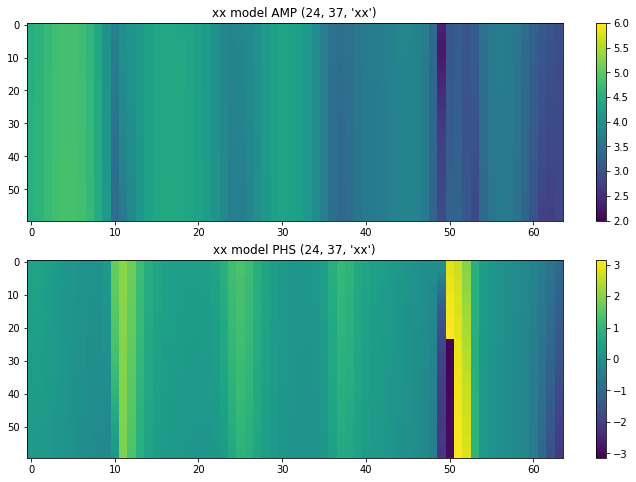

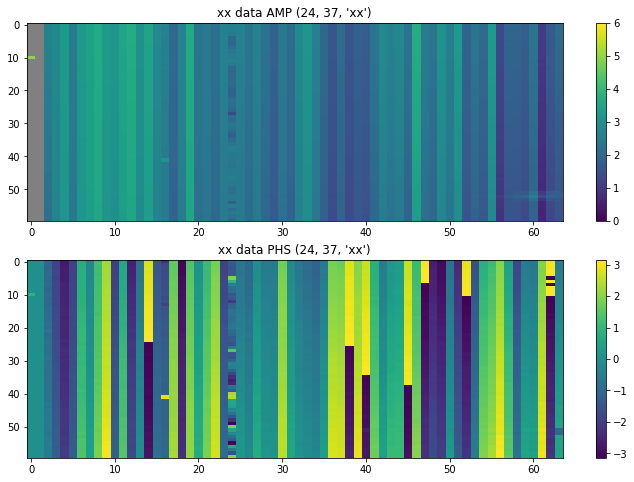

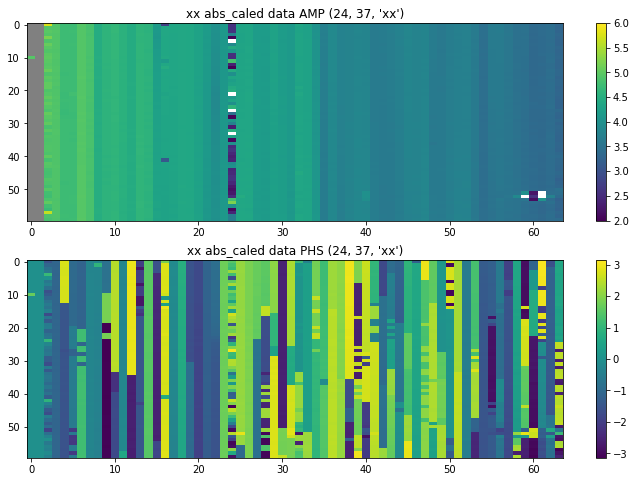

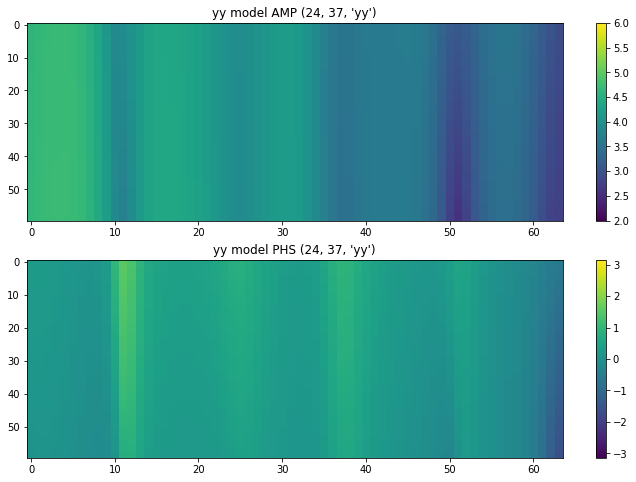

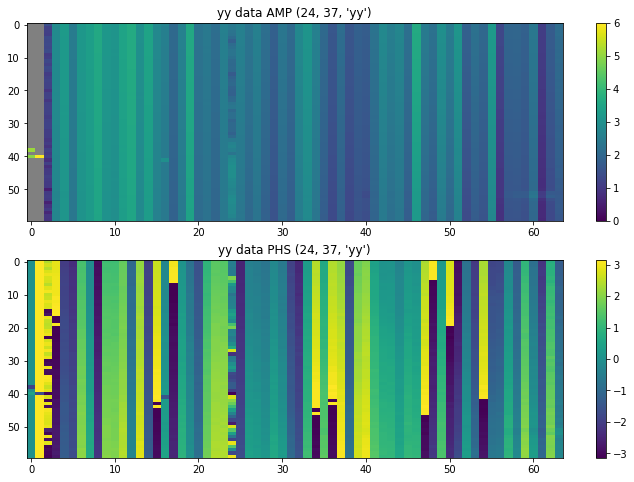

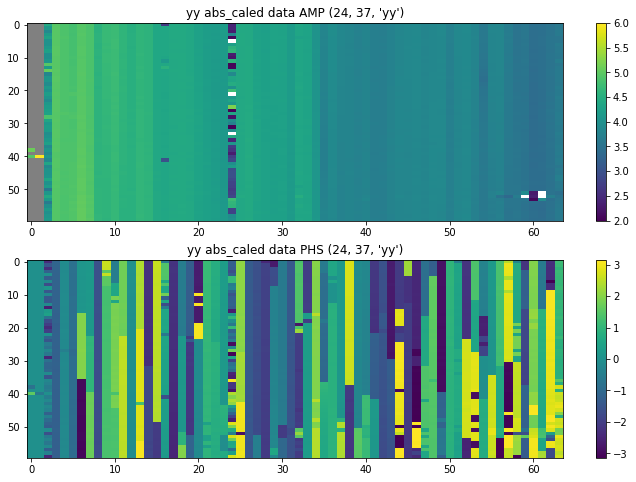

In [28]:
Absolute_Calibration_dred_mfreq_pscal = True

if Absolute_Calibration_dred_mfreq_pscal:
	
	for i in range(2):
		data_dred_mfreq_pscal[i] = LastUpdatedOrderedDict()
		pol = ['xx', 'yy'][i]
		if Absolute_Calibration_dred_mfreq:
			keys = dflags_dred_mfreq[i].keys()
			for key_index, key in enumerate(keys):
				#model_dred_mfreq[i][key] = fullsim_vis_mfreq[key_index, i]
				#data_dred_mfreq[i][key] = np.real(vis_data_dred_mfreq[i][:, :, key_index].transpose()) + np.abs(np.imag(vis_data_dred_mfreq[i][:, :, key_index].transpose()))*1j #[pol][freq,time,ubl_index].transpose()
				data_dred_mfreq_pscal[i][key] = vis_data_dred_mfreq_pscal[i][:, :, key_index].transpose() #[pol][freq,time,ubl_index].transpose()
			if add_Autobsl:
				model_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_vis_mfreq[i] # not lose generality, choose the first anntena in the first UBL for autocorrelation calibraiton.
				data_dred_mfreq_pscal[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_data_mfreq[i] # add the autocorrelation of first antenna in the first UBL as the last line in visibility.
				cdflags_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = np.array([[False]*autocorr_data_mfreq[i].shape[1]]*autocorr_data_mfreq[i].shape[0])
				auto_select_dred_mfreq_pscal[i] = (keys[0][0], keys[0][0], keys[0][2])
			print(dflags_dred_mfreq[i].keys())
			print(dflags_dred_mfreq[i].keys()[0][0])
				
		
				
	re_cal_times = 3

	for i in range(2):
		pol = ['xx', 'yy'][i]
		re_cal = 0
		
		if Absolute_Calibration_dred_mfreq_pscal:
			for re_cal in range(re_cal_times): # number of times of absolute calibration
				if re_cal == 0:
					model_dred_mfreq[i], interp_flags_dred_mfreq[i] = hc.abscal.interp2d_vis(model_dred_mfreq[i], lsts, flist[i], lsts, flist[i])
					# instantiate class
					AC_dred_mfreq_pscal[i] = hc.abscal.AbsCal(model_dred_mfreq[i], data_dred_mfreq_pscal[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
					# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
					AC_dred_mfreq_pscal[i].delay_lincal(kernel=(1, 11), medfilt=True, time_avg=True, solve_offsets=True)
				else:
					#model_dred_mfreq[i], interp_flags_dred_mfreq[i] = hc.abscal.interp2d_vis(model_dred_mfreq[i], lsts, flist[i], lsts, flist[i])
					# instantiate class
					AC_dred_mfreq_pscal[i] = hc.abscal.AbsCal(model_dred_mfreq[i], abs_corr_data_dred_mfreq_pscal[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
					# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
					AC_dred_mfreq_pscal[i].delay_lincal(kernel=(1, 3), medfilt=True, time_avg=True, solve_offsets=True)
				# apply to data
				delay_corr_data_dred_mfreq_pscal[i] = hc.abscal.apply_gains(AC_dred_mfreq_pscal[i].data, (AC_dred_mfreq_pscal[i].ant_dly_gain))
				# instantiate class
				DAC_dred_mfreq_pscal[i] = hc.abscal.AbsCal(model_dred_mfreq[i], delay_corr_data_dred_mfreq_pscal[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
				# avg phase solver
				DAC_dred_mfreq_pscal[i].phs_logcal(avg=True)
				# apply to data
				dly_phs_corr_data_dred_mfreq_pscal[i] = hc.abscal.apply_gains(DAC_dred_mfreq_pscal[i].data, (DAC_dred_mfreq_pscal[i].ant_phi_gain))
				# instantiate class
				DPAC_dred_mfreq_pscal[i] = hc.abscal.AbsCal(model_dred_mfreq[i], dly_phs_corr_data_dred_mfreq_pscal[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
				# run amp linsolve
				DPAC_dred_mfreq_pscal[i].abs_amp_logcal()
				# run phs linsolve
				DPAC_dred_mfreq_pscal[i].TT_phs_logcal(zero_psi=False, four_pol=False)
				# apply to data
				abs_corr_data_dred_mfreq_pscal[i] = hc.abscal.apply_gains(DPAC_dred_mfreq_pscal[i].data, 
										(DPAC_dred_mfreq_pscal[i].abs_psi_gain, DPAC_dred_mfreq_pscal[i].TT_Phi_gain, DPAC_dred_mfreq_pscal[i].abs_eta_gain), gain_convention='multiply')
									
			vis_data_dred_mfreq_pscal_abscal[i] = np.zeros_like(vis_data_dred_mfreq_pscal[i], dtype='complex128')
			for key_id, key in enumerate(dflags_dred_mfreq[i].keys()):
				vis_data_dred_mfreq_pscal_abscal[i][:, :, key_id] = abs_corr_data_dred_mfreq_pscal[i][key].transpose()
				#vis_data_dred_mfreq_pscal_abscal[i][:, :, key_id] = np.real(abs_corr_data_dred_mfreq_pscal[i][key].transpose()) + np.abs(np.imag(abs_corr_data_dred_mfreq_pscal[i][key].transpose()))*1j
			if add_Autobsl:
				autocorr_data_dred_mfreq_pscal_abscal[i] = abs_corr_data_dred_mfreq_pscal[i][auto_select_dred_mfreq_pscal[i]]
			else:
				autocorr_data_dred_mfreq_pscal_abscal[i] = autocorr_vis_mfreq[i]
				
			vis_data_dred_pscal_abscal[i] = vis_data_dred_mfreq_pscal_abscal[i][index_freq[i], :, :]
			if add_Autobsl: 
				autocorr_data_dred_pscal_abscal[i] = autocorr_data_dred_mfreq_pscal_abscal[i][:, index_freq[i]]
			else:
				autocorr_data_dred_pscal_abscal[i] = autocorr_vis_mfreq[i][:, index_freq[i]]
			
	for i in range(2):
		pol = ['xx', 'yy'][i]
		
		if Absolute_Calibration_dred_mfreq_pscal:								
			plt.figure(85000000+10*i)
			fig4[i], axes4[i] = plt.subplots(2, 1, figsize=(12, 8))
			plt.sca(axes4[i][0])
			uvt.plot.waterfall(AC_dred_mfreq_pscal[i].model[bl_dred_mfreq_pscal[i]], mode='log', mx=6, drng=4)
			plt.colorbar()
			plt.title(pol + ' model AMP {}'.format(bl_dred_mfreq_pscal[i]))
			plt.sca(axes4[i][1])
			uvt.plot.waterfall(AC_dred_mfreq_pscal[i].model[bl_dred_mfreq_pscal[i]], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' model PHS {}'.format(bl_dred_mfreq_pscal[i]))
			plt.show(block=False)			
			#plt.cla()
				
			plt.figure(95000000+10*i)
			fig4_data[i], axes4_data[i] = plt.subplots(2, 1, figsize=(12, 8))
			plt.sca(axes4_data[i][0])
			uvt.plot.waterfall(data_dred_mfreq_pscal[i][bl_dred_mfreq_pscal[i]], mode='log', mx=6, drng=6)
			plt.colorbar()
			plt.title(pol + ' data AMP {}'.format(bl_dred_mfreq_pscal[i]))
			plt.sca(axes4_data[i][1])
			uvt.plot.waterfall(data_dred_mfreq_pscal[i][bl_dred_mfreq_pscal[i]], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' data PHS {}'.format(bl_dred_mfreq_pscal[i]))
			plt.show(block=False)
			#plt.cla()		
				
			####################### after ABS Calibration #########################	
			plt.figure(8500000+10*i)
			fig4_data_abscorr[i], axes4_data_abscorr[i] = plt.subplots(2, 1, figsize=(12, 8))
			plt.sca(axes4_data_abscorr[i][0])
			uvt.plot.waterfall(abs_corr_data_dred_mfreq_pscal[i][bl_dred_mfreq_pscal[i]], mode='log', mx=6, drng=4)
			plt.colorbar()
			plt.title(pol + ' abs_caled data AMP {}'.format(bl_dred_mfreq_pscal[i]))
			plt.sca(axes4_data_abscorr[i][1])
			uvt.plot.waterfall(abs_corr_data_dred_mfreq_pscal[i][bl_dred_mfreq_pscal[i]], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' abs_caled data PHS {}'.format(bl_dred_mfreq_pscal[i]))
			plt.show(block=False)
			#plt.cla()
	

In [29]:
################################### Store Visibility Data and prepare to Delete Variable ##################################
data_vis_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
data_vis_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
vis_data[0].astype('complex128').tofile(data_vis_xx_filename)
vis_data[1].astype('complex128').tofile(data_vis_yy_filename)

data_vis_dred_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_dred_xx_dred.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
data_vis_dred_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_dred_yy_dred.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
vis_data_dred[0].astype('complex128').tofile(data_vis_dred_xx_filename)
vis_data_dred[1].astype('complex128').tofile(data_vis_dred_yy_filename)

data_vis_dred_mfreq_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx_mfreq%s-%s-%s_dred_mfreq.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[0]))
data_vis_dred_mfreq_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy_mfreq%s-%s-%s_dred_mfreq.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[1]), np.max(flist[1]), len(flist[1]))
vis_data_dred_mfreq[0].astype('complex128').tofile(data_vis_dred_mfreq_xx_filename)
vis_data_dred_mfreq[1].astype('complex128').tofile(data_vis_dred_mfreq_yy_filename)

abscal_data_vis_dred_mfreq_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx_mfreq%s-%s-%s_dred_mfreq_abscal.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[0]))
abscal_data_vis_dred_mfreq_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy_mfreq%s-%s-%s_dred_mfreq_abscal.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[1]), np.max(flist[1]), len(flist[1]))
vis_data_dred_mfreq_abscal[0].astype('complex128').tofile(abscal_data_vis_dred_mfreq_xx_filename)
vis_data_dred_mfreq_abscal[1].astype('complex128').tofile(abscal_data_vis_dred_mfreq_yy_filename)

abscal_data_vis_dred_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx_%s_dred_abscal.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, freq)
abscal_data_vis_dred_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy_%s_dred_abscal.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, freq)
vis_data_dred_abscal[0].astype('complex128').tofile(abscal_data_vis_dred_xx_filename)
vis_data_dred_abscal[1].astype('complex128').tofile(abscal_data_vis_dred_yy_filename)

pscal_data_vis_dred_mfreq_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx_%s_dred_mfreq_pscal.simvis'%(INSTRUMENT, nUBL, nt, nside_standard, bnside, freq)
pscal_data_vis_dred_mfreq_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy_%s_dred_mfreq_pscal.simvis'%(INSTRUMENT, nUBL, nt, nside_standard, bnside, freq)
vis_data_dred_mfreq_pscal[0].astype('complex128').tofile(pscal_data_vis_dred_mfreq_xx_filename)
vis_data_dred_mfreq_pscal[1].astype('complex128').tofile(pscal_data_vis_dred_mfreq_yy_filename)

pscal_data_vis_dred_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx_%s_pscal.simvis'%(INSTRUMENT, nUBL, nt, nside_standard, bnside, freq)
pscal_data_vis_dred_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy_%s_pscal.simvis'%(INSTRUMENT, nUBL, nt, nside_standard, bnside, freq)
vis_data_dred_pscal[0].astype('complex128').tofile(pscal_data_vis_dred_xx_filename)
vis_data_dred_pscal[1].astype('complex128').tofile(pscal_data_vis_dred_yy_filename)

sys.stdout.flush()


In [30]:
#print noise['x']

In [31]:
################
####read data and N
################
data = {}
Ni = {}
data_shape = {}
ubl_sort = {}
data_filename = full_sim_filename

Use_Simulation_noise = True
From_File_Data = True


for p in ['x', 'y']:
	pol = p + p
	print "%i UBLs to include, longest baseline is %i wavelengths" % (
	nUBL_used, np.max(np.linalg.norm(used_common_ubls, axis=1)) / (C / freq))
	if p == 'x':
		pol_index = 0
		sim_var_filename = sim_var_xx_filename
		sim_vis_filename = sim_vis_xx_filename
		try:
			data_var_filename = data_var_xx_filename
			data_var_filename_pscal = data_var_xx_filename_pscal
		except:
			pass
	elif p == 'y':
		pol_index = 1
		sim_var_filename = sim_var_yy_filename
		sim_vis_filename = sim_vis_yy_filename
		try:
			data_var_filename = data_var_yy_filename
			data_var_filename_pscal = data_var_yy_filename_pscal
		except:
			pass

	# get Ni (1/variance) and data
#	var_filename = datadir + tag + '_%s%s_%i_%i' % (p, p, nt, nUBL) + vartag + '.var'
#	Ni[pol] = 1. / (N[p].reshape((nt_used, nUBL_used))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten() * jansky2kelvin ** 2)
	if Use_SimulatedData == 1:
#		Ni[pol] = 1. / (np.fromfile(data_var_filename, dtype='complex128').reshape((nt_used, nUBL_used))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten() * jansky2kelvin ** 2)
		Ni[pol] = 1. / (np.fromfile(sim_var_filename, dtype='complex128').reshape((nt_used, nUBL_used)).transpose().flatten())
		data[pol] = np.fromfile(sim_vis_filename, dtype='complex128').reshape((nUBL_used, nt_used))
	else:
		if INSTRUMENT == 'miteor':
			if Use_Simulation_noise:
				Ni[pol] = 1. / (np.fromfile(data_var_filename, dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten())
			else:
				Ni[pol] = 1. / var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
			data[pol] = vis_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1] #= (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex64')			
			data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0].conjugate()
#			data[pol] = (data[pol].flatten() * jansky2kelvin).conjugate()  # there's a conjugate convention difference
			data[pol] = (data[pol].flatten()).conjugate()  # there's a conjugate convention difference
		elif INSTRUMENT == 'hera47':
			if From_File_Data:
				if Use_PsAbsCal:
					Ni[pol] = 1. / (np.fromfile(data_var_filename_pscal, dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten()) #var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
				elif Use_Fullsim_Noise:
					Ni[pol] = 1. / (np.fromfile(sim_var_filename, dtype='complex128').reshape((nt_used, nUBL_used)).transpose().flatten())
				else:
					Ni[pol] = 1. / (np.fromfile(data_var_filename, dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten()) #var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
			else:
				if Use_PsAbsCal:
					Ni[pol] = 1. / N_data_pscal[p].reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten() #var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
				elif Use_Fullsim_Noise:
					Ni[pol] = 1. / (np.fromfile(sim_var_filename, dtype='complex128').reshape((nt_used, nUBL_used)).transpose().flatten())
				else:
					Ni[pol] = 1. / N_data[p].reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten() #var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
			if From_File_Data:
				if Use_PsAbsCal:
					data[pol] = np.fromfile(globals()['pscal_data_vis_dred_' + pol + '_filename'], dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1]
				elif Use_AbsCal:				
					data[pol] = np.fromfile(globals()['abscal_data_vis_dred_' + pol + '_filename'], dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1]
				else:
					data[pol] = np.fromfile(globals()['data_vis_dred_' + pol + '_filename'], dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1]
			else:
				if Use_PsAbsCal:
					data[pol] = vis_data_dred_pscal[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1] #= (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex64')
					#data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0]#.conjugate()
					data[pol] = data[pol].flatten()#.conjugate()  # there's a conjugate convention difference
				elif Use_AbsCal:				
					data[pol] = vis_data_dred_abscal[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1] #= (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex64')
					#data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0]#.conjugate()
					data[pol] = data[pol].flatten()#.conjugate()  # there's a conjugate convention difference
				else:
					data[pol] = vis_data_dred[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1] #= (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex64')
					#data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0]#.conjugate()
					data[pol] = (data[pol].flatten() * jansky2kelvin)#.conjugate()  # there's a conjugate convention difference
			#data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0]#.conjugate()
			#data[pol] = (data[pol].flatten() * jansky2kelvin)#.conjugate()  # there's a conjugate convention difference
	data_shape[pol] = (nUBL_used, nt_used)
	ubl_sort[p] = np.argsort(la.norm(used_common_ubls, axis=1))
print "Memory usage: %.3fMB" % (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1024)
sys.stdout.flush()

# Merge data
data = np.array([data['xx'], data['yy']]).reshape([2] + list(data_shape['xx'])).transpose(
	(1, 0, 2)).flatten()
data = np.concatenate((np.real(data), np.imag(data))).astype('complex128')
Ni = np.concatenate((Ni['xx'], Ni['yy'])).reshape([2] + list(data_shape['xx'])).transpose(
	(1, 0, 2)).flatten()
Ni = np.concatenate((Ni * 2, Ni * 2))

sys.stdout.flush()

def get_complex_data(real_data, nubl=nUBL_used, nt=nt_used):
	if len(real_data.flatten()) != 2 * nubl * 2 * nt:
		raise ValueError("Incorrect dimensions: data has length %i where nubl %i and nt %i together require length of %i."%(len(real_data), nubl, nt, 2 * nubl * 2 * nt))
	input_shape = real_data.shape
	real_data.shape = (2, nubl, 2, nt)
	result = real_data[0] + 1.j * real_data[1]
	real_data.shape = input_shape
	return result

def stitch_complex_data(complex_data):
	return np.concatenate((np.real(complex_data.flatten()), np.imag(complex_data.flatten()))).astype('complex128')


9 UBLs to include, longest baseline is 14 wavelengths
9 UBLs to include, longest baseline is 14 wavelengths
Memory usage: 3702332.000MB


In [32]:
##################### Delete or Erase Data #######################
Erase = False
if Erase:
	model_sf = {}
	model_dred = {}
	model_dred_mfreq = {}
	#data = {}
	data_sf = {}
	data_dred = {}
	data_dred_mfreq = {}
	AC = {}
	AC_sf = {}
	AC_dred = {}
	AC_dred_mfreq = {}
	freq_to_cal = [freq]
	fulldflags = {}
	auto_select_dred_mfreq = {}

	#	try:
	#		cdata = copy.deepcopy(data)
	#	except:
	#		pass

	try:
		del(dflags_sf) 
		#del(cdflags_sf)
	except:
		pass
		
	try:
		del(dflags_dred) 
		#del(cdflags_dred)
	except:
		pass

	try:
		del(dflags)
		#del(cdflags) 
	except:
		pass

	try:
		del(dflags_dred_mfreq)
		#del(cdflags_dred_mfreq) 
	except:
		pass
		
	#cwgts = copy.deepcopy(wgts)
	#cwgts_dred = copy.deepcopy(wgts_dred)

	bl_select = 0
	#bl = dflags.keys()[bl_select] #dflags and dflags_yy #[(24, 53, 'xx')
	fig = {}
	axes = {}
	fig_data = {}
	axes_data = {}

	bl_dred_select = 0
	#bl_dred = dflags_dred[0].keys()[bl_dred_select] #[(25, 37, 'xx')
	fig2 = {}
	axes2 = {}
	fig2_data = {}
	axes2_data = {}

	bl_dred_mfreq_select = 8
	#bl_dred_mfreq = [dflags_dred_mfreq[0].keys()[bl_dred_mfreq_select], dflags_dred_mfreq[1].keys()[bl_dred_mfreq_select]]  #[(25, 37, 'xx'), (25, 37, 'yy')]
	fig3 = {}
	axes3 = {}
	fig3_data = {}
	axes3_data = {}
	fig3_data_abscorr = {} 
	axes3_data_abscorr = {}

	delay_corr_data = {}
	delay_corr_data_sf = {}
	delay_corr_data_dred = {}
	delay_corr_data_dred_mfreq = {}
	DAC = {}
	DAC_sf = {}
	DAC_dred = {}
	DAC_dred_mfreq = {}
	dly_phs_corr_data = {}
	dly_phs_corr_data_sf = {}
	dly_phs_corr_data_dred = {}
	dly_phs_corr_data_dred_mfreq = {}
	DPAC = {}
	DPAC_sf = {}
	DPAC_dred = {}
	DPAC_dred_mfreq = {}
	abs_corr_data = {}
	abs_corr_data_sf = {}
	abs_corr_data_dred = {}
	abs_corr_data_dred_mfreq = {}

	vis_data_dred_mfreq_abscal = [[], []]
	autocorr_data_dred_mfreq_abscal = [[], []]
	vis_data_dred_abscal = [[], []]
	autocorr_data_dred_abscal = [[], []]


	Del = True
	if Del:
		try:
			del(vis_data)
			del(vis_data_dred)
		except:
			pass
		try:
			del(vis_data_mfreq)
			del(vis_data_dred_mfreq)
		except:
			pass	
			
			
		try:
			del(N_data)
		except:
			pass
		try:
			del(noise_data)
		except:
			pass
		try:
			del(var_data)
		except:
			pass
	#	try:
	#		del(var_data)
	#	except:
	#		pass

sys.stdout.flush()


In [33]:
print Ni

[ 8.25657541+0.j  0.63091895+0.j 10.5913842 +0.j ... 10.80306947+0.j
 23.74234118+0.j  2.30869592+0.j]


In [34]:
# pre_ampcal = False

In [35]:
#pre_ampcal = True

In [36]:
################################
################################
####pre_calibrate################
################################
################################
#####1. antenna based calibration#######
for cal_index in range(1):
	if cal_index == 0:
		raw_data = np.copy(data).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])
#	if pre_ampcal:
#		pre_ampcal = False if cal_index == 0 else True
#		cal_index += 1
#	else:
#		cal_index = 2 
	if antpairs is not None:
		used_antpairs = antpairs[abs(ubl_index['x'])-1]
		n_usedants = np.unique(used_antpairs)
	#####2. re-phasing and crosstalk#######
	additive_A = np.zeros((nUBL_used, 2, nt_used, 1 + 4 * nUBL_used)).astype('complex128')

	#put in autocorr regardless of whats saved on disk
	for p in range(2):
		additive_A[:, p, :, 0] = fullsim_vis[:, p]
		for i in range(nUBL_used):
			additive_A[i, p, :, 1 + 4 * i + 2 * p] = 1. * autocorr_vis_normalized[p]
			additive_A[i, p, :, 1 + 4 * i + 2 * p + 1] = 1.j * autocorr_vis_normalized[p]
	additive_A.shape = (nUBL_used * 2 * nt_used, 1 + 4 * nUBL_used)

	if pre_calibrate:
		#import omnical.calibration_omni as omni
		#raw_data = np.copy(data).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])
		#raw_Ni = np.copy(Ni)

		real_additive_A = np.concatenate((np.real(additive_A), np.imag(additive_A)), axis=0).astype('complex128')
		if pre_ampcal:#if pre_ampcal, allow xx and yy to fit amp seperately
			n_prefit_amp = 2
			real_additive_A.shape = (2 * nUBL_used, 2, nt_used, 1 + 4 * nUBL_used)
			real_additive_A_expand = np.zeros((2 * nUBL_used, 2, nt_used, n_prefit_amp + 4 * nUBL_used), dtype='complex128')
			for i in range(n_prefit_amp):
				real_additive_A_expand[:, i, :, i] = real_additive_A[:, i, :, 0]
			real_additive_A_expand[..., n_prefit_amp:] = real_additive_A[..., 1:]
			real_additive_A = real_additive_A_expand
			real_additive_A.shape = (2 * nUBL_used * 2 * nt_used, n_prefit_amp + 4 * nUBL_used)
		else:
			n_prefit_amp = 1

		additive_AtNiA = np.empty((n_prefit_amp + 4 * nUBL_used, n_prefit_amp + 4 * nUBL_used), dtype='complex128')
		if pre_addcal:
			ATNIA(real_additive_A, Ni, additive_AtNiA)
			additive_AtNiAi = sla.inv(additive_AtNiA)
		else:
			real_additive_A[..., n_prefit_amp:] = 0.
			ATNIA(real_additive_A, Ni, additive_AtNiA)
			additive_AtNiAi = sla.pinv(additive_AtNiA)

		niter = 0
		rephases = np.zeros((2,2))
		additive_term = np.zeros_like(data)
		additive_term_incr = np.zeros_like(data)
		while (niter == 0 or la.norm(rephases) > .001 or la.norm(additive_term_incr) / la.norm(data) > .001) and niter < 500:
			niter += 1

			if pre_phscal:
				cdata = get_complex_data(data)
				for p, pol in enumerate(['xx', 'yy']):
					#rephase = omni.solve_phase_degen_fast(cdata[:, p].transpose(), cdata[:, p].transpose(), fullsim_vis[:, p].transpose(), fullsim_vis[:, p].transpose(), used_common_ubls)
					rephase = solve_phase_degen(cdata[:, p].transpose(), cdata[:, p].transpose(), fullsim_vis[:, p].transpose(), fullsim_vis[:, p].transpose(), used_common_ubls)
					rephases[p] = rephase
					if p == 0:
						print 'pre process rephase', pol, rephase,
					else:
						print pol, rephase
					cdata[:, p] *= np.exp(1.j * used_common_ubls[:, :2].dot(rephase))[:, None]
				data = stitch_complex_data(cdata).astype('complex128')

			additive_sol = additive_AtNiAi.dot(np.transpose(real_additive_A).dot(data * Ni))
			print '>>>>>>>>>>>>>additive fitting amp', additive_sol[:n_prefit_amp],
			additive_term_incr = real_additive_A[:, n_prefit_amp:].dot(additive_sol[n_prefit_amp:])
			data -= additive_term_incr
			additive_term += additive_term_incr
			print "additive fraction", la.norm(additive_term_incr) / la.norm(data),

		cadd = get_complex_data(additive_term)

		if pre_ampcal:
			data = stitch_complex_data(get_complex_data(data) / additive_sol[:n_prefit_amp, None])
			if Use_PsAbsCal and not comply_ps2mod_autocorr:
				Ni = stitch_complex_data(get_complex_data(Ni) * additive_sol[:n_prefit_amp, None]**2)
			additive_term = stitch_complex_data(get_complex_data(additive_term) / additive_sol[:n_prefit_amp, None])
			
			print(additive_sol[:n_prefit_amp])
			
print 'saving data to', os.path.dirname(data_filename) + '/' + INSTRUMENT + tag + datatag + vartag + '_gsmcal_n%i_bn%i.npz'%(nside_standard, bnside)
np.savez(os.path.dirname(data_filename) + '/' + INSTRUMENT + tag + datatag + vartag + '_gsmcal_n%i_bn%i.npz'%(nside_standard, bnside),
		 data=data,
		 simdata=stitch_complex_data(fullsim_vis),
		 psdata=[stitch_complex_data(vis) for vis in pt_vis],
		 pt_sources=pt_sources,
		 ubls=used_common_ubls,
		 tlist=lsts,
		 Ni=Ni,
		 freq=freq)
	
	


Estimated time for A 2160 by 38 4.054752e-05 minutes pre process rephase xx [0.04686915 0.07159187] yy [-0.03177951 -0.16423232]
>>>>>>>>>>>>>additive fitting amp [-0.00462753+0.j -0.01421156+0.j] additive fraction 1.4588051925922005 pre process rephase xx [0.03748799 0.13564374] yy [-0.10681638 -0.12110598]
>>>>>>>>>>>>>additive fitting amp [ 0.00867815+0.j -0.03311231+0.j] additive fraction 1.0383134612674652 pre process rephase xx [0.00915594 0.01488961] yy [-0.15905843 -0.03130792]
>>>>>>>>>>>>>additive fitting amp [ 0.00883094+0.j -0.08780825+0.j] additive fraction 1.2069995863997185 pre process rephase xx [0.00441132 0.01288344] yy [0.16055572 0.03155643]
>>>>>>>>>>>>>additive fitting amp [ 0.01235484+0.j -0.03649875+0.j] additive fraction 2.7103218253433683 pre process rephase xx [0.00115731 0.00544438] yy [-0.15916915 -0.03143032]
>>>>>>>>>>>>>additive fitting amp [ 0.01430806+0.j -0.08511157+0.j] additive fraction 1.236891400541523 pre process rephase xx [0.00046204 0.00276754

>>>>>>>>>>>>>additive fitting amp [0.01722529+0.j 0.0428326 +0.j] additive fraction 0.0016626802803631105 pre process rephase xx [6.03491983e-12 2.36196961e-11] yy [1.09076866e-05 7.84196487e-05]
>>>>>>>>>>>>>additive fitting amp [0.01722529+0.j 0.04290548+0.j] additive fraction 0.0015838233479985352 pre process rephase xx [3.80553727e-12 1.48849215e-11] yy [1.37292970e-05 7.01432193e-05]
>>>>>>>>>>>>>additive fitting amp [0.01722529+0.j 0.04297675+0.j] additive fraction 0.001542762762817644 pre process rephase xx [2.39027860e-12 9.39859744e-12] yy [1.56580412e-05 6.29008721e-05]
>>>>>>>>>>>>>additive fitting amp [0.01722529+0.j 0.04304576+0.j] additive fraction 0.0014906825569234517 pre process rephase xx [1.51353339e-12 5.93934312e-12] yy [1.68878889e-05 5.65427107e-05]
>>>>>>>>>>>>>additive fitting amp [0.01722529+0.j 0.04311208+0.j] additive fraction 0.0014306356827957724 pre process rephase xx [9.65988787e-13 3.74181857e-12] yy [1.75746665e-05 5.09431005e-05]
>>>>>>>>>>>>>additive

In [37]:
print la.norm(data)
print la.norm(raw_data)
print la.norm(fullsim_vis)
print la.norm(raw_data)/la.norm(data)
print #la.norm(raw_Ni)
print la.norm(Ni)
print data
print fullsim_vis

606236.487743738
9936.497287233044
490013.22120103094
0.01639046393300117

3753.192556127127
[28977.21247847+0.j 28017.13543494+0.j 25717.5478105 +0.j ...
  3310.82475207+0.j  3482.87444709+0.j  3019.65019101+0.j]
[[[ -6933.77123406+9.77620029e+02j  -6932.71429535+9.90285496e+02j
    -6931.54735726+1.00292621e+03j ...  -6710.71177322+1.62681606e+03j
    -6702.61150573+1.63660432e+03j  -6694.40249167+1.64631833e+03j]
  [-10985.34344495+8.07110421e+02j -10987.25437447+8.16943652e+02j
   -10989.07214343+8.26744406e+02j ... -10947.26104782+1.29942875e+03j
   -10943.28959943+1.30641289e+03j -10939.21712817+1.31333067e+03j]]

 [[ -4287.04953807-8.39421014e+02j  -4295.11989577-8.27811111e+02j
    -4303.13823568-8.16059590e+02j ...  -4573.57220637+1.74733880e+01j
    -4574.12338644+3.55429442e+01j  -4574.47470352+5.36660703e+01j]
  [ -2498.33371822-7.36639388e+02j  -2509.05309706-7.28157299e+02j
    -2519.7313397 -7.19513860e+02j ...  -2941.85886904-2.34884758e+01j
    -2945.25266905-7.0952406

In [38]:
print additive_sol[0], additive_sol[1], n_prefit_amp
print (additive_sol[0] * (pre_ampcal)+(not pre_ampcal))
print additive_sol[:n_prefit_amp, None]
print pre_ampcal

(0.017225291698380607+0j) (0.04348817270288219+0j) 2
(0.017225291698380607+0j)
[[0.01722529+0.j]
 [0.04348817+0.j]]
True


In [39]:
print la.norm(data)
print la.norm(raw_data)
print la.norm(fullsim_vis)
print la.norm(fullsim_vis)/la.norm(data)
#print la.norm(raw_Ni)
print la.norm(Ni)
print Ni
print Ni.max()
print Ni**-0.5

606236.487743738
9936.497287233044
490013.22120103094
0.8082872461615412
3753.192556127127
[0.00244981+0.j 0.0001872 +0.j 0.00314258+0.j ... 0.02043099+0.j
 0.04490202+0.j 0.00436625+0.j]
(2136.85842160539+0j)
[20.2038176 +0.j 73.08809248+0.j 17.83844747+0.j ...  6.99608787+0.j
  4.71918572+0.j 15.13371225+0.j]


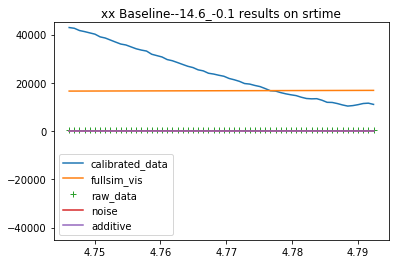

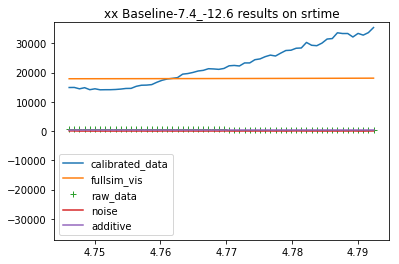

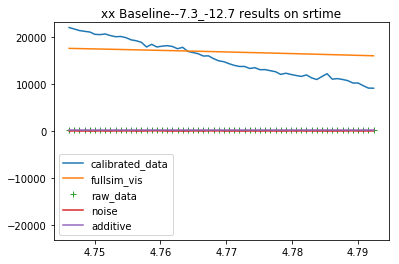

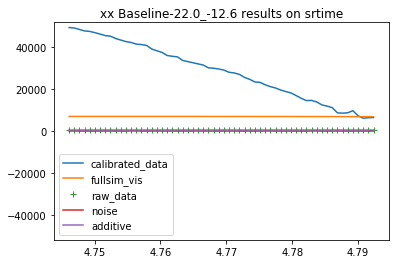

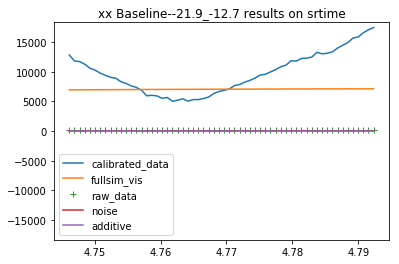

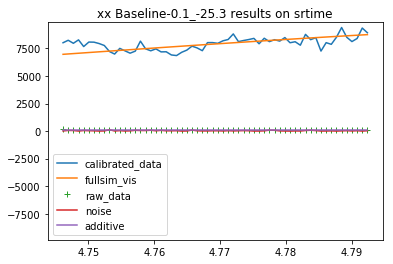

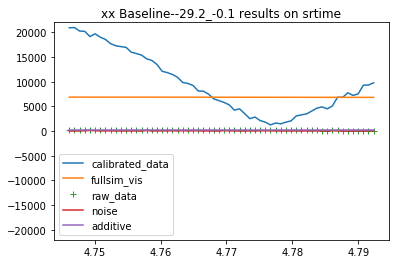

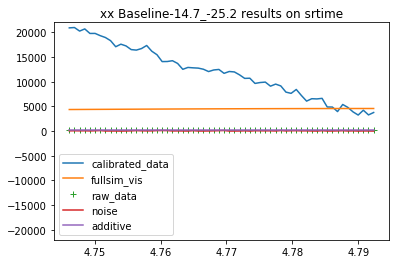

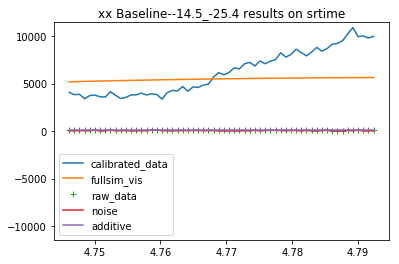

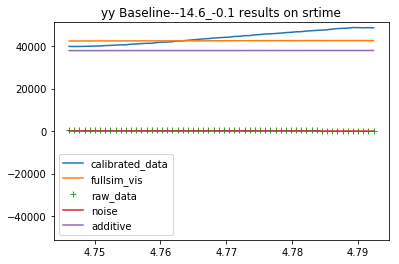

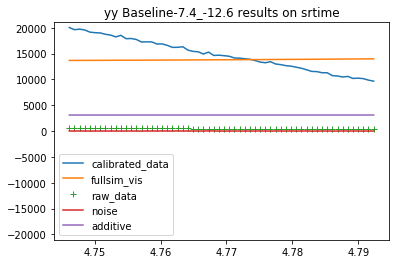

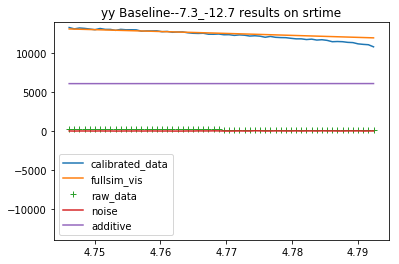

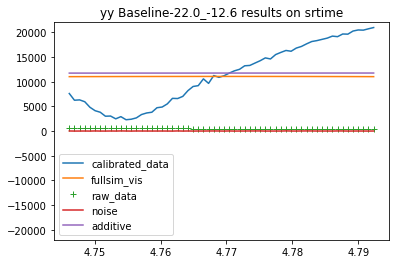

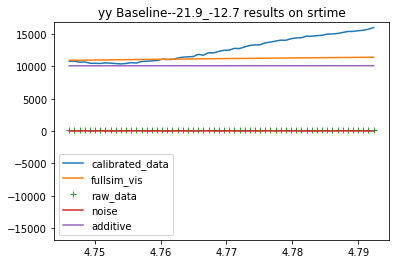

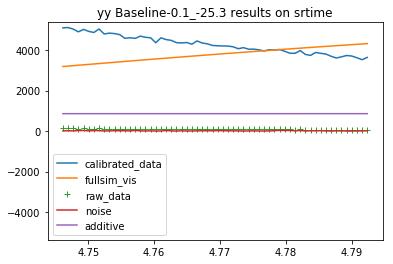

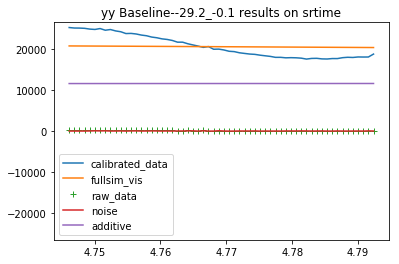

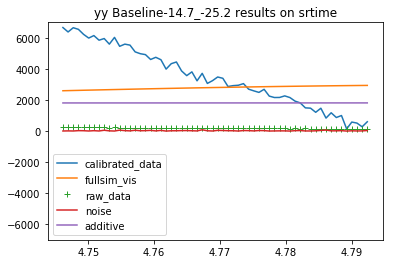

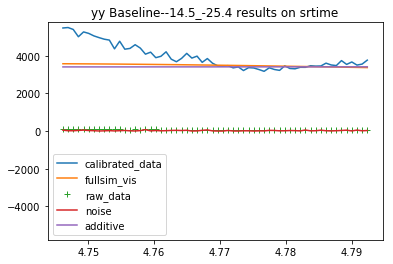

In [40]:
if plot_data_error:
	#plt.clf()
	
	cdata = get_complex_data(data)
	crdata = get_complex_data(raw_data) #/ (additive_sol[0] * (pre_ampcal) + (not pre_ampcal))
	cNi = get_complex_data(Ni)
	

	fun = np.abs
	srt = sorted((lsts - lst_offset)%24.+lst_offset)
	asrt = np.argsort((lsts - lst_offset)%24.+lst_offset)
	pncol = min(int(60. / (srt[-1] - srt[0])), 12)
	us = ubl_sort['x'][::len(ubl_sort['x'])/pncol] if len(ubl_sort['x'])/pncol >=1 else ubl_sort['x']
	figure = {}
#		plt.figure(400)
#		plt.subplots_adjust(hspace=1.2,wspace=0.7)
	for p in range(2):
#			plt.figure(400+10*p)
#			plt.subplots_adjust(hspace=1.2,wspace=0.7)
#			for nu, u in enumerate(us):
#				
#				plt.subplot(5, (len(us) + 4) / 5, nu + 1)
#				plt.plot(srt, fun(cdata[u, p][asrt]))
#				plt.plot(srt, fun(fullsim_vis[u, p][asrt]))
#				plt.plot(srt, fun(crdata[u, p][asrt]))
#				plt.plot(srt, fun(cNi[u, p][asrt])**-.5)
#				if pre_calibrate:
#					plt.plot(srt, fun(cadd[u, p][asrt]))
#				data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(crdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), 5 * np.max(np.abs(fun(cNi[u, p]))), np.max(fun(cadd[u, p]))])
#				plt.title("%s Baseline-%.1f_%.1f results on srtime"%(['xx','yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
#				plt.ylim([-1.05*data_range, 1.05*data_range])		
#			plt.savefig(script_dir + '/../Output/%s-dipole-precal_data_error-fullvis-%s-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, ['xx','yy'][p], beam_freqs[ind], bnside, nside_standard))
#			plt.show(block=False)
		
		#plt.figure(500+10*p)
		#plt.subplots_adjust(hspace=1.2,wspace=0.7)
		for nu, u in enumerate(us):
			plt.figure(5000+100*p+nu)
			#plt.subplot(5, (len(us) + 4) / 5, nu + 1)
			figure[1], = plt.plot(srt, fun(cdata[u, p][asrt]), label='calibrated_data')
			figure[2], = plt.plot(srt, fun(fullsim_vis[u, p][asrt]), label='fullsim_vis')
			figure[3], = plt.plot(srt, fun(crdata[u, p][asrt]), '+', label='raw_data')
			figure[4], = plt.plot(srt, fun(cNi[u, p][asrt])**-.5, label='Ni')
			if pre_calibrate:
				figure[5], = plt.plot(srt, fun(cadd[u, p][asrt]), label='additive')
				data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(crdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), np.max(fun(cadd[u, p]))]) #5 * np.max(np.abs(fun(cNi[u, p]))),
			else:
				data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(crdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p])))]) #5 * np.max(np.abs(fun(cNi[u, p])))
			plt.title("%s Baseline-%.1f_%.1f results on srtime"%(['xx','yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
			plt.ylim([-1.05*data_range, 1.05*data_range])
			if pre_calibrate:
				plt.legend(handles=[figure[1], figure[2], figure[3], figure[4], figure[5]], labels=['calibrated_data', 'fullsim_vis', 'raw_data', 'noise', 'additive'], loc=0)
			else:
				plt.legend(handles=[figure[1], figure[2], figure[3], figure[4]], labels=['calibrated_data', 'fullsim_vis', 'raw_data', 'noise'], loc=0)
			plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-precal_data_error-Full_vis-%s-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, used_common_ubls[u, 0], used_common_ubls[u, 1], ['xx','yy'][p], freq, bnside, nside_standard))
			plt.show(block=False)
			
			
		#plt.gcf().clear()
		#plt.clf()
		#plt.close()

Del=True
if Del:
	try:
		del(crdata)
		del(cNi)
		del(cdata)
		del(cadd)
	except:
		pass
	
sys.stdout.flush()


In [41]:
################
####Use N and the par file generated by pixel_parameter_search to determine dynamic pixel parameters
################
if seek_optimal_threshs:
	par_result_filename = full_sim_filename.replace('.simvis', '_par_search.npz')
	par_file = np.load(par_result_filename)
	qualified_par_mask = (par_file['err_norm'] / np.sum(1./Ni)**.5) < dynamic_precision
	index_min_pix_in_mask = np.argmin(par_file['n_pix'][qualified_par_mask])
	thresh, valid_pix_thresh = par_file['parameters'][qualified_par_mask][index_min_pix_in_mask]
print "<<<<<<<<<<<<picked std thresh %.3f, pix thresh %.1e"%(thresh, valid_pix_thresh)

sys.stdout.flush()

<<<<<<<<<<<<picked std thresh 2.000, pix thresh 1.0e-04


In [42]:
########################################################################
########################processing dynamic pixelization######################
########################################################################
gsm_beamweighted = equatorial_GSM_standard * beam_weight
if AtNiA_only:
	valid_npix = pixel_scheme_number
	pixel_scheme_file = np.load(pixel_directory + 'pixel_scheme_%i_%s.npz'%(valid_npix,freq))
	fake_solution_map = pixel_scheme_file['gsm']
	thetas = pixel_scheme_file['thetas']
	phis= pixel_scheme_file['phis']
	sizes= pixel_scheme_file['sizes']
	nside_distribution= pixel_scheme_file['nside_distribution']
	final_index= pixel_scheme_file['final_index']
	npix = pixel_scheme_file['n_fullsky_pix']
	valid_pix_mask= pixel_scheme_file['valid_pix_mask']
	thresh= pixel_scheme_file['thresh']
else:
	nside_distribution = np.zeros(12 * nside_standard ** 2)
	final_index = np.zeros(12 * nside_standard ** 2, dtype=int)
	thetas, phis, sizes = [], [], []
	abs_thresh = np.mean(gsm_beamweighted) * thresh
	pixelize(gsm_beamweighted, nside_distribution, nside_standard, nside_start, abs_thresh,
			 final_index, thetas, phis, sizes)
	npix = len(thetas)
	valid_pix_mask = hpf.get_interp_val(gsm_beamweighted, thetas, phis, nest=True) > valid_pix_thresh * max(gsm_beamweighted)
	valid_npix = np.sum(valid_pix_mask)
	print '>>>>>>VALID NPIX =', valid_npix

	fake_solution_map = np.zeros_like(thetas)      
	for i in range(len(fake_solution_map)):
		fake_solution_map[i] = np.sum(equatorial_GSM_standard[final_index == i])
	fake_solution_map = fake_solution_map[valid_pix_mask]
	sizes = np.array(sizes)[valid_pix_mask]
	thetas = np.array(thetas)[valid_pix_mask]
	phis = np.array(phis)[valid_pix_mask]
	np.savez(pixel_directory + 'pixel_scheme_%i_%s.npz'%(valid_npix,freq), gsm=fake_solution_map, thetas=thetas, phis=phis, sizes=sizes, nside_distribution=nside_distribution, final_index=final_index, n_fullsky_pix=npix, valid_pix_mask=valid_pix_mask, thresh=thresh)#thresh is in there for idiotic reason  due to unneccessary inclusion of thresh in A filename

if not fit_for_additive:
	fake_solution = np.copy(fake_solution_map)
else:
	fake_solution = np.concatenate((fake_solution_map, np.zeros(4 * nUBL_used)))

def sol2map(sol):
	solx = sol[:valid_npix]
	full_sol = np.zeros(npix)
	full_sol[valid_pix_mask] = solx / sizes
	return full_sol[final_index]

def sol2additive(sol):
	return np.transpose(sol[valid_npix:].reshape(nUBL_used, 2, 2), (1, 0, 2))#ubl by pol by re/im before transpose


>>>>>>VALID NPIX = 10420


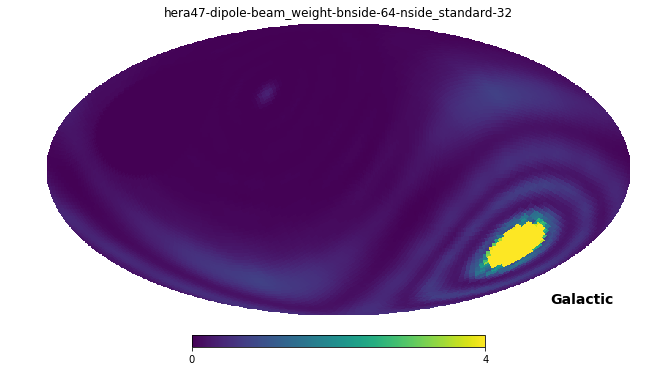

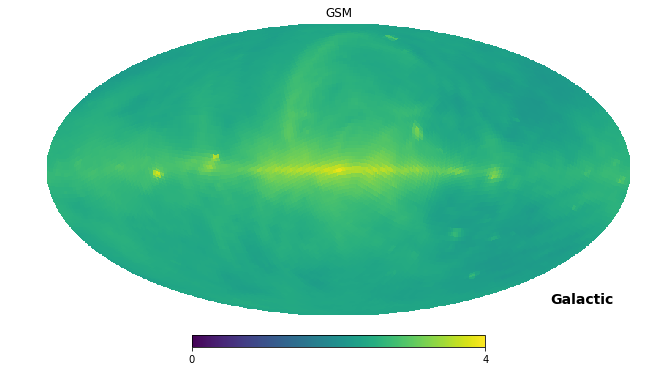

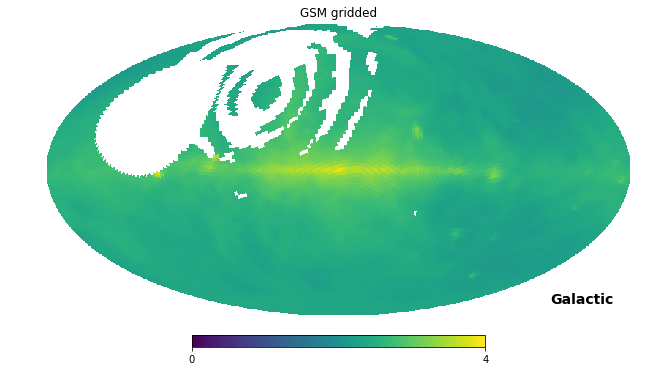

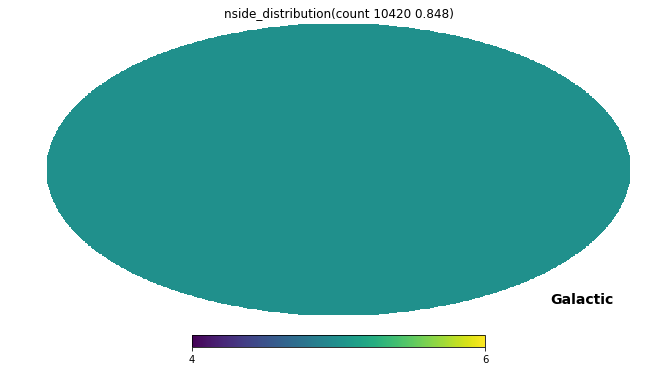

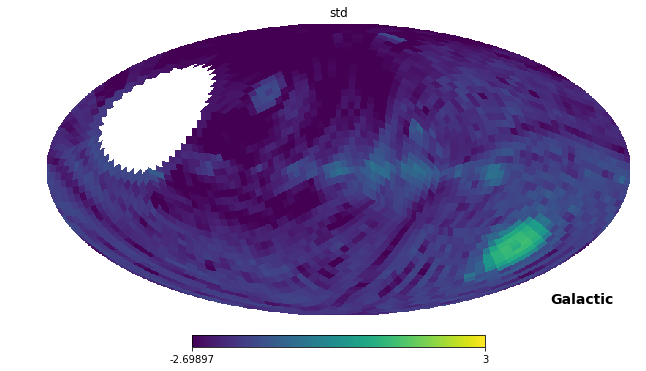

In [43]:
# final_index_filename = datadir + tag + '_%i.dyind%i_%.3f'%(nside_standard, npix, thresh)
# final_index.astype('float32').tofile(final_index_filename)
# sizes_filename = final_index_filename.replace('dyind', "dysiz")
# np.array(sizes).astype('float32').tofile(sizes_filename)
if plot_pixelization:
	##################################################################
	####################################sanity check########################
	###############################################################
	# npix = 0
	# for i in nside_distribution:
	# npix += i**2/nside_standard**2
	# print npix, len(thetas)
	stds = np.std((equatorial_GSM_standard * beam_weight).reshape(12 * nside_standard ** 2 / 4, 4), axis=1)
	plotcoord = 'CG'
    
	##################################################################
	####################################plotting########################
	###############################################################
	with warnings.catch_warnings():
		warnings.filterwarnings("ignore", category=RuntimeWarning)
		#plt.clf()
		plt.figure(50)
		hpv.mollview(beam_weight, min=0, max=4, coord=plotcoord, title='%s-dipole-beam_weight-bnside-%s-nside_standard-%s'%(INSTRUMENT, bnside, nside_standard), nest=True)
		plt.savefig(script_dir + '/../Output/%s-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log10(equatorial_GSM_standard), min=0, max=4, coord=plotcoord, title='GSM', nest=True)
		plt.savefig(script_dir + '/../Output/GSM-3C-for-%s-%s-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
		hpv.mollview(np.log10(sol2map(fake_solution)[:len(equatorial_GSM_standard)]), min=0, max=4, coord=plotcoord,
					 title='GSM gridded', nest=True)
		plt.savefig(script_dir + '/../Output/maskedfsol_GSM-3C-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log2(nside_distribution), min=np.log2(nside_start), max=np.log2(nside_standard),
					 coord=plotcoord,
					 title='nside_distribution(count %i %.3f)' % (len(thetas), float(len(thetas)) / (12 * nside_standard ** 2)), nest=True)
		plt.savefig(script_dir + '/../Output/nside_distribution-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log10(stds / abs_thresh), min=np.log10(thresh) - 3, max=3, coord=plotcoord, title='std',
					 nest=True)
		plt.savefig(script_dir + '/../Output/stds-beam_weight_GSM-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		plt.show(block=False)
		#plt.gcf().clear()

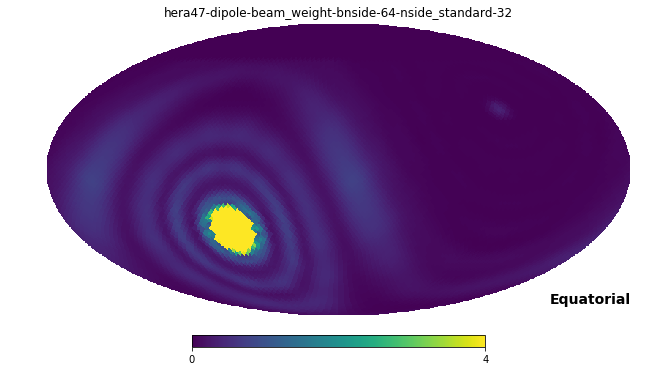

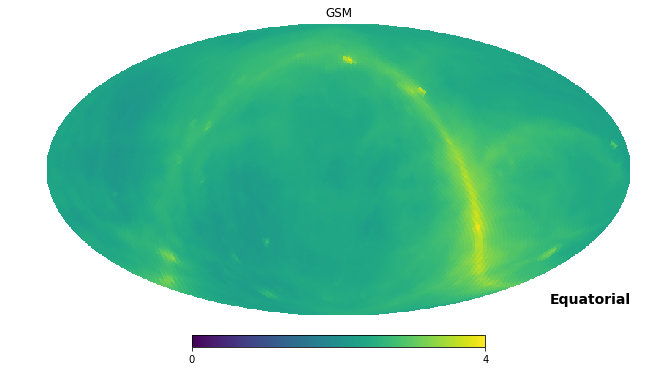

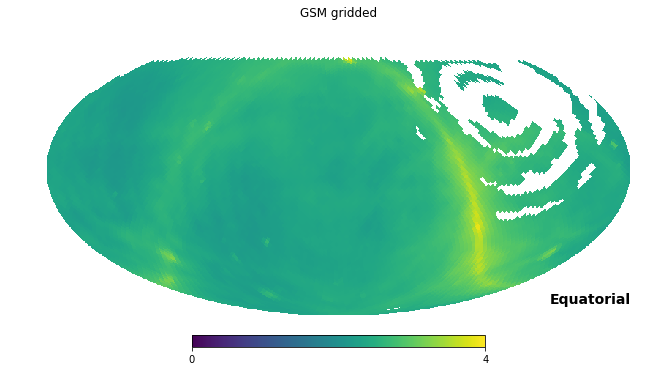

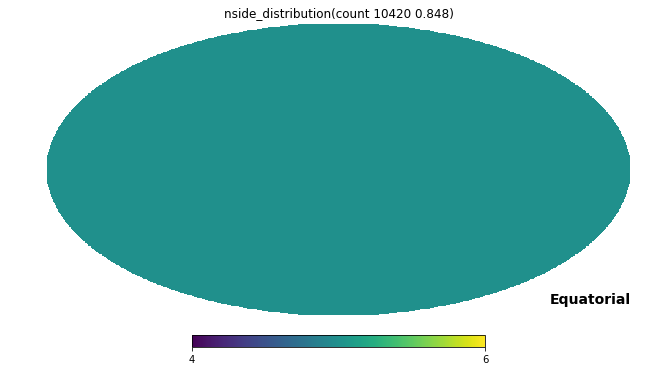

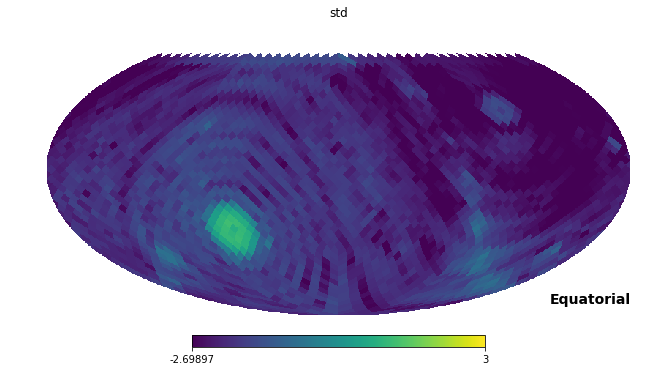

In [44]:
if plot_pixelization:
	##################################################################
	####################################sanity check########################
	###############################################################
	# npix = 0
	# for i in nside_distribution:
	# npix += i**2/nside_standard**2
	# print npix, len(thetas)

	stds = np.std((equatorial_GSM_standard * beam_weight).reshape(12 * nside_standard ** 2 / 4, 4), axis=1)
	plotcoord = 'C'
	##################################################################
	####################################plotting########################
	###############################################################
	with warnings.catch_warnings():
		warnings.filterwarnings("ignore", category=RuntimeWarning)
		#plt.clf()
		plt.figure(50)
		hpv.mollview(beam_weight, min=0, max=4, coord=plotcoord, title='%s-dipole-beam_weight-bnside-%s-nside_standard-%s'%(INSTRUMENT, bnside, nside_standard), nest=True)
		plt.savefig(script_dir + '/../Output/%s-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log10(equatorial_GSM_standard), min=0, max=4, coord=plotcoord, title='GSM', nest=True)
		plt.savefig(script_dir + '/../Output/GSM-3C-for-%s-%s-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
		hpv.mollview(np.log10(sol2map(fake_solution)[:len(equatorial_GSM_standard)]), min=0, max=4, coord=plotcoord,
					 title='GSM gridded', nest=True)
		plt.savefig(script_dir + '/../Output/maskedfsol_GSM-3C-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log2(nside_distribution), min=np.log2(nside_start), max=np.log2(nside_standard),
					 coord=plotcoord,
					 title='nside_distribution(count %i %.3f)' % (len(thetas), float(len(thetas)) / (12 * nside_standard ** 2)), nest=True)
		plt.savefig(script_dir + '/../Output/nside_distribution-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log10(stds / abs_thresh), min=np.log10(thresh) - 3, max=3, coord=plotcoord, title='std',
					 nest=True)
		plt.savefig(script_dir + '/../Output/stds-beam_weight_GSM-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		plt.show(block=False)
		#plt.gcf().clear()

In [45]:
##################################################################
####################compute dynamic A matrix########################
###############################################################
A_tag = 'A_dI'
A_filename = A_tag + '_u%i_t%i_p%i_n%i_%i_b%i_%.3f_v%.1f' % (nUBL_used, nt_used, valid_npix, nside_start, nside_standard, bnside, thresh, A_version)
A_path = datadir + tag + A_filename
AtNiA_tag = 'AtNiA_N%s'%vartag
if not fit_for_additive:
	AtNiA_tag += "_noadd"
elif crosstalk_type == 'autocorr':
	AtNiA_tag += "_autocorr"
if pre_ampcal:
	AtNiA_tag += "_ampcal"
AtNiA_filename = AtNiA_tag + A_filename
AtNiA_path = datadir + tag + AtNiA_filename
if os.path.isfile(AtNiA_path) and AtNiA_only and not force_recompute:
	sys.exit(0)


def get_A(additive_A=None):
	if os.path.isfile(A_path) and not force_recompute:
		print "Reading A matrix from %s" % A_path
		sys.stdout.flush()
		A = np.fromfile(A_path, dtype='complex128').reshape((nUBL_used, 2, nt_used, valid_npix + 4 * nUBL_used))
	else:

		print "Computing A matrix..."
		sys.stdout.flush()
		A = np.empty((nUBL_used, 2, nt_used, valid_npix + 4 * nUBL_used), dtype='complex128')
		timer = time.time()
		for n in range(valid_npix):
			ra = phis[n]
			dec = PI / 2 - thetas[n]
			print "\r%.1f%% completed, %f minutes left" % (
			100. * float(n) / (valid_npix), float(valid_npix - n) / (n + 1) * (float(time.time() - timer) / 60.)),
			sys.stdout.flush()

			A[:, 0, :, n] = vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ_x, tlist=lsts) / 2 #xx and yy are each half of I
			A[:, -1, :, n] = vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ_y, tlist=lsts) / 2



		print "%f minutes used" % (float(time.time() - timer) / 60.)
		sys.stdout.flush()
		A.tofile(A_path)

	# #put in autocorr regardless of whats saved on disk
	# for i in range(nUBL_used):
	#     for p in range(2):
	#         A[i, p, :, valid_npix + 4 * i + 2 * p] = 1. * autocorr_vis_normalized[p]
	#         A[i, p, :, valid_npix + 4 * i + 2 * p + 1] = 1.j * autocorr_vis_normalized[p]

	A.shape = (nUBL_used * 2 * nt_used, A.shape[-1])
	if not fit_for_additive:
		A = A[:, :valid_npix]
	else:
		A[:, valid_npix:] = additive_A[:, 1:]
	# Merge A
	try:
		return np.concatenate((np.real(A), np.imag(A))).astype('complex128')
	except MemoryError:
		print "Not enough memory, concatenating A on disk ", A_path + 'tmpre', A_path + 'tmpim',
		sys.stdout.flush()
		Ashape = list(A.shape)
		Ashape[0] = Ashape[0] * 2
		np.real(A).tofile(A_path + 'tmpre')
		np.imag(A).tofile(A_path + 'tmpim')
		del (A)
		os.system("cat %s >> %s" % (A_path + 'tmpim', A_path + 'tmpre'))

		os.system("rm %s" % (A_path + 'tmpim'))
		A = np.fromfile(A_path + 'tmpre', dtype='complex128').reshape(Ashape)
		os.system("rm %s" % (A_path + 'tmpre'))
		print "done."
		sys.stdout.flush()
		return A.astype('complex128')

if not fit_for_additive:
	A = get_A()
else:
	A = get_A(additive_A)
	
Ashape0, Ashape1 = A.shape

# for ipix in hpf.ang2pix(nside_standard, thetas, phis, nest=True):
#     if

print "Memory usage: %.3fMB" % (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1000)
sys.stdout.flush()

print "Memory usage: %.3fMB" % (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1000)
sys.stdout.flush()

sys.stdout.flush()


def get_vis_normalization(data, clean_sim_data):
	a = np.linalg.norm(data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1]), axis=0).flatten()
	b = np.linalg.norm(clean_sim_data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1]), axis=0).flatten()
	return a.dot(b) / b.dot(b)


Computing A matrix...


78.1% completed, 0.196904 minutes left

100.0% completed, 0.000082 minutes left                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [46]:
tlist

array([15.01222222, 15.01527778, 15.01833333, 15.02138889, 15.02416667,
       15.02722222, 15.03027778, 15.03333333, 15.03611111, 15.03916667,
       15.04222222, 15.045     , 15.04805556, 15.05111111, 15.05416667,
       15.05694444, 15.06      , 15.06305556, 15.06611111, 15.06888889,
       15.07194444, 15.075     , 15.07805556, 15.08083333, 15.08388889,
       15.08694444, 15.09      , 15.09277778, 15.09583333, 15.09888889,
       15.10166667, 15.10472222, 15.10777778, 15.11083333, 15.11361111,
       15.11666667, 15.11972222, 15.12277778, 15.12555556, 15.12861111,
       15.13166667, 15.13472222, 15.1375    , 15.14055556, 15.14361111,
       15.14666667, 15.14944444, 15.1525    , 15.15555556, 15.15833333,
       15.16138889, 15.16444444, 15.1675    , 15.17027778, 15.17333333,
       15.17638889, 15.17944444, 15.18222222, 15.18527778, 15.18833333])

In [47]:
Integration_Time
np.sum(Ni**-1)**.5

(1680.240251483257+0j)

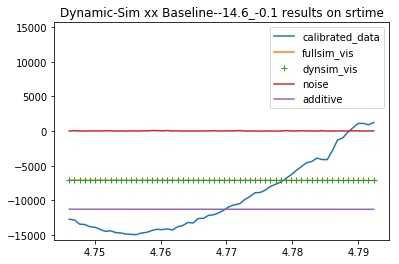

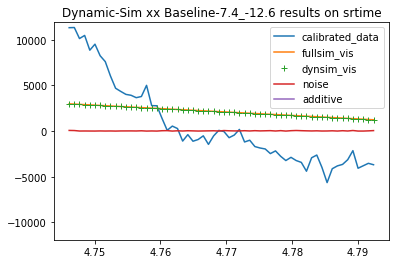

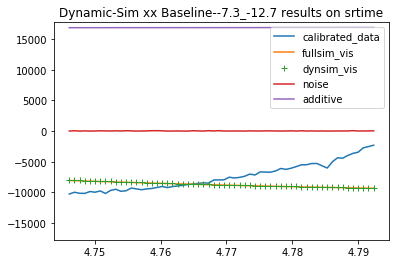

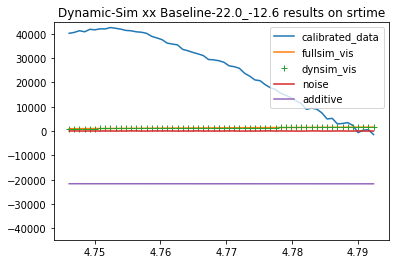

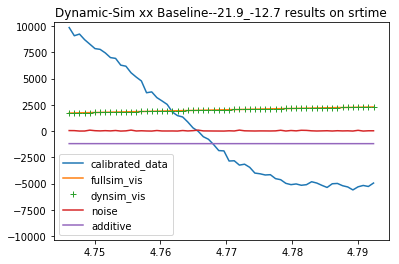

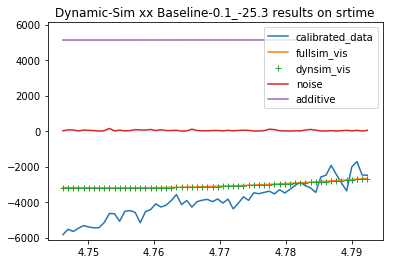

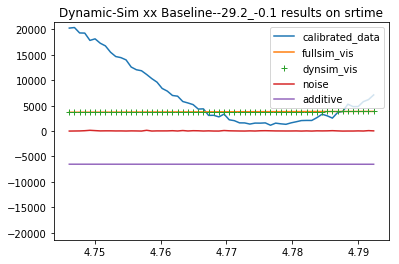

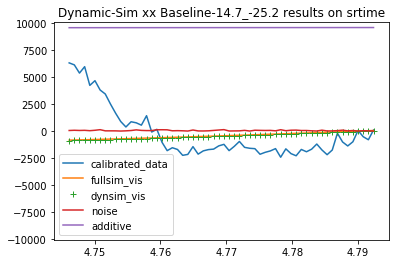

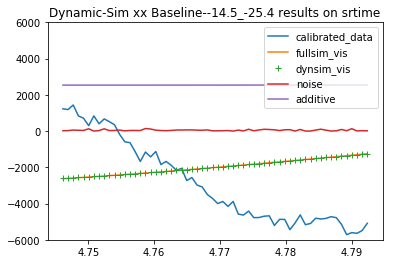

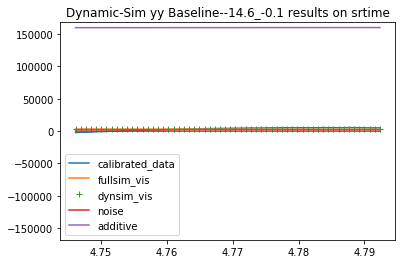

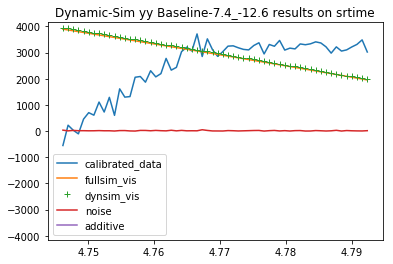

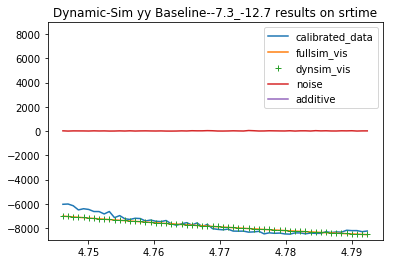

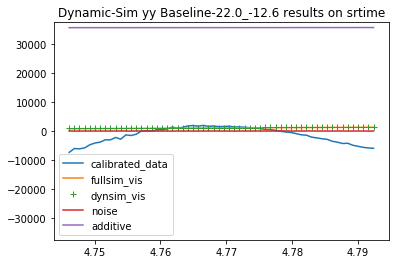

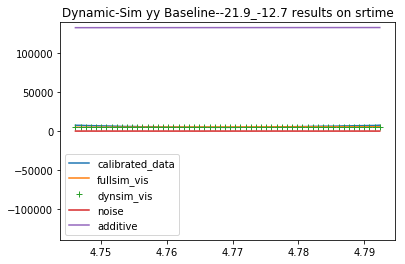

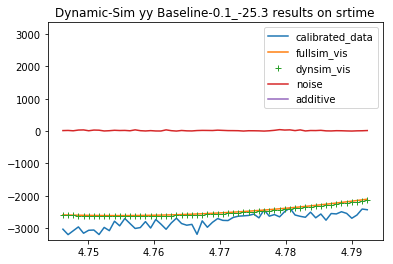

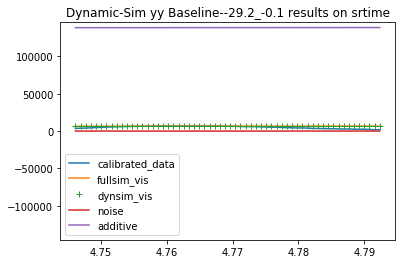

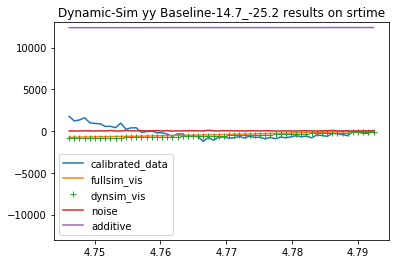

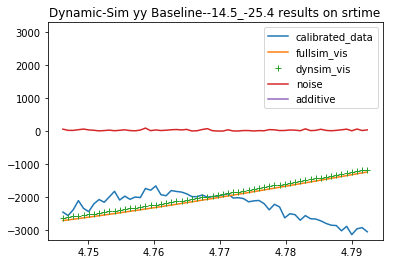

total deviation between dynamic and full sim compared to sim:  0.004945533540446285
total deviation between dynamic and full sim compared to data noise:  (1.4422799469138723+0j)


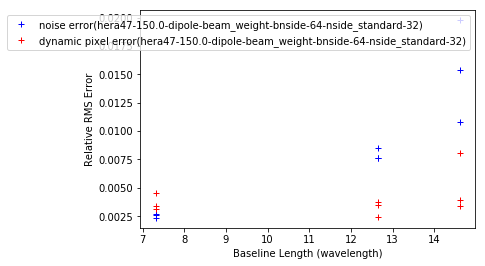

Normalization from visibilities 1.1267634644835196


In [48]:
##############
# simulate visibilities according to the pixelized A matrix
##############
clean_sim_data = A.dot(fake_solution.astype(A.dtype))

if plot_data_error:
	cdata = get_complex_data(data)
	cdynamicmodel = get_complex_data(clean_sim_data)
	cNi = get_complex_data(Ni)
	if pre_calibrate:
		cadd = get_complex_data(additive_term)

	fun = np.imag
	srt = sorted((lsts - lst_offset)%24.+lst_offset)
	asrt = np.argsort((lsts - lst_offset)%24.+lst_offset)
	pncol = min(int(60. / (srt[-1] - srt[0])), 12)
	us = ubl_sort['x'][::len(ubl_sort['x'])/pncol] if len(ubl_sort['x'])/pncol >=1 else ubl_sort['x']
	#plt.clf()
#	plt.figure(60)
#	for p in range(2):
#		for nu, u in enumerate(us):
#
#			plt.subplot(2, len(us), len(us) * p + nu + 1)
#			plt.plot(srt, fun(cdata[u, p][asrt]))
#			plt.plot(srt, fun(fullsim_vis[u, p][asrt]))
#			plt.plot(srt, fun(cdynamicmodel[u, p][asrt]))
#			plt.plot(srt, fun(cNi[u, p][asrt])**-.5)
#			if pre_calibrate:
#				plt.plot(srt, fun(cadd[u, p][asrt]))
#			data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), 5 * np.max(np.abs(fun(cNi[u, p])))])
#			plt.title("%.1f,%.1f"%(used_common_ubls[u, 0], used_common_ubls[u, 1]))
#			plt.ylim([-1.05*data_range, 1.05*data_range])
#
#	print "total deviation between dynamic and full sim compared to sim", la.norm(fullsim_vis - cdynamicmodel) / la.norm(fullsim_vis)
#	print "total deviation between dynamic and full sim compared to data noise", la.norm(fullsim_vis - cdynamicmodel) / np.sum(Ni**-1)**.5
#	plt.savefig(script_dir + '/../Output/data_error_dynamic-%s-dipole-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, bnside, nside_standard))
#	plt.show(block=False)
	
	figure_D={}
	for p in range(2):
		for nu, u in enumerate(us):
			plt.figure(6000+100*p+nu)
			#plt.subplot(2, len(us), len(us) * p + nu + 1)
			figure_D[1], = plt.plot(srt, fun(cdata[u, p][asrt]), label='calibrated_data')
			figure_D[2], = plt.plot(srt, fun(fullsim_vis[u, p][asrt]), label='fullsim_vis')
			figure_D[3], = plt.plot(srt, fun(cdynamicmodel[u, p][asrt]), '+', label='dynsim_vis')
			figure_D[4], = plt.plot(srt, fun(cNi[u, p][asrt])**-.5, label='Ni')
			if pre_calibrate:
				figure_D[5], = plt.plot(srt, fun(cadd[u, p][asrt]), label='additive')
				data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), np.max(np.abs(fun(cdynamicmodel[u, p]))), np.max(fun(cadd[u, p]))]) # 5 * np.max(np.abs(fun(cNi[u, p])))
			else:	
				data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), np.max(np.abs(fun(cdynamicmodel[u, p])))]) # 5 * np.max(np.abs(fun(cNi[u, p])))
			plt.title("Dynamic-Sim %s Baseline-%.1f_%.1f results on srtime"%(['xx','yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
			plt.ylim([-1.05*data_range, 1.05*data_range])
			if pre_calibrate:
				plt.legend(handles=[figure_D[1], figure_D[2], figure_D[3], figure_D[4], figure_D[5]], labels=['calibrated_data', 'fullsim_vis', 'dynsim_vis', 'noise', 'additive'], loc=0)
			else:
				plt.legend(handles=[figure_D[1], figure_D[2], figure_D[3], figure_D[4]], labels=['calibrated_data', 'fullsim_vis', 'dynsim_vis', 'noise'], loc=0)
			plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-precal_data_error-Dynamic_Vis-%s-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, used_common_ubls[u, 0], used_common_ubls[u, 1], ['xx','yy'][p], freq, bnside, nside_standard))
			plt.show(block=False)
			#plt.clf()
			#plt.gcf().clear()
	print "total deviation between dynamic and full sim compared to sim: ", la.norm(fullsim_vis - cdynamicmodel) / la.norm(fullsim_vis)
	print "total deviation between dynamic and full sim compared to data noise: ", la.norm(fullsim_vis - cdynamicmodel) / np.sum(Ni**-1)**.5
	
	plt.figure(70)
	try:
		fullsim_vis2 = 4 * np.fromfile(datadir + tag + '_p2_u%i_t%i_nside%i_bnside%i.simvis'%(nUBL_used+1, nt_used, nside_standard / 2, bnside), dtype='complex128').reshape((2, nUBL_used+1, nt_used))[:, :-1].transpose((1, 0 ,2))
		plt.plot(la.norm(used_common_ubls, axis=-1)*freq/C, la.norm(fullsim_vis - fullsim_vis2, axis=-1)[:, 0] / la.norm(fullsim_vis, axis=-1)[:, 0], 'g+', label='nside error(%s-dipole-beam_weight-bnside-%s-nside_standard-%s)'%(INSTRUMENT, bnside, nside_standard))
		plt.savefig(script_dir + '/../Output/nside_error-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, bnside, nside_standard))
	except:
		try:
			fullsim_vis2 = .25 * np.fromfile(datadir + tag + '_p2_u%i_t%i_nside%i_bnside%i.simvis'%(nUBL_used+1, nt_used, nside_standard * 2, bnside), dtype='complex128').reshape((2, nUBL_used+1, nt_used))[:, :-1].transpose((1, 0 ,2))
			plt.plot(la.norm(used_common_ubls, axis=-1)*freq/C, la.norm(fullsim_vis - fullsim_vis2, axis=-1)[:, 0] / la.norm(fullsim_vis, axis=-1)[:, 0], 'g+', label='nside error(%s-dipole-beam_weight-bnside-%s-nside_standard-%s)'%(INSTRUMENT, bnside, nside_standard))
			plt.savefig(script_dir + '/../Output/nside_error-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, bnside, nside_standard))
		except:
			pass
	#plt.clf()
	plt.plot(la.norm(used_common_ubls, axis=-1)*freq/C, np.sum(2. / np.real(get_complex_data(Ni)), axis=-1)[:, 0]**.5 / la.norm(fullsim_vis, axis=-1)[:, 0], 'b+', label='noise error(%s-%s-dipole-beam_weight-bnside-%s-nside_standard-%s)'%(INSTRUMENT, freq, bnside, nside_standard))
#	plt.legend()
#	plt.xlabel('Baseline Length (wavelength)')
#	plt.ylabel('Relative RMS Error')
	plt.savefig(script_dir + '/../Output/noise_error-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, bnside, nside_standard))
#	plt.show(block=False)
#	plt.gcf().clear()
	#plt.clf()
	plt.plot(la.norm(used_common_ubls, axis=-1)*freq/C, la.norm(fullsim_vis - cdynamicmodel, axis=-1)[:, 0] / la.norm(fullsim_vis, axis=-1)[:, 0], 'r+', label='dynamic pixel error(%s-%s-dipole-beam_weight-bnside-%s-nside_standard-%s)'%(INSTRUMENT, freq, bnside, nside_standard))
	plt.legend(loc=0)
	plt.xlabel('Baseline Length (wavelength)')
	plt.ylabel('Relative RMS Error')
	plt.savefig(script_dir + '/../Output/dynamic_pixel_error-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, bnside, nside_standard))
	plt.show(block=False)
	#plt.gcf().clear()


vis_normalization = get_vis_normalization(data, stitch_complex_data(fullsim_vis))
print "Normalization from visibilities", vis_normalization

Del=True
if Del:
	try:
		del(cdata)
		del(cNi)
		del(cdynamicmodel)
	except:
		pass

sys.stdout.flush()



In [49]:
##renormalize the model
fake_solution *= vis_normalization # GSM Masked and being Normalized (abs calibration), Clean
clean_sim_data *= vis_normalization # Dynamic Simulated, Clean, being Normalized (abs calibration)
fullsim_vis *= vis_normalization # Full Simulated, Clean, being Normalized (abs calibration)
sim_data = stitch_complex_data(fullsim_vis) + np.random.randn(len(data)) / Ni ** .5 # Full Simulated, being Normalized (abs calibration), Noise
# "data" is Calibrated Full Simulated Visibilities

#add additive term
if fit_for_additive:
	sim_data.shape = (2, nUBL_used, 2, nt_used)
	sim_additive = np.random.randn(2, nUBL_used, 2) * np.median(np.abs(data)) / 2.
	sim_data = sim_data + np.array([np.outer(sim_additive[..., p], autocorr_vis_normalized[p]).reshape((2, nUBL_used, nt_used)) for p in range(2)]).transpose((1, 2, 0, 3))#sim_additive[..., None]
	sim_data = sim_data.flatten()


In [50]:
# compute AtNi.y
AtNi_data = np.transpose(A).dot((data * Ni).astype(A.dtype))
AtNi_sim_data = np.transpose(A).dot((sim_data * Ni).astype(A.dtype))
AtNi_clean_sim_data = np.transpose(A).dot((clean_sim_data * Ni).astype(A.dtype))


In [51]:
# compute S
print "computing S...",
sys.stdout.flush()
timer = time.time()

#diagonal of S consists of S_diag_I and S-diag_add
if S_type == 'none':
	S_diag = np.ones(Ashape1) * np.max(equatorial_GSM_standard)**2 * 1.e12
else:
	if 'lowI' in S_type:
		I_supress = 25.
	elif 'minI' in S_type:
		I_supress = 250.
	elif 'min2I' in S_type:
		I_supress = 2500
	elif 'min3I' in S_type:
		I_supress = 2.5*1.e4
	elif 'min4I' in S_type:
		I_supress = 2.5*1.e5
	elif 'min5I' in S_type:
		I_supress = 2.5*1.e6
	elif 'min6I' in S_type:
		I_supress = 2.5*1.e7
	elif 'min7I' in S_type:
		I_supress = 2.5*1.e8
	elif 'min8I' in S_type:
		I_supress = 2.5*1.e9
	elif 'min9I' in S_type:
		I_supress = 2.5*1.e10
	elif 'min10I' in S_type:
		I_supress = 2.5*1.e11
	elif 'maxI' in S_type:
		I_supress = 2.5*1.e-1
	elif 'ma2I' in S_type:
		I_supress = 2.5*1.e-2
	elif 'max3I' in S_type:
		I_supress = 2.5*1.e-3
	elif 'max4I' in S_type:
		I_supress = 2.5*1.e-4
	elif 'max5I' in S_type:
		I_supress = 2.5*1.e-5
	elif 'max6I' in S_type:
		I_supress = 2.5*1.e-6
	elif 'max7I' in S_type:
		I_supress = 2.5*1.e-7
	elif 'max8I' in S_type:
		I_supress = 2.5*1.e-8
	elif 'max9I' in S_type:
		I_supress = 2.5*1.e-9
	else:
		I_supress = 1.
		
	if 'Iuniform' in S_type:
		S_diag_I = (np.median(equatorial_GSM_standard) * sizes)**2 / I_supress
	else:
		S_diag_I = fake_solution_map ** 2 / I_supress  # np.array([[1+pol_frac,0,0,1-pol_frac],[0,pol_frac,pol_frac,0],[0,pol_frac,pol_frac,0],[1-pol_frac,0,0,1+pol_frac]]) / 4 * (2*sim_x_clean[i])**2

	data_max = np.transpose(np.percentile(np.abs(data.reshape((2, nUBL_used, 2, nt_used))), 95, axis=-1), (1, 2, 0)).flatten()
	if 'min2add' in S_type:
		add_supress = 1000000.
	elif 'minadd' in S_type:
		add_supress = 10000.
	elif 'lowadd' in S_type:
		add_supress = 100.
	else:
		add_supress = 1

	if 'adduniform' in S_type:
		S_diag_add = np.ones(nUBL_used * 4) * np.median(data_max)**2 / add_supress
	else:
		S_diag_add = data_max**2 / add_supress

	if not fit_for_additive:
		S_diag = S_diag_I.astype('complex128')
	else:
		S_diag = np.concatenate((S_diag_I, S_diag_add)).astype('complex128')
	print "Done."
	print "%f minutes used" % (float(time.time() - timer) / 60.)
	sys.stdout.flush()


computing S... Done.
0.000034 minutes used


In [52]:
# compute (AtNiA+Si)i
precision = 'complex128'
AtNiAi_tag = 'AtNiASii'
if not fit_for_additive:
	AtNiAi_version = 0.3
elif crosstalk_type == 'autocorr':
	AtNiAi_version = 0.2
else:
	AtNiAi_version = 0.1
if pre_ampcal:
	AtNiAi_version += 1.
# rcond_list = 10.**np.arange(-3., -0., 1.)

AtNiAi_candidate_files = glob.glob(datadir + tag + AtNiAi_tag + '_S%s_RE*_N%s_v%.1f'%(S_type, vartag, AtNiAi_version) + A_filename)
if len(AtNiAi_candidate_files) > 0 and not force_recompute_AtNiAi and not force_recompute and not force_recompute_S and not AtNiA_only:
	rcond = 10**min([float(fn.split('_RE')[1].split('_N')[0]) for fn in AtNiAi_candidate_files])

	AtNiAi_filename = AtNiAi_tag + '_S%s_RE%.1f_N%s_v%.1f'%(S_type, np.log10(rcond), vartag, AtNiAi_version) + A_filename
	AtNiAi_path = datadir + tag + AtNiAi_filename

	print "Reading Regularized AtNiAi...",
	sys.stdout.flush()
	AtNiAi = sv.InverseCholeskyMatrix.fromfile(AtNiAi_path, len(S_diag), precision)
else:
	if os.path.isfile(AtNiA_path) and not force_recompute:
		print "Reading AtNiA...",
		sys.stdout.flush()
		AtNiA = np.fromfile(AtNiA_path, dtype=precision).reshape((Ashape1, Ashape1))
	else:
		print "Allocating AtNiA..."
		sys.stdout.flush()
		timer = time.time()
		AtNiA = np.zeros((A.shape[1], A.shape[1]), dtype=precision)
		print "Computing AtNiA...", datetime.datetime.now()
		sys.stdout.flush()
		ATNIA(A, Ni, AtNiA)
		print "%f minutes used" % (float(time.time() - timer) / 60.)
		sys.stdout.flush()
		AtNiA.tofile(AtNiA_path)
	if AtNiA_only:
		sys.exit(0)
	del (A)
	AtNiA_diag = np.diagonal(AtNiA)
	print "Computing Regularized AtNiAi, %s, expected time %.1f min"%(datetime.datetime.now(), 88. * (len(S_diag) / 4.6e4)**3.),
	sys.stdout.flush()
	timer = time.time()
	# if la.norm(S) != la.norm(np.diagonal(S)):
	#     raise Exception("Non-diagonal S not supported yet")

	for rcond in rcond_list:
		#add Si on top of AtNiA without renaming AtNiA to save memory
		maxAtNiA = np.max(AtNiA)
		AtNiA.shape = (len(AtNiA) ** 2)
		if Add_S_diag:
			AtNiA[::len(S_diag) + 1] += 1./S_diag

		print 'trying', rcond,
		sys.stdout.flush()
		try:
			AtNiAi_filename = AtNiAi_tag + '_S%s_RE%.1f_N%s_v%.1f'%(S_type, np.log10(rcond), vartag, AtNiAi_version) + A_filename
			AtNiAi_path = datadir + tag + AtNiAi_filename
			if Add_Rcond:
				AtNiA[::len(S_diag) + 1] += maxAtNiA * rcond
			AtNiA.shape = (Ashape1, Ashape1)
			AtNiAi = sv.InverseCholeskyMatrix(AtNiA).astype(precision)
			del(AtNiA)
			AtNiAi.tofile(AtNiAi_path, overwrite=True)
			print "%f minutes used" % (float(time.time() - timer) / 60.)
			print "regularization stength", (maxAtNiA * rcond)**-.5, "median GSM ranges between", np.median(equatorial_GSM_standard) * min(sizes), np.median(equatorial_GSM_standard) * max(sizes)
			break
		except:
			AtNiA[::len(S_diag) + 1] -= maxAtNiA * rcond
			continue

sys.stdout.flush()


Allocating AtNiA...
Computing AtNiA... 2018-03-08 17:34:25.578899
Estimated time for A 2160 by 10456 3.06992844288 minutes 0/20: 0.0mins 1/20: 0.0mins 2/20: 0.0mins 3/20: 0.0mins 4/20: 0.0mins 5/20: 0.0mins 6/20: 0.0mins 7/20: 0.0mins 8/20: 0.0mins 9/20: 0.0mins 10/20: 0.1mins 11/20: 0.1mins 12/20: 0.1mins 13/20: 0.1mins 14/20: 0.1mins 15/20: 0.1mins 16/20: 0.1mins 17/20: 0.0mins 18/20: 0.1mins 19/20: 0.1mins 0.938024 minutes used
Computing Regularized AtNiAi, 2018-03-08 17:35:26.335051, expected time 1.0 min trying 0.001 1.024158 minutes used
regularization stength (0.0028371180535080283+0j) median GSM ranges between 284.4070430340813 284.4070430340813


In [53]:
S_type
I_supress

1.0

Applying Regularized AtNiAi... Memory usage: 7199555.000MB
Reading A matrix from /Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data/../../../simulate_visibilities/scripts/../Output/hera47-150.000000-ampcal-A_dI_u9_t60_p10420_n32_32_b64_2.000_v1.0


Casting complex values to real discards the imaginary part


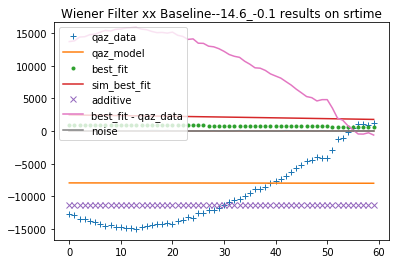

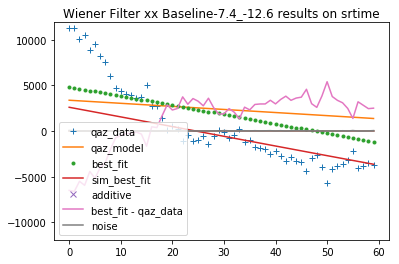

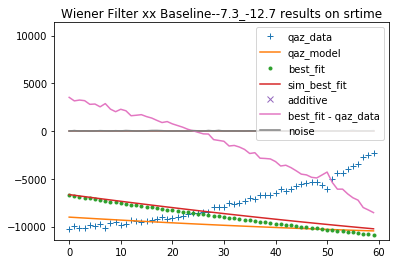

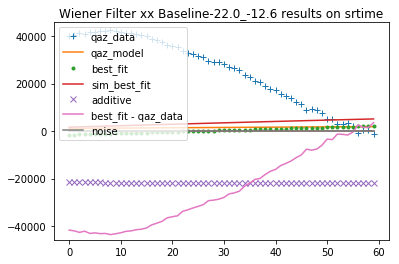

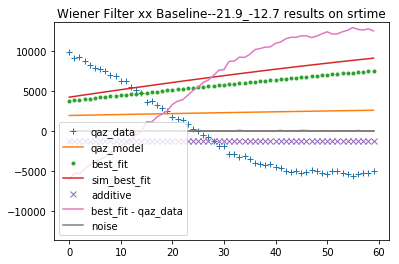

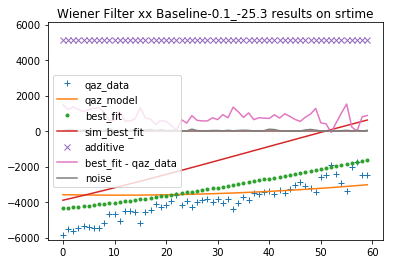

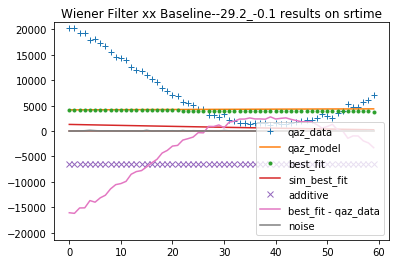

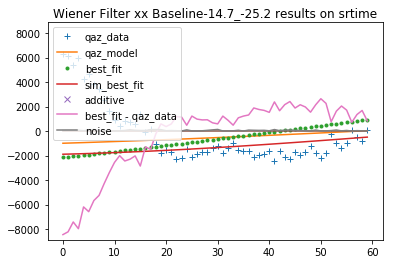

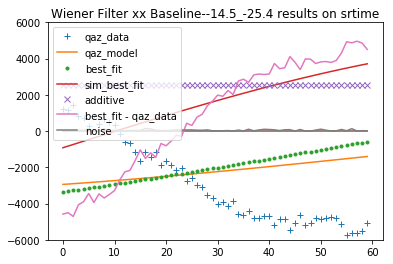

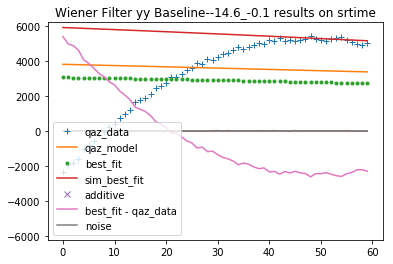

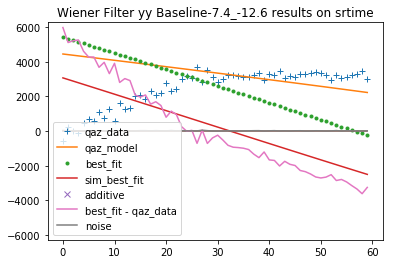

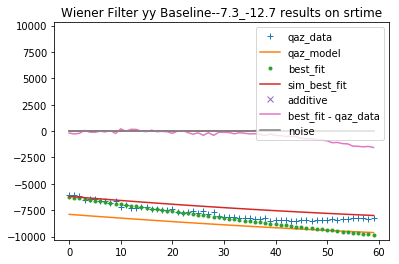

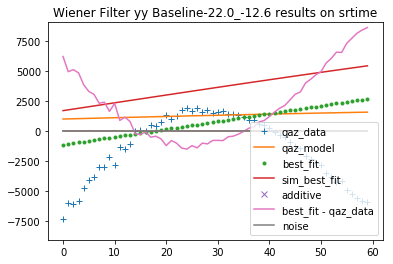

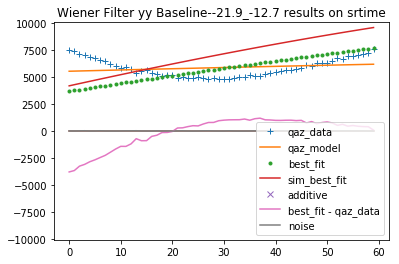

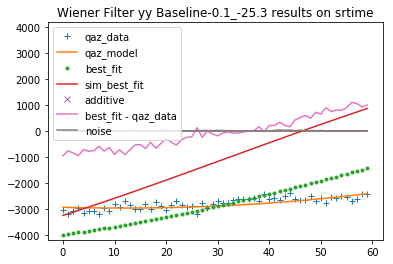

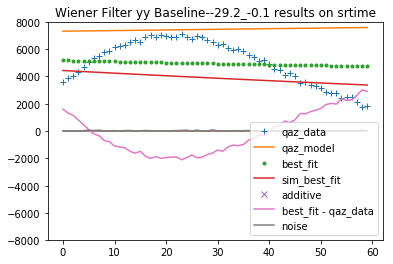

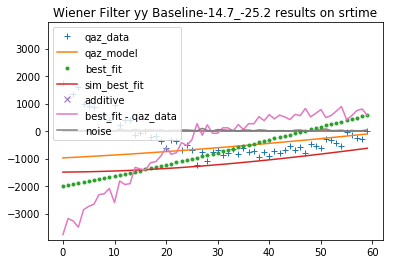

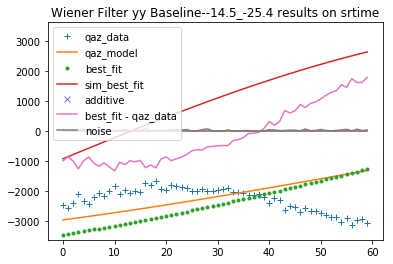

In [54]:
#####apply wiener filter##############
print "Applying Regularized AtNiAi...",
sys.stdout.flush()
w_solution = AtNiAi.dotv(AtNi_data)
w_GSM = AtNiAi.dotv(AtNi_clean_sim_data)
w_sim_sol = AtNiAi.dotv(AtNi_sim_data)
print "Memory usage: %.3fMB" % (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1000)
sys.stdout.flush()

del (AtNiAi)

if not fit_for_additive:
	A = get_A()
else:
	A = get_A(additive_A)
	
best_fit = A.dot(w_solution.astype(A.dtype)) # Reversely-Calculated-masked-GSM Dynamically simulated Visibilities.
best_fit_no_additive = A[..., :valid_npix].dot(w_solution[:valid_npix].astype(A.dtype))

sim_best_fit = A.dot(w_sim_sol.astype(A.dtype))
sim_best_fit_no_additive = A[..., :valid_npix].dot(w_sim_sol[:valid_npix].astype(A.dtype))

if plot_data_error:
	qaz_model = (clean_sim_data).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1]) # Dynamic Simulated, Clean, being Normalized    # * vis_normalization
	qaz_data = np.copy(data).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1]) # Full Simulated, Calibrated, reference for normalization
	if pre_calibrate:
		qaz_add = np.copy(additive_term).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])
	pncol = min(int(60. / (srt[-1] - srt[0])), 12)
	us = ubl_sort['x'][::len(ubl_sort['x'])/pncol] if len(ubl_sort['x'])/pncol >=1 else ubl_sort['x'] #[::max(1, len(ubl_sort['x'])/70)]
	best_fit.shape = (2, data_shape['xx'][0], 2, data_shape['xx'][1])
	best_fit_no_additive.shape = (2, data_shape['xx'][0], 2, data_shape['xx'][1])
	sim_best_fit.shape = (2, data_shape['xx'][0], 2, data_shape['xx'][1])
	ri = 1
	#plt.clf()

	figure_W = {}
	for p in range(2):
		
		for nu, u in enumerate(us):
			plt.figure(8000 + 10*p + nu)
			#plt.subplot(6, (len(us) + 5) / 6, nu + 1)
			# plt.errorbar(range(nt_used), qaz_data[ri, u, p], yerr=Ni.reshape((2, nUBL_used, 2, nt_used))[ri, u, p]**-.5)
			figure_W[1], = plt.plot(qaz_data[ri, u, p],'+')
			figure_W[2], = plt.plot(qaz_model[ri, u, p],'-')
			figure_W[3], = plt.plot(best_fit[ri, u, p],'.')
			figure_W[4], = plt.plot(sim_best_fit[ri, u, p])
			if pre_calibrate:
				figure_W[5], = plt.plot(qaz_add[ri, u, p],'x')
			if fit_for_additive:
				figure_W[6], = plt.plot(autocorr_vis_normalized[p] * sol2additive(w_solution)[p, u, ri])
			figure_W[7], = plt.plot(best_fit[ri, u, p] - qaz_data[ri, u, p])
			figure_W[8], = plt.plot(Ni.reshape((2, nUBL_used, 2, nt_used))[ri, u, p]**-.5)
			if pre_calibrate:
				data_range = np.max([np.max(np.abs(qaz_data[ri, u, p])), np.max(np.abs(qaz_model[ri, u, p])), np.max(np.abs(best_fit[ri, u, p])), np.max(np.abs(sim_best_fit[ri, u, p])), np.max(np.abs((best_fit[ri, u, p] - qaz_data[ri, u, p])))]) # np.max(np.abs(qaz_add[ri, u, p])), #, 5 * np.max(np.abs(fun(cNi[u, p])))
				plt.legend(handles=[figure_W[1], figure_W[2], figure_W[3], figure_W[4], figure_W[5], figure_W[7], figure_W[8]], labels=['qaz_data', 'qaz_model', 'best_fit', 'sim_best_fit', 'additive', 'best_fit - qaz_data', 'noise'], loc=0)
			else:
				data_range = np.max([np.max(np.abs(qaz_data[ri, u, p])), np.max(np.abs(qaz_model[ri, u, p])), np.max(np.abs(best_fit[ri, u, p])), np.max(np.abs(sim_best_fit[ri, u, p])), np.max(np.abs((best_fit[ri, u, p] - qaz_data[ri, u, p])))]) #, 5 * np.max(np.abs(fun(cNi[u, p])))
				plt.legend(handles=[figure_W[1], figure_W[2], figure_W[3], figure_W[4], figure_W[7], figure_W[8]], labels=['qaz_data', 'qaz_model', 'best_fit', 'sim_best_fit', 'best_fit - qaz_data', 'noise'], loc=0)
			plt.ylim([-1.05*data_range, 1.05*data_range])
			#plt.title("%.1f,%.1f,%.1e"%(used_common_ubls[u, 0], used_common_ubls[u, 1], la.norm(best_fit[ri, u, p] - qaz_data[ri, u, p])))
			plt.title("Wiener Filter %s Baseline-%.1f_%.1f results on srtime"%(['xx','yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
			plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-precal_data_error-WienerFilter_Vis-%s-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, used_common_ubls[u, 0], used_common_ubls[u, 1], ['xx','yy'][p], freq, bnside, nside_standard))
			plt.show(block=False)
			#plt.gcf().clear()
			#plt.close()

# Del=True
# if Del:
# 	try:
# 		#del(additive_A)
# 		#del(real_additive_A)
# 	except:
# 		pass

sys.stdout.flush()

In [55]:
def plot_IQU(solution, title, col, shape=(2,3), coord='C'):
	# Es=solution[np.array(final_index).tolist()].reshape((4, len(final_index)/4))
	# I = Es[0] + Es[3]
	# Q = Es[0] - Es[3]
	# U = Es[1] + Es[2]
	I = sol2map(solution)
	plotcoordtmp = coord
	hpv.mollview(np.log10(I), min=0, max=4, coord=plotcoordtmp, title=title, nest=True, sub=(shape[0], shape[1], col))
	#if col == shape[0] * shape[1]:
		#plt.show(block=False)

def plot_IQU_unlimit(solution, title, col, shape=(2,3), coord='C'):
	# Es=solution[np.array(final_index).tolist()].reshape((4, len(final_index)/4))
	# I = Es[0] + Es[3]
	# Q = Es[0] - Es[3]
	# U = Es[1] + Es[2]
	I = sol2map(solution)
	plotcoordtmp = coord
	hpv.mollview(np.log10(I), coord=plotcoordtmp, title=title, nest=True, sub=(shape[0], shape[1], col))
	#if col == shape[0] * shape[1]:
		#plt.show(block=False)


In [56]:
rescale_factor = np.max(np.abs(fake_solution))/ np.max(np.abs(w_solution))

In [57]:
%matplotlib inline

In [58]:
print('Number of Positive w_solution Pixels: %s'%len(w_solution[w_solution>=0]))
print('Number of Positive w_GSM Pixels: %s'%len(w_GSM[w_GSM>=0]))
print('Number of Positive w_sim Pixels: %s'%len(w_sim_sol[w_sim_sol>=0]))
print('Number of Positive GSM Pixels: %s'%len(fake_solution[fake_solution>=0]))

Number of Positive w_solution Pixels: 5764
Number of Positive w_GSM Pixels: 5802
Number of Positive w_sim Pixels: 5814
Number of Positive GSM Pixels: 10456


divide by zero encountered in log10


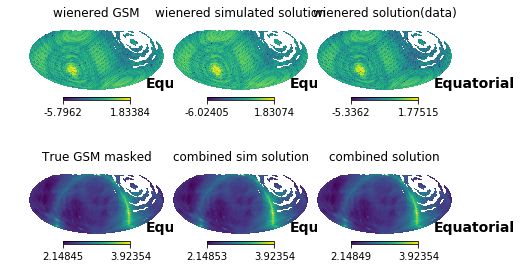

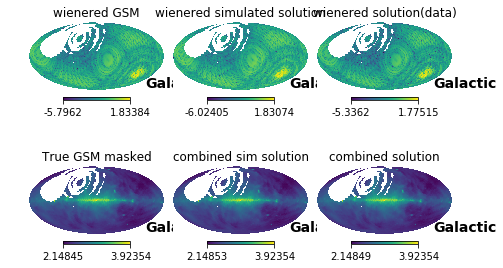

In [59]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(900 + crd)
	crd += 10
	plot_IQU_unlimit(np.abs(w_GSM), 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU_unlimit(np.abs(w_sim_sol), 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU_unlimit(np.abs(w_solution), 'wienered solution(data)', 3, coord=coord)
	plot_IQU_unlimit(np.abs(fake_solution), 'True GSM masked', 4, coord=coord)
	plot_IQU_unlimit(np.abs(w_sim_sol - w_GSM + fake_solution), 'combined sim solution', 5, coord=coord)
	plot_IQU_unlimit(np.abs(w_solution - w_GSM + fake_solution), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-rescale-none-unlimit-S-%s-recond-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard, S_type, rcond if Add_Rcond else 'none'))
	#plt.show(block=False)
	#plt.gcf().clear()
	


divide by zero encountered in log10


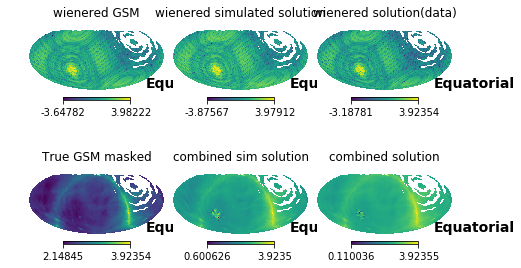

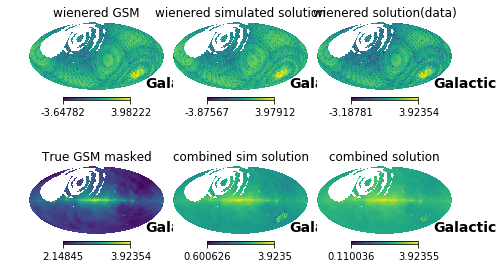

In [60]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(9000000 + crd)
	crd += 10
	plot_IQU_unlimit(np.abs(w_GSM) * rescale_factor, 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU_unlimit(np.abs(w_sim_sol) * rescale_factor, 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU_unlimit(np.abs(w_solution) * rescale_factor, 'wienered solution(data)', 3, coord=coord)
	plot_IQU_unlimit(np.abs(fake_solution), 'True GSM masked', 4, coord=coord)
	plot_IQU_unlimit(np.abs((w_sim_sol - w_GSM) * rescale_factor + fake_solution), 'combined sim solution', 5, coord=coord)
	plot_IQU_unlimit(np.abs((w_solution - w_GSM) * rescale_factor + fake_solution), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-rescale-%s-unlimit-S-%s-recond-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard, rescale_factor, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
	#plt.gcf().clear()
	

divide by zero encountered in log10


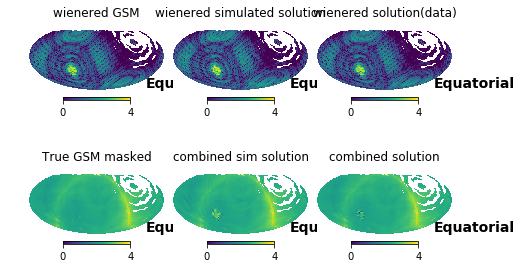

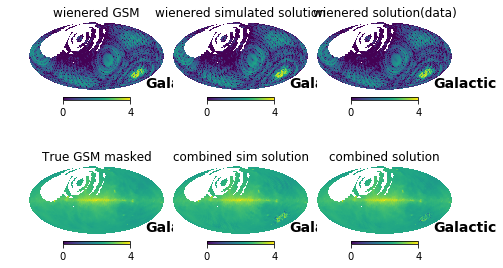

In [61]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(9500000 + crd)
	crd += 10
	plot_IQU(np.abs(w_GSM) * rescale_factor, 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU(np.abs(w_sim_sol) * rescale_factor, 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU(np.abs(w_solution) * rescale_factor, 'wienered solution(data)', 3, coord=coord)
	plot_IQU(np.abs(fake_solution), 'True GSM masked', 4, coord=coord)
	plot_IQU(np.abs((w_sim_sol - w_GSM) * rescale_factor + fake_solution), 'combined sim solution', 5, coord=coord)
	plot_IQU(np.abs((w_solution - w_GSM) * rescale_factor + fake_solution), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-rescale-%s-limit-S-%s-recond-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard, rescale_factor, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
	#plt.gcf().clear()

Casting complex values to real discards the imaginary part
divide by zero encountered in log10


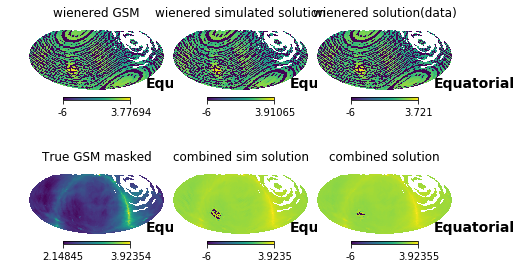

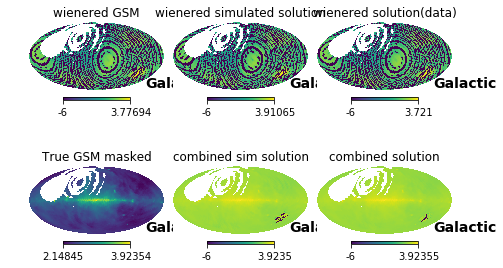

In [62]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(950 + crd)
	crd += 10
	plot_IQU_unlimit((w_GSM + np.abs(w_GSM))*0.5 * rescale_factor + 1.e-6, 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU_unlimit((w_sim_sol + np.abs(w_sim_sol))*0.5 * rescale_factor + 1.e-6, 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU_unlimit((w_solution + np.abs(w_solution))*0.5 * rescale_factor + 1.e-6, 'wienered solution(data)', 3, coord=coord)
	plot_IQU_unlimit((fake_solution + np.abs(fake_solution))*0.5 + 1.e-6, 'True GSM masked', 4, coord=coord)
	plot_IQU_unlimit((((w_sim_sol - w_GSM) * rescale_factor + fake_solution) + np.abs((w_sim_sol - w_GSM) * rescale_factor + fake_solution))*0.5 + 1.e-6, 'combined sim solution', 5, coord=coord)
	plot_IQU_unlimit((((w_solution - w_GSM) * rescale_factor + fake_solution) + np.abs((w_solution - w_GSM) * rescale_factor + fake_solution))*0.5 + 1.e-6, 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-rescale-%s-denegative-unlimit-S-%s-recond-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard, rescale_factor, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
	#plt.gcf().clear()

divide by zero encountered in log10


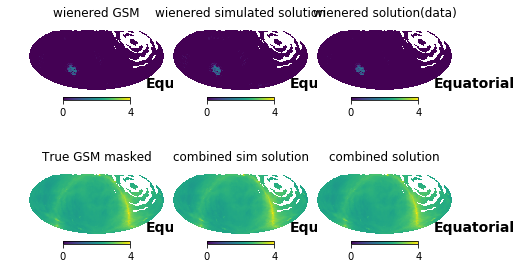

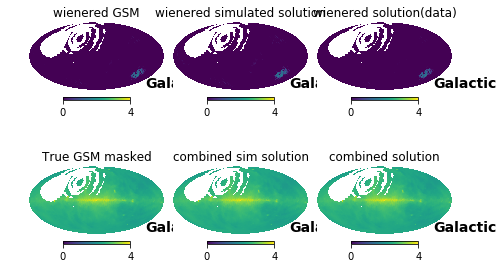

In [63]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(90000 + crd)
	crd += 10
	plot_IQU(np.abs(w_GSM), 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU(np.abs(w_sim_sol), 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU(np.abs(w_solution), 'wienered solution(data)', 3, coord=coord)
	plot_IQU(np.abs(fake_solution), 'True GSM masked', 4, coord=coord)
	plot_IQU(np.abs(w_sim_sol - w_GSM + fake_solution), 'combined sim solution', 5, coord=coord)
	plot_IQU(np.abs(w_solution - w_GSM + fake_solution), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-rescale-none-limit-S-%s-recond-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
	#plt.gcf().clear()
	

divide by zero encountered in log10


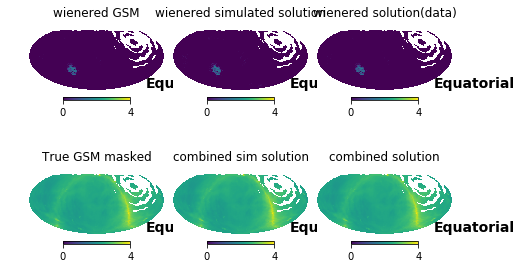

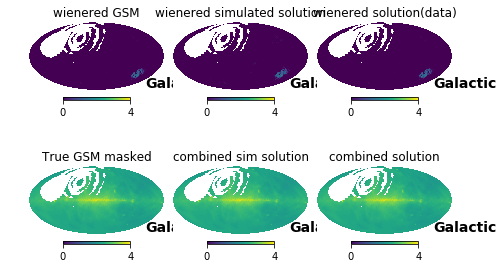

In [64]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(9000 + crd)
	crd += 10
	plot_IQU(np.abs(w_GSM/vis_normalization), 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU(np.abs(w_sim_sol/vis_normalization), 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU(np.abs(w_solution), 'wienered solution(data)', 3, coord=coord)
	plot_IQU(np.abs(fake_solution/vis_normalization), 'True GSM masked', 4, coord=coord)
	plot_IQU(np.abs((w_sim_sol - w_GSM + fake_solution)/vis_normalization), 'combined sim solution', 5, coord=coord)
	plot_IQU(np.abs((w_solution - w_GSM + fake_solution)/vis_normalization), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener_renormalized-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-rescale-none-limit-S-%s-recond-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
	#plt.gcf().clear()

chi^2 = 1.182e+10, data points 2160, pixels 10420
re/im chi2 9.750e+09, 2.066e+09
xx/yy chi2 8.232e+09, 3.584e+09


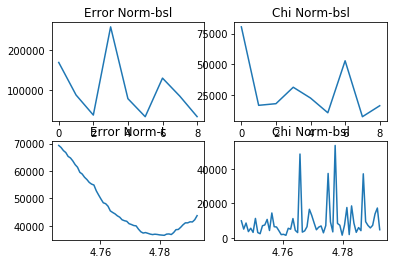

Additive_sol: [0.01722529+0.j 0.04348817+0.j]
('regularization stength', (0.0028371180535080283+0j), 'median GSM ranges between', 284.4070430340813, 284.4070430340813)
Rescale_factor: 140.7293124416259


In [65]:
error = data.reshape((2, data_shape['xx'][0], 2, data_shape['xx'][1])) - best_fit
chi = error * (Ni.reshape((2, data_shape['xx'][0], 2, data_shape['xx'][1])))**.5
print "chi^2 = %.3e, data points %i, pixels %i"%(la.norm(chi)**2, len(data), valid_npix)
print "re/im chi2 %.3e, %.3e"%(la.norm(chi[0])**2, la.norm(chi[1])**2)
print "xx/yy chi2 %.3e, %.3e"%(la.norm(chi[:, :, 0])**2, la.norm(chi[:, :, 1])**2)
#plt.clf()
plt.figure(120)
plt.subplot(2, 2, 1)
plt.plot([la.norm(error[:, u]) for u in ubl_sort['x']])
plt.title('Error Norm-bsl')
plt.subplot(2, 2, 2)
plt.plot([la.norm(chi[:, u]) for u in ubl_sort['x']])
plt.title('Chi Norm-bsl')
plt.subplot(2, 2, 3)
plt.plot(lsts, [la.norm(error[..., t]) for t in range(error.shape[-1])])
plt.title('Error Norm-t')
plt.subplot(2, 2, 4)
plt.plot(lsts, [la.norm(chi[..., t]) for t in range(error.shape[-1])])
plt.title('Chi Norm-bsl')
plt.savefig(script_dir + '/../Output/chi-%s-%s-dipole-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, freq, bnside, nside_standard))
plt.show(block=False)
#plt.gcf().clear()

try:
	print('Additive_sol: %s' %additive_sol[:2])
	print ("regularization stength", (maxAtNiA * rcond)**-.5, "median GSM ranges between", np.median(equatorial_GSM_standard) * min(sizes), np.median(equatorial_GSM_standard) * max(sizes))
	print('Rescale_factor: %s'%rescale_factor)
except:
	pass	


sys.stdout.flush()

In [66]:
#S_type = 'none'
#point spread function:
if True and S_type == 'none':
	print "Reading Regularized AtNiAi...",
	sys.stdout.flush()
	AtNiAi = sv.InverseCholeskyMatrix.fromfile(AtNiAi_path, len(S_diag), precision)

	AtNiA_tag = 'AtNiA_N%s'%vartag
	if not fit_for_additive:
		AtNiA_tag += "_noadd"
	elif crosstalk_type == 'autocorr':
		AtNiA_tag += "_autocorr"
	if pre_ampcal:
		AtNiA_tag += "_ampcal"
	AtNiA_filename = AtNiA_tag + A_filename
	AtNiA_path = datadir + tag + AtNiA_filename
	print "Reading AtNiA...",
	sys.stdout.flush()
	AtNiA = np.fromfile(AtNiA_path, dtype=precision).reshape((Ashape1, Ashape1))

	iplot = 0
	valid_thetas_phis = np.array(zip(thetas, phis))
	full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
	#plt.clf()
	plt.figure(130)
	for theta in np.arange(0, PI*.9, PI/6.):
		for phi in np.arange(0, TPI, PI/3.):
			iplot += 1
			choose_plots = [1, 12, 24]
			if iplot in choose_plots:
				np.argmin(la.norm(valid_thetas_phis - [theta, phi], axis=-1))
				point_vec = np.zeros_like(fake_solution).astype('complex128')

				point_vec[np.argmin(la.norm(valid_thetas_phis - [theta, phi], axis=-1))] = 1
				spreaded = sol2map(AtNiAi.dotv(AtNiA.dot(point_vec)))
				spreaded /= np.max(spreaded)
				fwhm_mask = np.abs(spreaded) >= .5
				masked_max_ind = np.argmax(spreaded[fwhm_mask])
				fwhm_thetas = full_thetas[fwhm_mask]
				fwhm_phis = full_phis[fwhm_mask]
				#rotate angles to center around PI/2 0
				fwhm_thetas, fwhm_phis = hpr.Rotator(rot=[fwhm_phis[masked_max_ind], PI/2-fwhm_thetas[masked_max_ind], 0], deg=False)(fwhm_thetas, fwhm_phis)
				if np.array(fwhm_thetas).shape is (): 
					fwhm_thetas = np.array([fwhm_thetas])
					fwhm_phis = np.array([fwhm_phis])
				print fwhm_thetas[masked_max_ind], fwhm_phis[masked_max_ind]#should print 1.57079632679 0.0 if rotation is working correctly


				fwhm_theta = max(fwhm_thetas) - min(fwhm_thetas)
				phi_offset = fwhm_phis[masked_max_ind] - PI
				fwhm_phis = (fwhm_phis - phi_offset)%TPI + phi_offset
				fwhm_phi = max(fwhm_phis) - min(fwhm_phis) 
				hpv.mollview(np.log10(np.abs(spreaded)), min=-3, max=0, nest=True, coord='CG', title='FWHM = %.3f'%((fwhm_theta*fwhm_phi)**.5*180./PI), sub=(len(choose_plots), 1, choose_plots.index(iplot)+1))
	plt.savefig(script_dir + '/../Output/spreaded_function-CG-%s-%s-dipole-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, freq, bnside, nside_standard))
	plt.show(block=False)
	#plt.gcf().clear()

In [67]:
print AtNiA_filename
print A_filename
print AtNiA_tag

AtNiA_N_2018__autocorr_ampcalA_dI_u9_t60_p10420_n32_32_b64_2.000_v1.0
A_dI_u9_t60_p10420_n32_32_b64_2.000_v1.0
AtNiA_N_2018__autocorr_ampcal


Reading Regularized AtNiAi... Reading AtNiA...

Casting complex values to real discards the imaginary part
divide by zero encountered in log10


 1.5707963267948966 -5.551115123125783e-17


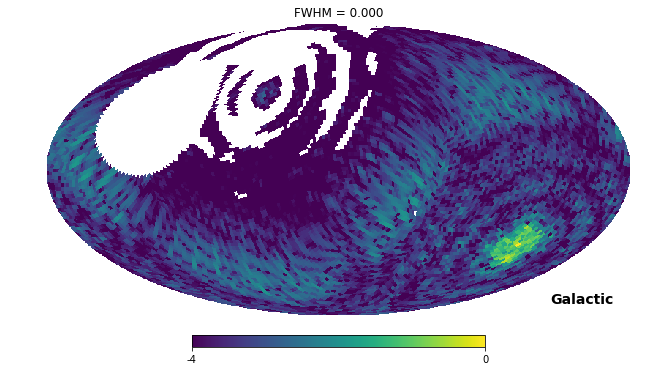

1.5707963267948966 3.5886741904258676e-18


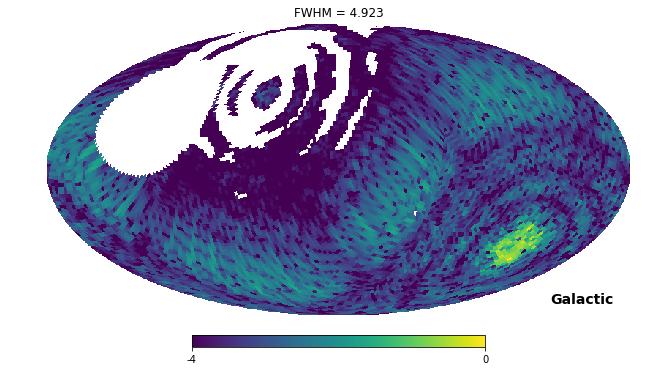

1.5707963267948966 -2.281514604560596e-17


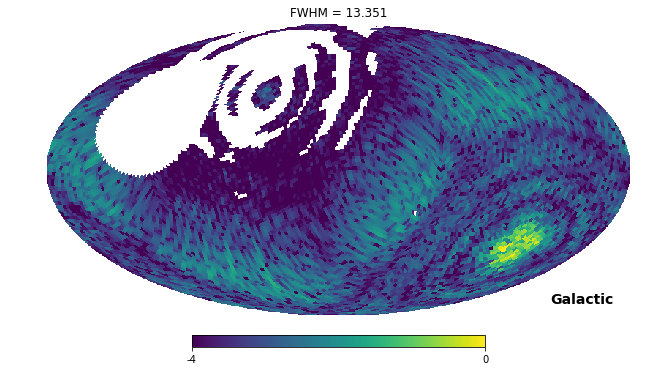

1.5707963267948966 -5.551115123125783e-17


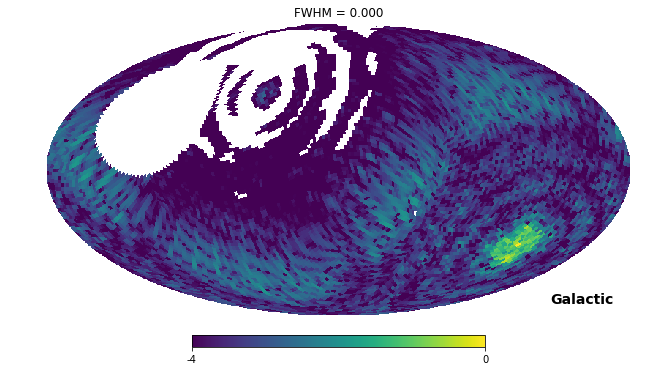

1.5707963267948966 6.2421462275232076e-18


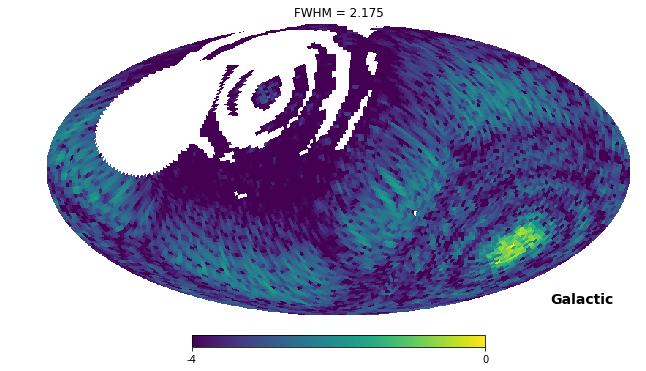

1.5707963267948966 -3.1689246296058633e-17


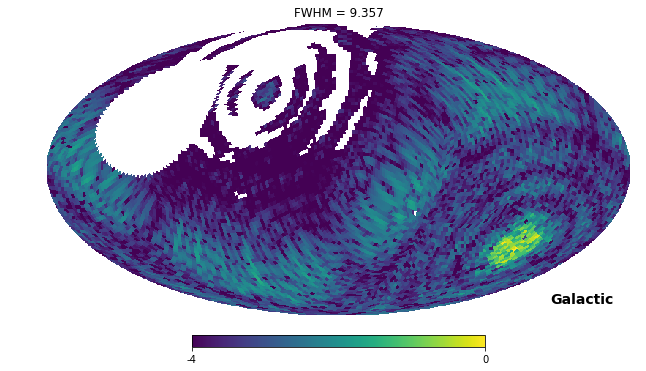

1.5707963267948966 1.2657715076548705e-17


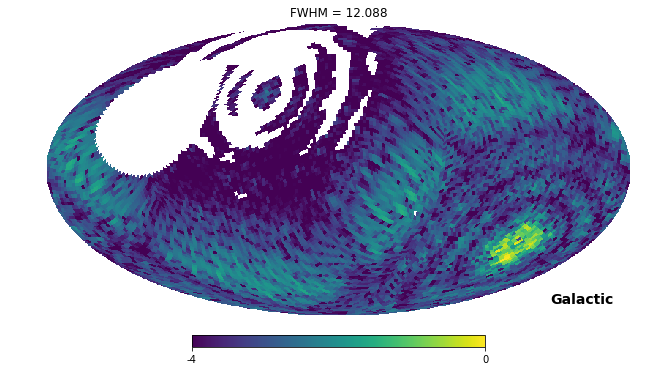

1.5707963267948966 -3.415498305426138e-17


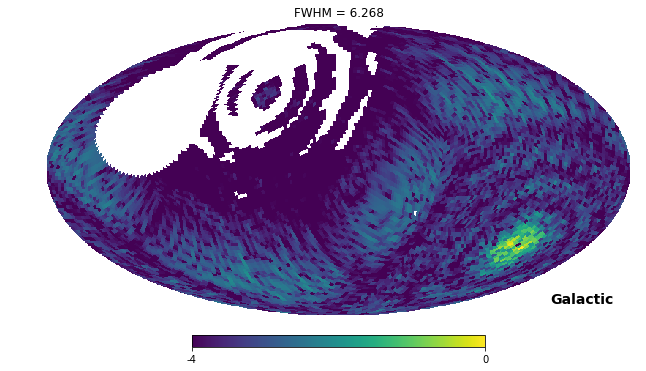

1.5707963267948966 -3.1689246296058633e-17


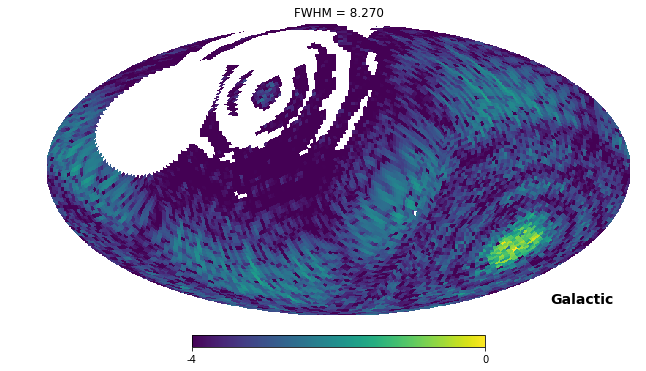

1.5707963267948966 -7.615484728191307e-18


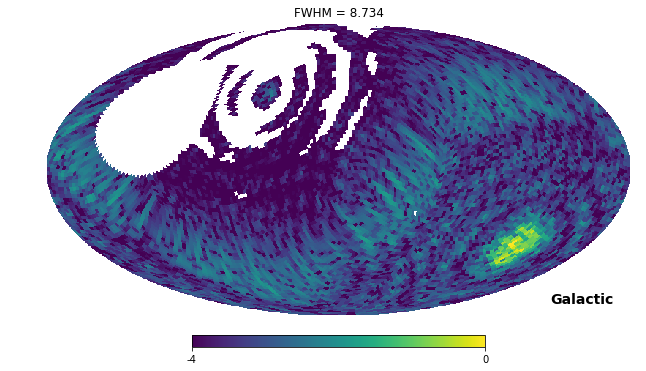

1.5707963267948966 7.423926927086674e-18


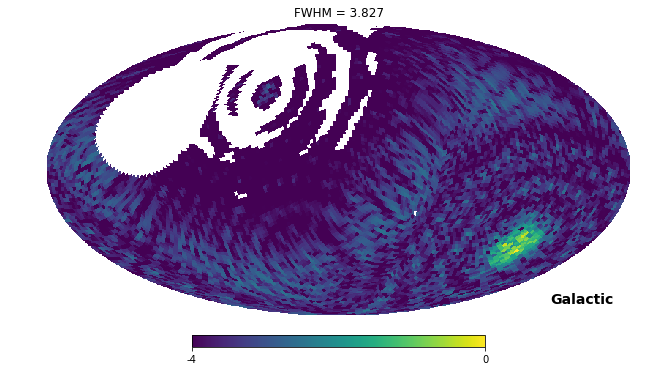

1.5707963267948966 -7.615484728191307e-18


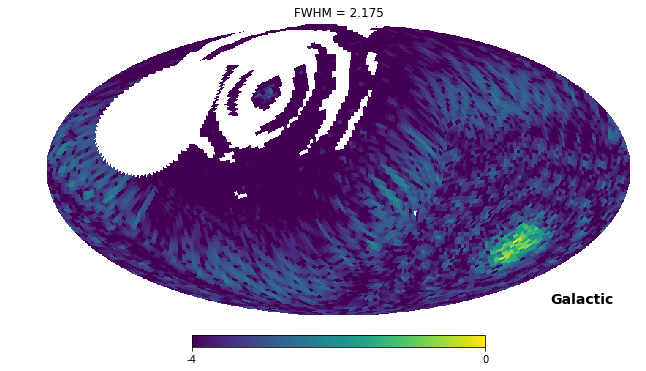

1.5707963267948963 -3.5635907036664564e-17


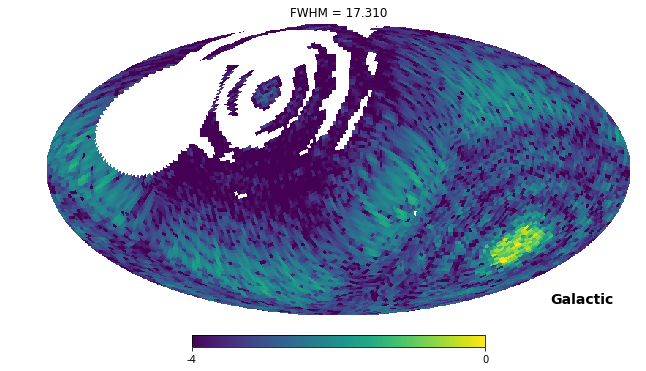

1.5707963267948966 -1.435714124375588e-17


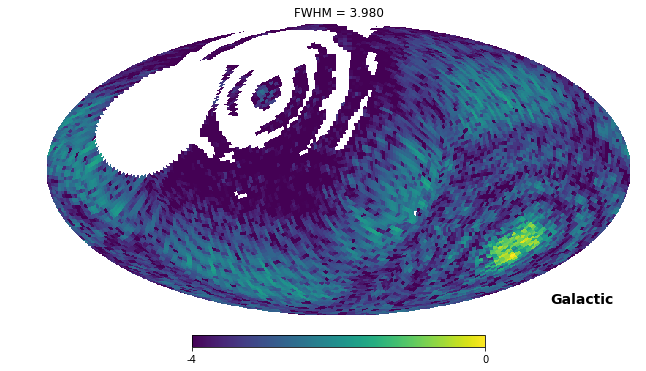

In [68]:
#S_type = 'none'
#point spread function:
if True:# and S_type == 'none':
	print "Reading Regularized AtNiAi...",
	sys.stdout.flush()
	AtNiAi = sv.InverseCholeskyMatrix.fromfile(AtNiAi_path, len(S_diag), precision)

	AtNiA_tag = 'AtNiA_N%s'%vartag
	if not fit_for_additive:
		AtNiA_tag += "_noadd"
	elif crosstalk_type == 'autocorr':
		AtNiA_tag += "_autocorr"
	if pre_ampcal:
		AtNiA_tag += "_ampcal"
	AtNiA_filename = AtNiA_tag + A_filename
	AtNiA_path = datadir + tag + AtNiA_filename
	print "Reading AtNiA...",
	sys.stdout.flush()
	AtNiA = np.fromfile(AtNiA_path, dtype=precision).reshape((Ashape1, Ashape1))

	iplot = 0
	valid_thetas_phis = np.array(zip(thetas, phis))
	full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
	#plt.clf()
	
	for theta in np.arange(0, PI*.9, PI/6.):
		for phi in np.arange(0, TPI, PI/3.):
			
			#choose_plots = [1, 6, 12, 18, 24, 30]
			choose_plots = [0, 1, 4, 6, 8, 12, 16, 20, 24, 28, 30, 32, 33, 35]
			
			if iplot in choose_plots:
				np.argmin(la.norm(valid_thetas_phis - [theta, phi], axis=-1))
				point_vec = np.zeros_like(fake_solution).astype('complex128')

				point_vec[np.argmin(la.norm(valid_thetas_phis - [theta, phi], axis=-1))] = 1
				spreaded = sol2map(AtNiAi.dotv(AtNiA.dot(point_vec)))
				spreaded /= np.max(spreaded)
				fwhm_mask = np.abs(spreaded) >= .5
				masked_max_ind = np.argmax(spreaded[fwhm_mask])
				fwhm_thetas = full_thetas[fwhm_mask]
				fwhm_phis = full_phis[fwhm_mask]
				#rotate angles to center around PI/2 0
				fwhm_thetas, fwhm_phis = hpr.Rotator(rot=[fwhm_phis[masked_max_ind], PI/2-fwhm_thetas[masked_max_ind], 0], deg=False)(fwhm_thetas, fwhm_phis)
				if np.array(fwhm_thetas).shape is (): 
					fwhm_thetas = np.array([fwhm_thetas])
					fwhm_phis = np.array([fwhm_phis])
				print fwhm_thetas[masked_max_ind], fwhm_phis[masked_max_ind]#should print 1.57079632679 0.0 if rotation is working correctly


				fwhm_theta = max(fwhm_thetas) - min(fwhm_thetas)
				phi_offset = fwhm_phis[masked_max_ind] - PI
				fwhm_phis = (fwhm_phis - phi_offset)%TPI + phi_offset
				fwhm_phi = max(fwhm_phis) - min(fwhm_phis)
				plt.figure(1300+iplot) 
				#hpv.mollview(np.log10(np.abs(spreaded)), min=-3, max=0, nest=True, coord='CG', title='FWHM = %.3f'%((fwhm_theta*fwhm_phi)**.5*180./PI), sub=(len(choose_plots), 1, choose_plots.index(iplot)+1))
				hpv.mollview(np.log10(np.abs(spreaded)), min=-4, nest=True, coord='CG', title='FWHM = %.3f'%((fwhm_theta*fwhm_phi)**.5*180./PI))
				plt.savefig(script_dir + '/../Output/spreaded_function-CG-%s-%s-%s-dipole-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, iplot, freq, bnside, nside_standard))
				plt.show(block=False)
				#plt.gcf().clear()
			iplot += 1


sys.stdout.flush()


In [69]:
#point_vec